*Visualización de Datos*<br>
*Magister y Diplomado en Data Science*
# De qué mueren los chilenos
**Profesor:** Fernando Becerra<br>
**Estudiantes:** <br>Catalina Quijada<br>Claudia Fernandino<br>Patricio Céspedes

## Introducción

La esperanza de vida ha aumentado en Chile, debido a los avances médicos y tecnológicos, así como las políticas de salud pública. Esto ha hecho que las causas de muerte también hayan cambiado a través de los años, desde una predominancia de las infecciones y enfermedades virales, a aquellas producidas por el deterioro debido a la edad (INE, *s.f.*). Lo anterior vuelve interesante analizar las causas de fallecimiento predominantes en los últimos años en Chile, para encontrar patrones y estacionalidad según distintos grupos. Asimismo, debido a la pandemia por COVID-19, resulta de interés estudiar sus efectos en las causas de muerte durante los años 2020 y 2021 (INE, 2022).

A continuación, se presenta un análisis de las causas de muerte para los años 2016 a 2021, desagregando por distintos grupos de interés, como región, edad, sexo. Para esto, se utilizan los datos de muerte por causa disponibles en la página web del [DEIS](https://deis.minsal.cl/), así como las proyecciones de población realizadas por el [INE](https://www.ine.cl/estadisticas/sociales/demografia-y-vitales/proyecciones-de-poblacion). 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import locale
import regex as re
import math
import textwrap
import geopandas as gpd
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
cols_def=["ANO_DEF","FECHA_DEF","GLOSA_SEXO","EDAD_TIPO","EDAD_CANT","CODIGO_COMUNA_RESIDENCIA",
          "GLOSA_COMUNA_RESIDENCIA","GLOSA_REG_RES","DIAG1","CAPITULO_DIAG1","GLOSA_CAPITULO_DIAG1",
          "CODIGO_GRUPO_DIAG1","GLOSA_GRUPO_DIAG1","CODIGO_CATEGORIA_DIAG1","GLOSA_CATEGORIA_DIAG1",
          "CODIGO_SUBCATEGORIA_DIAG1","GLOSA_SUBCATEGORIA_DIAG1","DIAG2","CAPITULO_DIAG2",
          "GLOSA_CAPITULO_DIAG2","CODIGO_GRUPO_DIAG2","GLOSA_GRUPO_DIAG2","CODIGO_CATEGORIA_DIAG2",
          "GLOSA_CATEGORIA_DIAG2","CODIGO_SUBCATEGORIA_DIAG2","GLOSA_SUBCATEGORIA_DIAG2","LUGAR_DEFUNCION"]
defunciones_tot = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)
defunciones_tot = defunciones_tot[(defunciones_tot['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_tot = defunciones_tot[defunciones_tot.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_tot.loc[defunciones_tot.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_tot = defunciones_tot[['ANO_DEF','FECHA_DEF']]
defunciones_tot = (defunciones_tot.groupby(by=['ANO_DEF'])
               .count()
               .reset_index()
               .rename(columns = {'ANO_DEF':'anio',
                                  'FECHA_DEF':'n_def'}))
proy_pob_tot = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_tot = (proy_pob_tot[['Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021'
               
           }))
proy_pob_tot = (pd.melt(proy_pob_tot,
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob'
           })
           .groupby(['anio'])
           .sum()
           .reset_index())
proy_pob_tot['anio'] = proy_pob_tot['anio'].astype('int64')
tasa_def_tot = defunciones_tot.merge(proy_pob_tot,how='left',on=['anio'])
tasa_def_tot['tasa_def_tot'] = tasa_def_tot['n_def']/tasa_def_tot['pob']*100000

In [3]:
defunciones_com = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)

defunciones_com = defunciones_com[(defunciones_com['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_com = defunciones_com[defunciones_com.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_com.loc[defunciones_com.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_com = defunciones_com[['CODIGO_COMUNA_RESIDENCIA','ANO_DEF','GLOSA_COMUNA_RESIDENCIA','GLOSA_CAPITULO_DIAG1','FECHA_DEF']]
defunciones_com = (defunciones_com.groupby(by=['CODIGO_COMUNA_RESIDENCIA','GLOSA_COMUNA_RESIDENCIA','ANO_DEF','GLOSA_CAPITULO_DIAG1'])
               .count()
               .reset_index()
               .rename(columns = {'CODIGO_COMUNA_RESIDENCIA':'Comuna',
                                  'GLOSA_COMUNA_RESIDENCIA' : 'Glosa Comuna',
                                  'GLOSA_CAPITULO_DIAG1':'causa',
                                  'ANO_DEF':'anio',
                                  'FECHA_DEF':'n_def'}))

proy_pob_com = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_com = (proy_pob_com[['Comuna','Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021'
               
           }))
proy_pob_com = (pd.melt(proy_pob_com,id_vars='Comuna',
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob'
           })
           .groupby(['Comuna','anio'])
           .sum()
           .reset_index())

proy_pob_com_rur = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_com_rur = (proy_pob_com_rur[['Comuna','Area (1=Urbano 2=Rural)','Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021',
                              'Area (1=Urbano 2=Rural)':'area'
               
           }))
proy_pob_com_rur = (pd.melt(proy_pob_com_rur,id_vars=['Comuna','area'],
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob_rur'
           })
           .groupby(['Comuna','anio','area'])
           .sum()
           .reset_index())
proy_pob_com_rur = proy_pob_com_rur[proy_pob_com_rur['area']==2]

proy_pob_com['anio'] = proy_pob_com['anio'].astype('int64')
proy_pob_com_rur['anio'] = proy_pob_com_rur['anio'].astype('int64')

tasa_def_com = (defunciones_com.merge(proy_pob_com,how='left',on=['Comuna','anio'])
.merge(proy_pob_com_rur[['Comuna','anio','pob_rur']],how='left',on=['Comuna','anio']))
tasa_def_com['tasa_def_com'] = tasa_def_com['n_def']/tasa_def_com['pob']*100000
tasa_def_com['tasa_rur'] = tasa_def_com['pob_rur']/tasa_def_com['pob']*100
tasa_def_com['region'] = np.where(tasa_def_com['Comuna']>=10000, tasa_def_com['Comuna'].astype(str).str[0:2], tasa_def_com['Comuna'].astype(str).str[0])
tasa_def_com['region'] = tasa_def_com['region'].astype('int64')

In [4]:
defunciones_nac = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)

defunciones_nac = defunciones_nac[(defunciones_nac['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_nac = defunciones_nac[defunciones_nac.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_nac.loc[defunciones_nac.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_nac = defunciones_nac[['ANO_DEF','GLOSA_CAPITULO_DIAG1','FECHA_DEF']]
defunciones_nac = (defunciones_nac.groupby(by=['ANO_DEF','GLOSA_CAPITULO_DIAG1'])
               .count()
               .reset_index()
               .rename(columns = {'GLOSA_CAPITULO_DIAG1':'causa',
                                  'ANO_DEF':'anio',
                                  'FECHA_DEF':'n_def'}))

proy_pob_nac = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_nac = (proy_pob_nac[['Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021'
               
           }))
proy_pob_nac = (pd.melt(proy_pob_nac,
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob'
           })
           .groupby(['anio'])
           .sum()
           .reset_index())
proy_pob_nac['anio'] = proy_pob_nac['anio'].astype('int64')

tasa_def_nac = (defunciones_nac.merge(proy_pob_nac,how='left',on=['anio']))
tasa_def_nac['tasa_def_nac'] = tasa_def_nac['n_def']/tasa_def_nac['pob']*100000


In [5]:
defunciones_edad = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)

defunciones_edad = defunciones_edad[(defunciones_edad['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_edad = defunciones_edad[defunciones_edad.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_edad.loc[defunciones_edad.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_edad['edad'] = np.where(defunciones_edad['EDAD_TIPO']==1,defunciones_edad['EDAD_CANT'],
                                   np.where(defunciones_edad['EDAD_TIPO']==2,round(defunciones_edad['EDAD_CANT']/12),
                                           np.where(defunciones_edad['EDAD_TIPO']==3,round(defunciones_edad['EDAD_CANT']/365),
                                                   np.where(defunciones_edad['EDAD_TIPO']==4,round(defunciones_edad['EDAD_CANT']/8760),None))))
defunciones_edad['rango_edad'] = np.where((defunciones_edad['edad']>=0) & (defunciones_edad['edad']<=9), '0 a 9 años',
                                         np.where((defunciones_edad['edad']>=10) & (defunciones_edad['edad']<=19), '10 a 19 años',
                                                 np.where((defunciones_edad['edad']>=20) & (defunciones_edad['edad']<=39), '20 a 39 años',
                                                         np.where((defunciones_edad['edad']>=40) & (defunciones_edad['edad']<=59), '40 a 59 años',
                                                                 np.where((defunciones_edad['edad']>=60) & (defunciones_edad['edad']<=79), '60 a 79 años',
                                                                         np.where((defunciones_edad['edad']>=80), '80 años o más',None))))))
defunciones_edad = defunciones_edad[['ANO_DEF','rango_edad','GLOSA_CAPITULO_DIAG1','FECHA_DEF']].dropna()
defunciones_edad = (defunciones_edad.groupby(by=['ANO_DEF','rango_edad','GLOSA_CAPITULO_DIAG1'])
               .count()
               .reset_index()
               .rename(columns = {'GLOSA_CAPITULO_DIAG1':'causa',
                                  'ANO_DEF':'anio',
                                  'FECHA_DEF':'n_def'}))
proy_pob_edad = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_edad = (proy_pob_edad[['Grupo edad','Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021'
               
           }))
proy_pob_edad['rango_edad'] = np.where((proy_pob_edad['Grupo edad']=='0 Año') | (proy_pob_edad['Grupo edad']=='De 1 a 4 años')|(proy_pob_edad['Grupo edad']=='De 5 a 9 años'),'0 a 9 años',
                                      np.where((proy_pob_edad['Grupo edad']=='De 10 a 14 años') | (proy_pob_edad['Grupo edad']=='De 15 a 19 años'),'10 a 19 años',
                                              np.where((proy_pob_edad['Grupo edad']=='De 20 a 24 años') | (proy_pob_edad['Grupo edad']=='De 25 a 29 años')|(proy_pob_edad['Grupo edad']=='De 30 a 34 años')|(proy_pob_edad['Grupo edad']=='De 35 a 39 años'),'20 a 39 años',
                                                      np.where((proy_pob_edad['Grupo edad']=='De 40 a 44 años') | (proy_pob_edad['Grupo edad']=='De 45 a 49 años')|(proy_pob_edad['Grupo edad']=='De 50 a 54 años')|(proy_pob_edad['Grupo edad']=='De 55 a 59 años'),'40 a 59 años',
                                                              np.where((proy_pob_edad['Grupo edad']=='De 60 a 64 años') | (proy_pob_edad['Grupo edad']=='De 65 a 69 años')|(proy_pob_edad['Grupo edad']=='De 70 a 74 años')|(proy_pob_edad['Grupo edad']=='De 75 a 79 años'),'60 a 79 años','80 años o más')))))
proy_pob_edad = proy_pob_edad[['rango_edad','2016','2017','2018','2019','2020','2021']]
proy_pob_edad = (pd.melt(proy_pob_edad,id_vars='rango_edad',
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob'
           })
           .groupby(['rango_edad','anio'])
           .sum()
           .reset_index())
proy_pob_edad['anio'] = proy_pob_edad['anio'].astype('int64')
tasa_def_edad = (defunciones_edad.merge(proy_pob_edad,how='left',on=['rango_edad','anio']))
tasa_def_edad['tasa_def_edad'] = tasa_def_edad['n_def']/tasa_def_edad['pob']*100000

In [6]:
defunciones_gen = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)

defunciones_gen = defunciones_gen[(defunciones_gen['CODIGO_COMUNA_RESIDENCIA']!=99999) & (defunciones_gen['GLOSA_SEXO']!='Indeterminado')]
defunciones_gen = defunciones_gen[defunciones_gen.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_gen.loc[defunciones_gen.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_gen = defunciones_gen[['GLOSA_SEXO','ANO_DEF','GLOSA_CAPITULO_DIAG1','FECHA_DEF']]
defunciones_gen = (defunciones_gen.groupby(by=['GLOSA_SEXO','ANO_DEF','GLOSA_CAPITULO_DIAG1'])
               .count()
               .reset_index()
               .rename(columns = {'GLOSA_SEXO':'sexo',
                                  'GLOSA_CAPITULO_DIAG1':'causa',
                                  'ANO_DEF':'anio',
                                  'FECHA_DEF':'n_def'}))

proy_pob_gen = pd.read_excel("estimaciones-y-proyecciones-2002-2035-comuna-y-área-urbana-y-rural.xlsx",
                        sheet_name="EEPP comuna área")
proy_pob_gen = (proy_pob_gen[['Sexo (1=Hombre 2=Mujer)','Poblacion 2016','Poblacion 2017','Poblacion 2018','Poblacion 2019',
                     'Poblacion 2020','Poblacion 2021']]
           .rename(columns = {'Poblacion 2016':'2016',
                              'Poblacion 2017':'2017',
                              'Poblacion 2018':'2018',
                              'Poblacion 2019':'2019',
                              'Poblacion 2020':'2020',
                              'Poblacion 2021':'2021',
                              'Sexo (1=Hombre 2=Mujer)':'sexo'
               
           }))

proy_pob_gen['sexo'] = np.where(proy_pob_gen['sexo']==1,'Hombre','Mujer')
proy_pob_gen = (pd.melt(proy_pob_gen,id_vars='sexo',
                   value_vars=['2016','2017','2018','2019','2020','2021'])
           .rename(columns = {
               'variable':'anio',
               'value':'pob'
           })
           .groupby(['sexo','anio'])
           .sum()
           .reset_index())


proy_pob_gen['anio'] = proy_pob_gen['anio'].astype('int64')
tasa_def_gen = (defunciones_gen.merge(proy_pob_gen,how='left',on=['sexo','anio']))
tasa_def_gen['tasa_def_gen'] = tasa_def_gen['n_def']/tasa_def_gen['pob']*100000

In [7]:
def hide_border(ax):
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

## Tasa de mortalidad total por año
En el siguiente gráfico, se observa que la tasa de mortalidad en Chile tuvo un abrupto crecimiento en 2020 y 2021 respecto a los años anteriores. Entre 2016 a 2019, el mayor nivel de mortalidad estuvo alrededor de 580 cada 100.000 habitantes, mientras que en 2020 dicha tasa superó el valor de 600, e incluso bordeó los 700 en 2021.

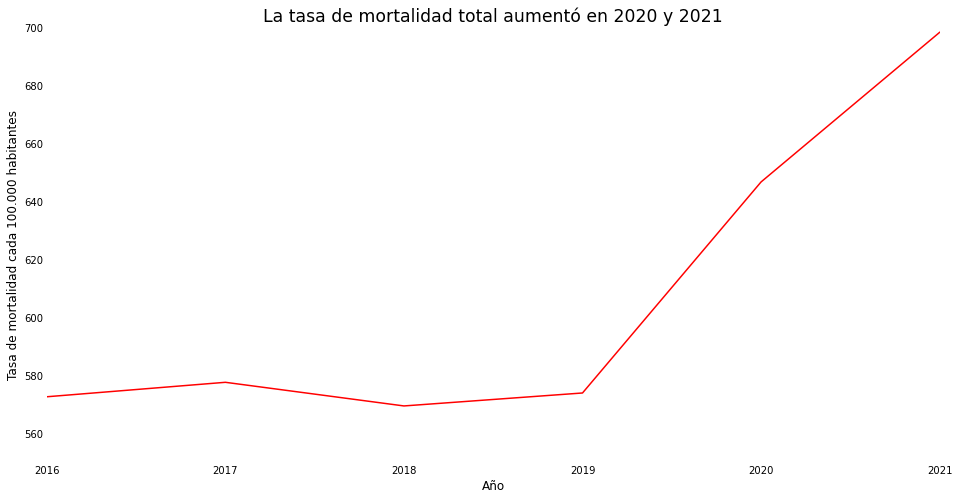

In [8]:
tab0 = tasa_def_tot[['anio','tasa_def_tot']].set_index('anio')
fig, ax = plt.subplots(1,1, figsize=(16,8))
tab0.plot.line(ax=ax,c='r',legend=None)
plt.title("La tasa de mortalidad total aumentó en 2020 y 2021",fontsize='xx-large') 
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.ylim(550, 700)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

Para saber qué puede estar generando este aumento en 2020 y 2021, se puede explorar la mortalidad por causa. Tal como se aprecia en el siguiente gráfico, durante el período 2016 a 2021 las principales causas de muerte en Chile son: tumores, enfermedades del sistema circulatorio y enfermedades del sistema respiratorio. Asimismo, se observa que la mortalidad por enfermedades del sistema respiratorio presenta un aumento importante en 2020 y 2021, superando a las otras dos principales causas de mortalidad, las cuales anteriormente eran más altas. Dentro de las enfermedades del sistema respiratorio se encuentra el Covid-19, que llegó a Chile a principios de 2020. Por lo tanto, el aumento en la tasa de mortalidad en 2020 y 2021 se explica por las muertes debido a Covid-19.

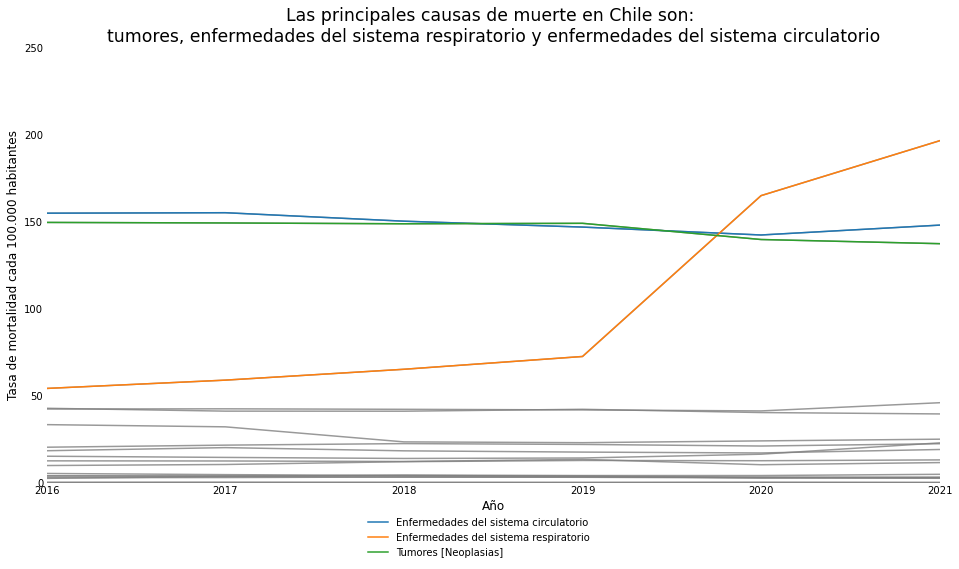

In [9]:
tab1 = tasa_def_nac.pivot_table(values="tasa_def_nac",index=["causa"],columns = "anio",aggfunc=sum).dropna()
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab1.index:
    tab1.loc[year].plot.line(ax=ax,label='_Hiden',color='gray',alpha=.8)

plt.title("Las principales causas de muerte en Chile son: \ntumores, enfermedades del sistema respiratorio y enfermedades del sistema circulatorio",fontsize='xx-large') 
plt.plot(tab1.loc['Enfermedades del sistema circulatorio '], label='Enfermedades del sistema circulatorio')
plt.plot(tab1.loc['Enfermedades del sistema respiratorio '], label='Enfermedades del sistema respiratorio ')
plt.plot(tab1.loc['Tumores [Neoplasias]'], label='Tumores [Neoplasias]')
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.legend(loc='upper left',bbox_to_anchor=(0.35, -0.06, 0.5, 0), frameon=False)
plt.ylim(0, 250)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

In [10]:
defunciones_mes = pd.read_csv("DEFUNCIONES_FUENTE_DEIS_2016_2022_15092022.csv", 
                          encoding='latin-1',
                          sep=";",
                         header=None,
                         names=cols_def)
defunciones_mes = defunciones_mes[(defunciones_mes['CODIGO_COMUNA_RESIDENCIA']!=99999)]
defunciones_mes = defunciones_mes[defunciones_mes.ANO_DEF.isin([2016,2017,2018,2019,2020,2021])]
defunciones_mes.loc[defunciones_mes.GLOSA_CAPITULO_DIAG1 == 'Códigos para propósitos especiales', 'GLOSA_CAPITULO_DIAG1'] = 'Enfermedades del sistema respiratorio '
defunciones_mes['fecha'] = pd.to_datetime(defunciones_mes['FECHA_DEF'], format='%Y-%m-%d')
defunciones_mes['mes'] = defunciones_mes['fecha'].dt.strftime('%m')
defunciones_mes['region'] = np.where(defunciones_mes['CODIGO_COMUNA_RESIDENCIA']>=10000, defunciones_mes['CODIGO_COMUNA_RESIDENCIA'].astype(str).str[0:2], defunciones_mes['CODIGO_COMUNA_RESIDENCIA'].astype(str).str[0])
defunciones_mes['region'] = defunciones_mes['region'].astype('int64')
defunciones_mes_causa = defunciones_mes[['ANO_DEF','mes','GLOSA_CAPITULO_DIAG1','FECHA_DEF']]
defunciones_mes_causa = defunciones_mes_causa[defunciones_mes_causa['GLOSA_CAPITULO_DIAG1']!='Enfermedades del ojo y sus anexos']
defunciones_mes_causa = defunciones_mes_causa[defunciones_mes_causa['GLOSA_CAPITULO_DIAG1']!='Embarazo, parto y puerperio']
defunciones_mes_causa = (defunciones_mes_causa.groupby(by=['ANO_DEF','mes','GLOSA_CAPITULO_DIAG1']).
                         count().
                         reset_index()
                        .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_causa['tasa_def'] = defunciones_mes_causa['FECHA_DEF']/defunciones_mes_causa['pob']*100000
defunciones_mes_causa = (defunciones_mes_causa.pivot_table(values='tasa_def',index=["mes",'GLOSA_CAPITULO_DIAG1'], columns = "ANO_DEF",aggfunc=sum).dropna())
defunciones_mes_causa = defunciones_mes_causa.reset_index()
meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']

## Estacionalidad por causa
Si bien el gráfico anterior permite identificar las principales causas de muerte en Chile durante los últimos años, no es muy útil para analizar la evolución de cada causa de muerte, principalmente para aquellas que tienen tasas más bajas. Para esto, se presenta el siguiente gráfico, el cual no solo desagrega las muertes por año, sino también por mes, de modo que es posible analizar si existe cierta estacionalidad.

Algunas de las muertes que han tenido una baja durante los últimos años son las causadas por 'ciertas afecciones originadas en el período perinatal' y 'malformaciones congénitas, deformidades y anomalías cromosómicas'. Una de las posibles causas que podría originar esto es la ley de aborto en tres causales, la que incluye la posibilidad de interrumpir el embarazo en caso de inviabilidad fetal. Por lo tanto, es posible que estas situaciones se detecten durante el embarazo y se decida interrumpirlo, disminuyendo así la tasa de mortalidad. 

Otra tasa de mortalidad que muestra una disminución es la causada por 'Enfermedades endocrinas, nutricionales y metabólicas', que disminuye a partir de 2018. Cabe mencionar que, dentro de esta causa, la principal es la diabetes mellitus y, a partir del año 2017, la bomba de insulina es cubierta por la Ley Ricarte Soto, lo cual podría impactar en una menor tasa de mortalidad, ya que esta es principalmente para pacientes graves.

Por otro lado, existen algunas tasas de mortalidad que han aumentado en los últimos años. Tal es el caso de enfermedades respiratorias, ya que, tal como se mencionó anteriormente, debido a la llegada del Covid-19 presenta un alza importante en 2020 y 2021. Asimismo, se observa que las muertes por esta causa tienen una marcada estacionalidad, aumentando en los meses de invierno. También se observa un aumento en la tasa de mortalidad debido a enfermedades mentales y del comportamiento, la cual también presenta una estacionalidad con una mayor tasa en invierno. Del mismo modo, en el año 2021 hay un importante aumento de las muertes causadas por 'Síntomas, signos y hallazgos anormales clínicos y de laboratorio, no clasificados en otra parte'. Si bien todavía no se encuentra completamente estudiado, la comunidad científica ha hablado sobre el 'Covid largo', el cual se refiere a las consecuencias a largo plazo del Covid-19. Por lo tanto, es posible especular que existen ciertas consecuencias de esta enfermedad que todavía no se han estudiado y, por ende, podrían estar causando mortalidad en la población. En 2021, también se observa un aumento, principalmente en el segundo semestre, de las muertes causadas por enfermedades de la piel y el tejido subcutáneo, así como las enfermedades del sistema digestivo.

Otra causa de muerte que presenta una tendencia interesante son las enfermedades del sistema circulatorio, la cual es mayor durante los meses de invierno. Existen estudios que indican que el frío puede aumentar el riesgo de accidente cerebrovascular, dado que la reacción del cuerpo para mantener la temperatura podría aumentar la presión. Esto podría explicar la estacionalidad de esta causa de muerte.

Las muertes por traumatismos, envenenamientos y algunas otras consecuencias de causas externas también presentan una estacionalidad, aunque la tasa es mayor en los meses de verano. Lo anterior podría deberse a que durante la época de vacaciones se produce más accidentes en carreteras. Asimismo, en esta categoría se clasifican las muertes por lesiones autoinfligidas voluntariamente (suicidio), las cuales se producen principalmente entre octubre a enero.

Las muertes por tumores presentan una tendencia interesante, ya que son más bajas durante los meses en que las muertes por enfermedades respiratorias son más altas (2020 a 2021). Sin embargo, es importante leer este dato con cuidado, ya que no necesariamente implica que la gente se enfermó menos de cáncer por este período. Más bien, puede ocurrir que, debido a que las personas con cáncer se encuentran inmunosuprimidas, al contagiarse de Covid-19 es más probable que fallezcan y, si esto se produce, la causa de muerte se clasifica en Covid-19. Por lo tanto, es probable que personas con cáncer hayan muerto a causa de Covid-19 y no del cáncer mismo, si no por encontrarse en un estado de salud más débil.

Una tendencia similar se observa en la tasa de mortalidad por enfermedades infecciosas y parasitarias, la cual disminuye de forma importante durante los meses en que hubo más muertes por enfermedades respiratorias a causa del Covid-19. Dado que en muchas comunas del país se decretó cuarentena, la gente estaba menos expuesta a este tipo de enfermedades, al mismo tiempo que las medidas sanitarias, como el lavado de manos y uso de mascarilla, aumentaron de forma considerable en la población. Estos dos factores podrían explicar la disminución de la tasa de mortalidad por esta causa durante este período.

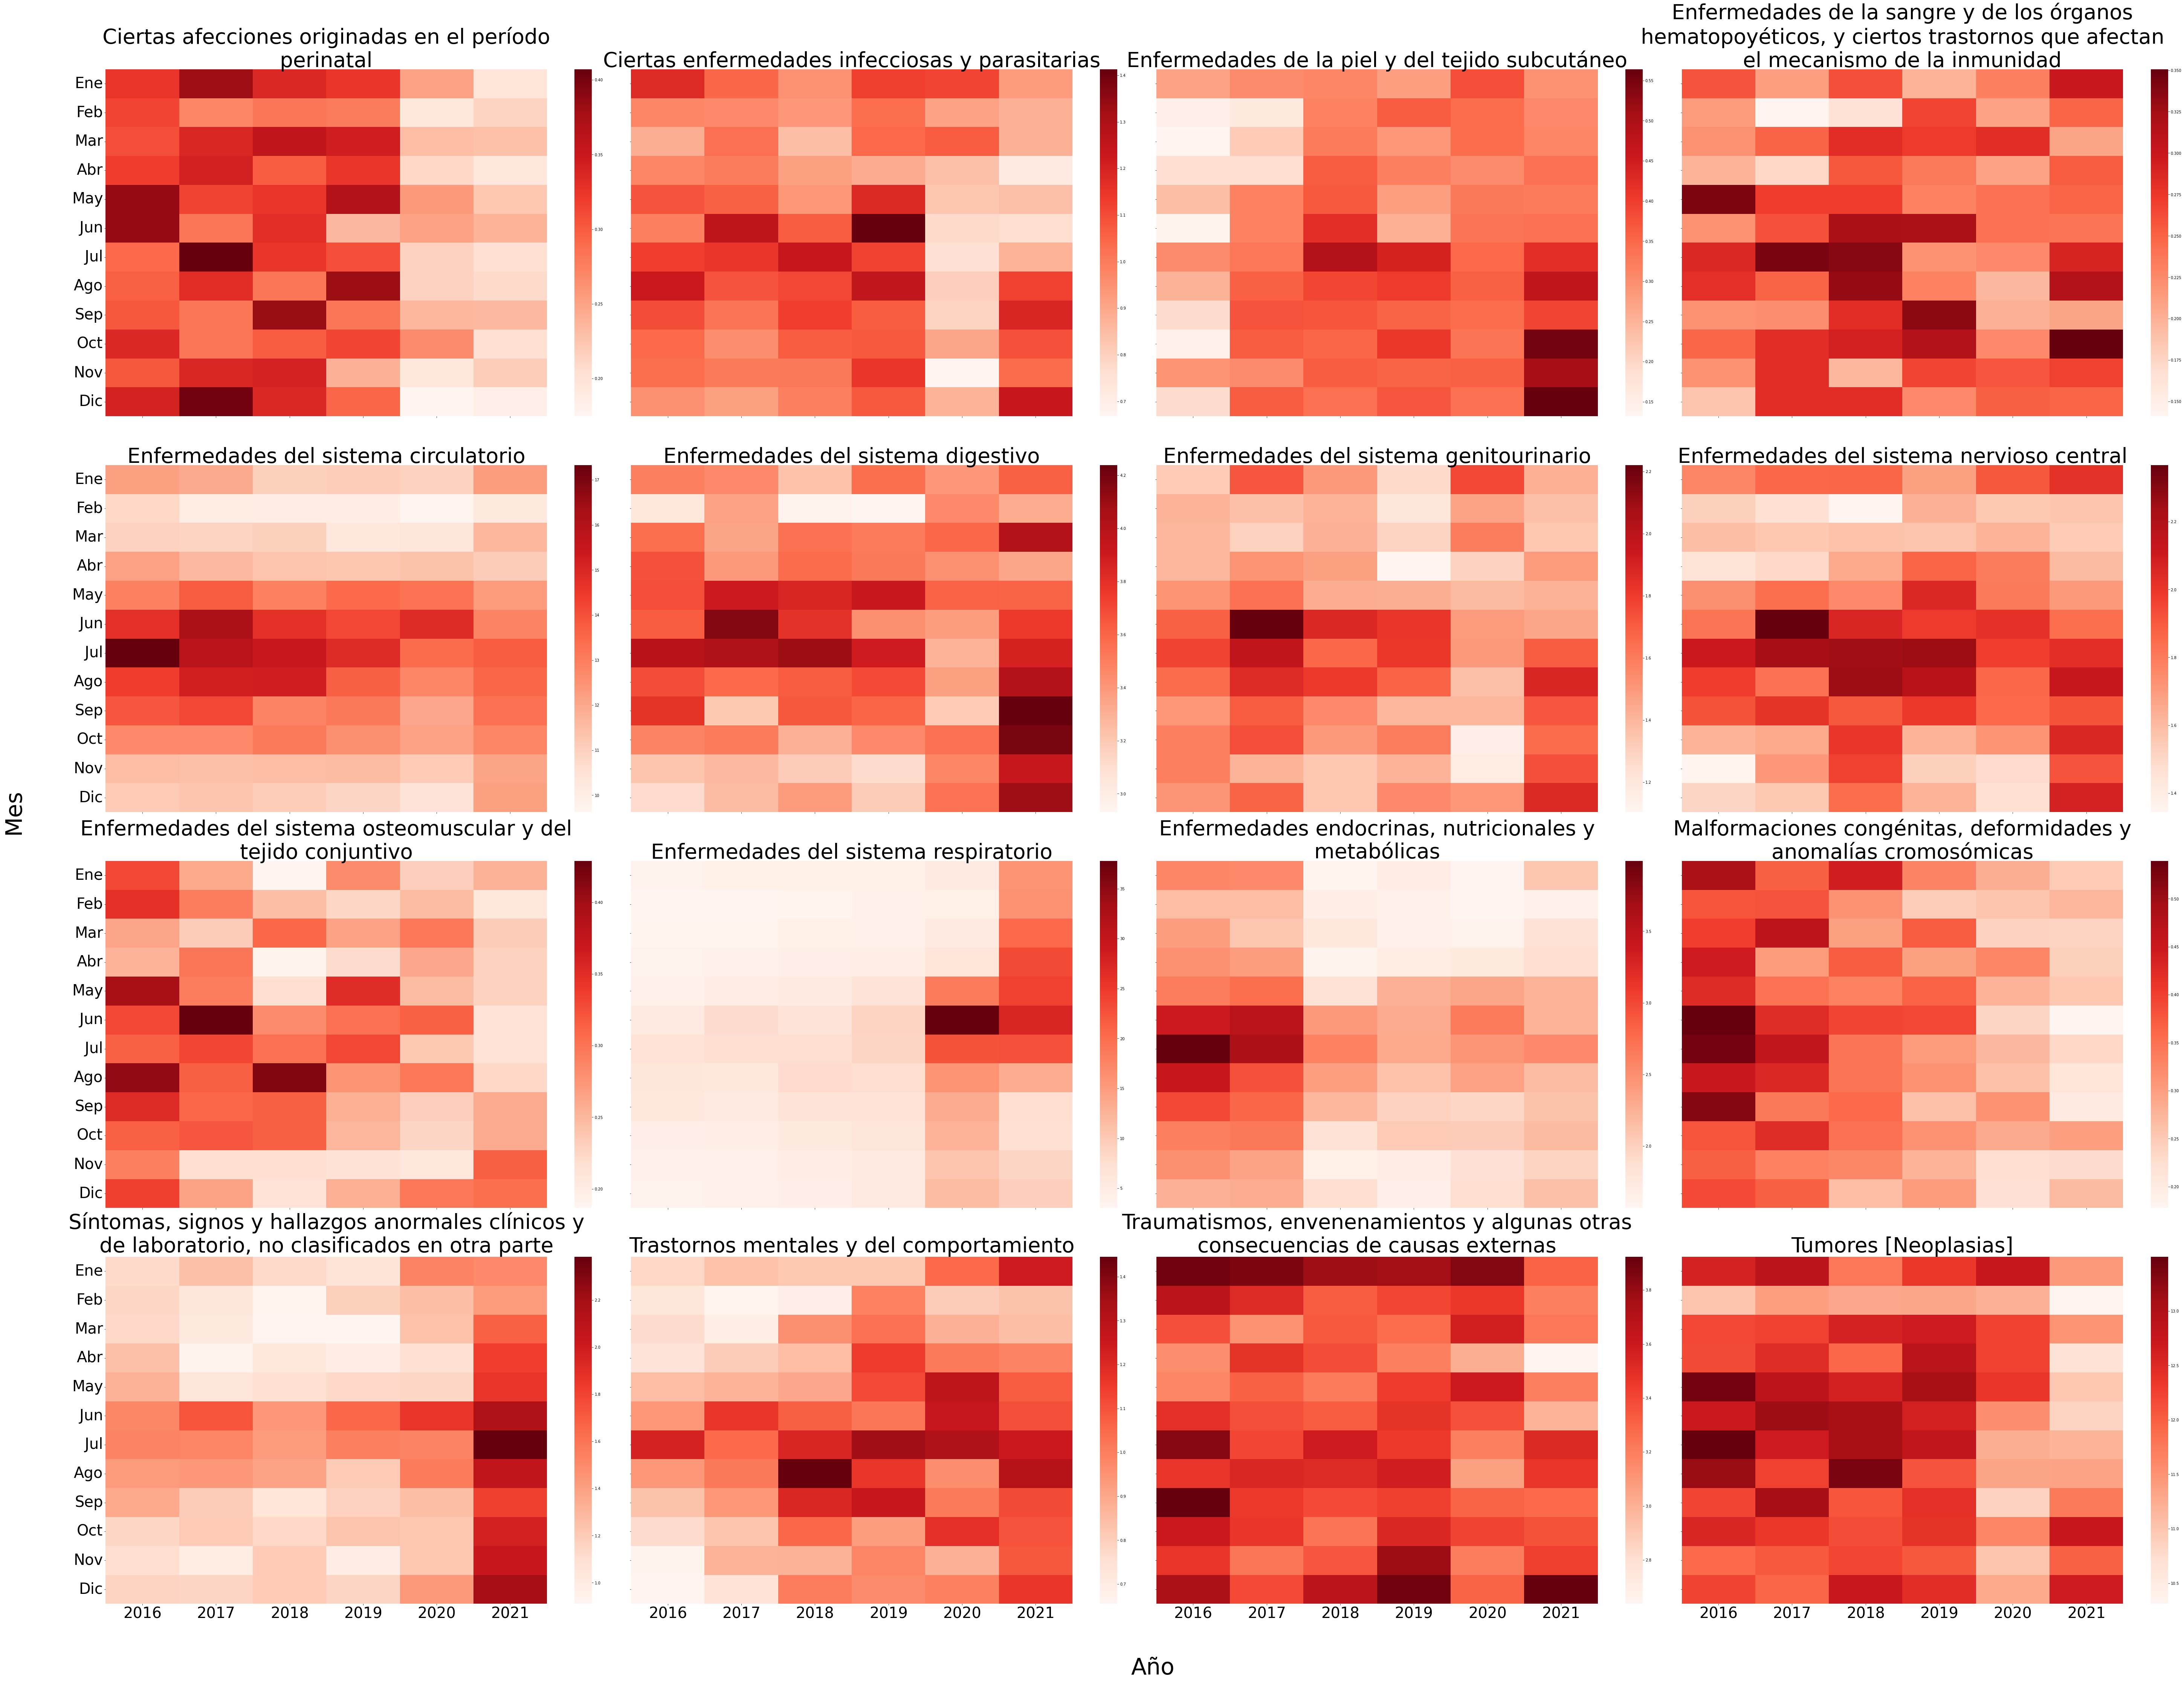

In [11]:
causas = defunciones_mes_causa['GLOSA_CAPITULO_DIAG1'].unique()
ncausas = len(causas)
cols = 4
rows = int(ncausas/cols)
def plot_causa(causa, ax, df):
    data = (
        df[df['GLOSA_CAPITULO_DIAG1'] == causa]
            .drop(['GLOSA_CAPITULO_DIAG1'], axis=1)
            .set_index('mes')
        )
    sns.heatmap(data, ax=ax, cmap='Reds', yticklabels=meses)
    ax.set_title('\n'.join(textwrap.wrap(causa,50)) ,fontsize=55)
    ax.set_xlabel('',fontsize=1)
    ax.set_ylabel('',fontsize=1)
    ax.tick_params(labelsize=40,labelrotation=0)
fig, ax = plt.subplots(rows, cols, figsize=(80,60),sharey=True,sharex=True)

for idx_causa, causa in enumerate(causas):
    row = int(idx_causa / cols)
    col = idx_causa % cols
    plot_causa(causa, ax[row][col],defunciones_mes_causa)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60)
fig.tight_layout()

## Relación entre edad y causa de muerte
Para enriquecer el análisis, se revisan también los patrones de causa de mortalidad para distintos grupos etarios, definiendo los siguientes rangos: 0 a 9, 10 a 19, 20 a 39, 40 a 59, 60 a 79, y 8 o más años. 

En el siguiente gráfico se observa que, en el grupo de 0 a 9 años, las principales causas de muerte son 'ciertas afecciones originadas en el período perinatal' y 'malformaciones congénitas, deformidades y anomalías cromosómicas'. Cabe destacar que ambas causas de muerte han presentado una baja durante los últimos años, lo cual podría deberse a la implementación de la ley de interrumpción voluntaria del embarazo en tres causales. 
Sin embargo, la tercera causa de fallecimiento, correspondiente a 'traumatismos, envenenamientos y algunas otras consecuencias de causas externas', se mantiene en niveles similares entre 2016 a 2021.

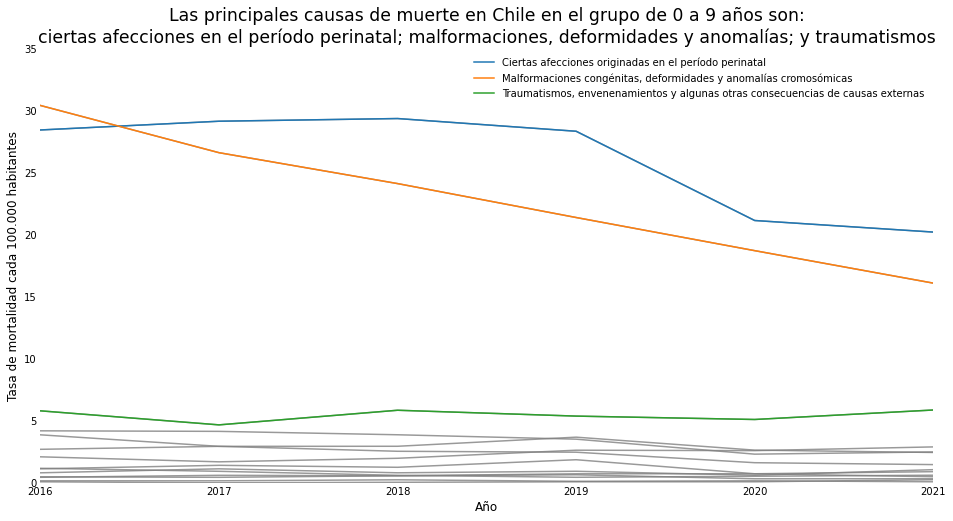

In [12]:
tasa_def_edad_0 = tasa_def_edad[tasa_def_edad['rango_edad'] == '0 a 9 años']
tab2 = tasa_def_edad_0.pivot_table(values="tasa_def_edad",index=["causa"],columns = "anio",aggfunc=sum).dropna()
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab2.index:
    tab2.loc[year].plot.line(ax=ax,label='_Hiden',color='gray',alpha=.8)

plt.plot(tab2.loc['Ciertas afecciones originadas en el período perinatal'], label='Ciertas afecciones originadas en el período perinatal')
plt.plot(tab2.loc['Malformaciones congénitas, deformidades y anomalías cromosómicas'], label='Malformaciones congénitas, deformidades y anomalías cromosómicas')
plt.plot(tab2.loc['Traumatismos, envenenamientos y algunas otras consecuencias de causas externas'], label='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas')
plt.title("Las principales causas de muerte en Chile en el grupo de 0 a 9 años son:\nciertas afecciones en el período perinatal; malformaciones, deformidades y anomalías; y traumatismos",fontsize='xx-large') 
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.legend(frameon=False)
plt.ylim(0, 35)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

Por otro lado, en el grupo de 10 a 19 años, la principal causa de muerte son los 'traumatismos, envenenamientos y algunas otras consecuencias de causas externas', aunque esta presenta una baja entre 2016 y 2017.

En segundo lugar, se encuentran las muertes por tumores, las cuales no estaban presentes en el grupo anterior. Cabe recordar que esta es una de las 3 principales causas de muerte en Chile, por lo que es interesante ver que aparece ya en este grupo de edad como una de las principales causas. 

En tercer lugar, se encuentran las enfermedades del sistema nervioso central, excepto en 2021, donde adquieren predominancia las enfermedades del sistema respiratorio, debido a la aparición del Covid-19. 

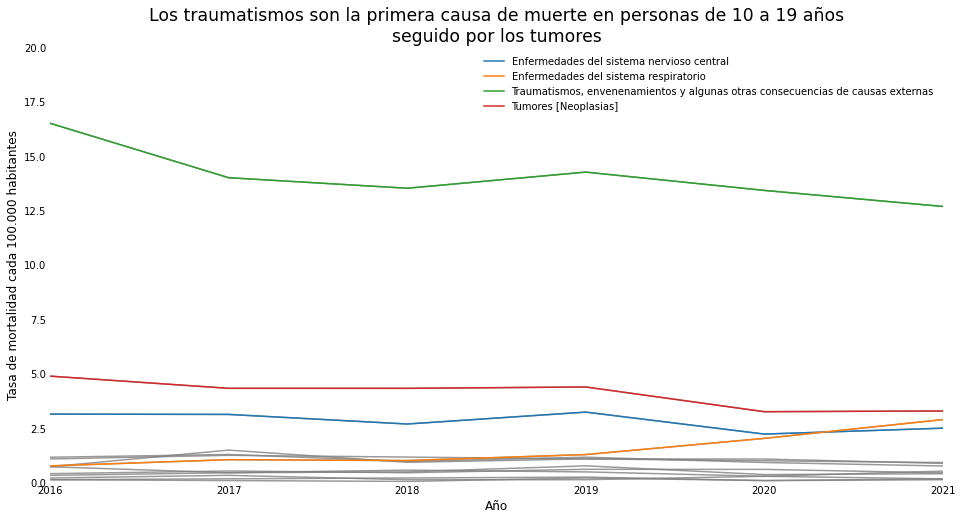

In [13]:
tasa_def_edad_10 = tasa_def_edad[tasa_def_edad['rango_edad'] == '10 a 19 años']
tab3 = tasa_def_edad_10.pivot_table(values="tasa_def_edad",index=["causa"],columns = "anio",aggfunc=sum).dropna()
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab3.index:
    tab3.loc[year].plot.line(ax=ax,label='_Hiden',color='gray',alpha=.8)

plt.plot(tab3.loc['Enfermedades del sistema nervioso central'], label='Enfermedades del sistema nervioso central')
plt.plot(tab3.loc['Enfermedades del sistema respiratorio '], label='Enfermedades del sistema respiratorio ')
plt.plot(tab3.loc['Traumatismos, envenenamientos y algunas otras consecuencias de causas externas'], label='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas')
plt.plot(tab3.loc['Tumores [Neoplasias]'], label='Tumores [Neoplasias]')
plt.title("Los traumatismos son la primera causa de muerte en personas de 10 a 19 años\nseguido por los tumores",fontsize='xx-large') 
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.legend(frameon=False)
plt.ylim(0, 20)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

En el grupo etario de 20 a 39 años, se presenta una tendencia similar a la del grupo anterior. En este sentido, la principal causa de muerte son los 'traumatismos, envenenamientos y algunas otras consecuencias de causas externas'. Sin embargo, el aumento de los fallecimientos provocados por enfermedades del sistema respiratorio es mayor en los años 2020 y 2021, respecto al grupo analizado anteriormente, llegando a posicionarse como la segunda causa de muerte en este período.

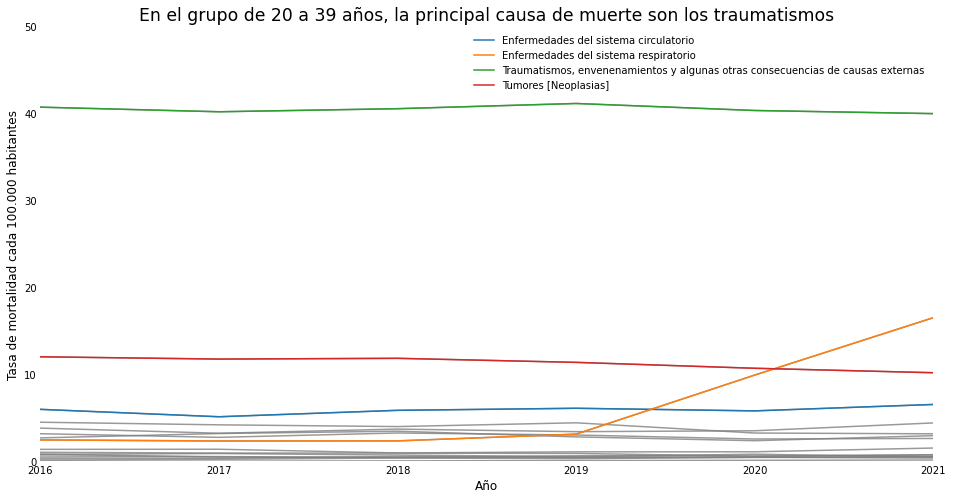

In [14]:
tasa_def_edad_20 = tasa_def_edad[tasa_def_edad['rango_edad'] == '20 a 39 años']
tab4 = tasa_def_edad_20.pivot_table(values="tasa_def_edad",index=["causa"],columns = "anio",aggfunc=sum).dropna()
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab4.index:
    tab4.loc[year].plot.line(ax=ax,label='_Hiden',color='gray',alpha=.8)

plt.plot(tab4.loc['Enfermedades del sistema circulatorio '], label='Enfermedades del sistema circulatorio ')
plt.plot(tab4.loc['Enfermedades del sistema respiratorio '], label='Enfermedades del sistema respiratorio ')
plt.plot(tab4.loc['Traumatismos, envenenamientos y algunas otras consecuencias de causas externas'], label='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas')
plt.plot(tab4.loc['Tumores [Neoplasias]'], label='Tumores [Neoplasias]')
plt.title("En el grupo de 20 a 39 años, la principal causa de muerte son los traumatismos",fontsize='xx-large') 
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.legend(frameon=False)
plt.ylim(0, 50)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

En el rango etario de 40 a 59 años, ya se observa la mayor preponderancia de los fallecimientos debido a tumores, siendo la primera causa de muerte en el período 2016 a 2020. En este mismo período, la segunda causa de muerte más importante son las enfermedades del sistema circulatorio (que no aparecía en los grupos etarios anteriores), seguido por enfermedades del sistema digestivo y traumatismos. En 2021 se produce un quiebre en la tendencia observada anteriormente, ya que con la aparición del Covid-19 las muertes debido a enfermedades del sistema respiratorio se convierten en la principal causa.

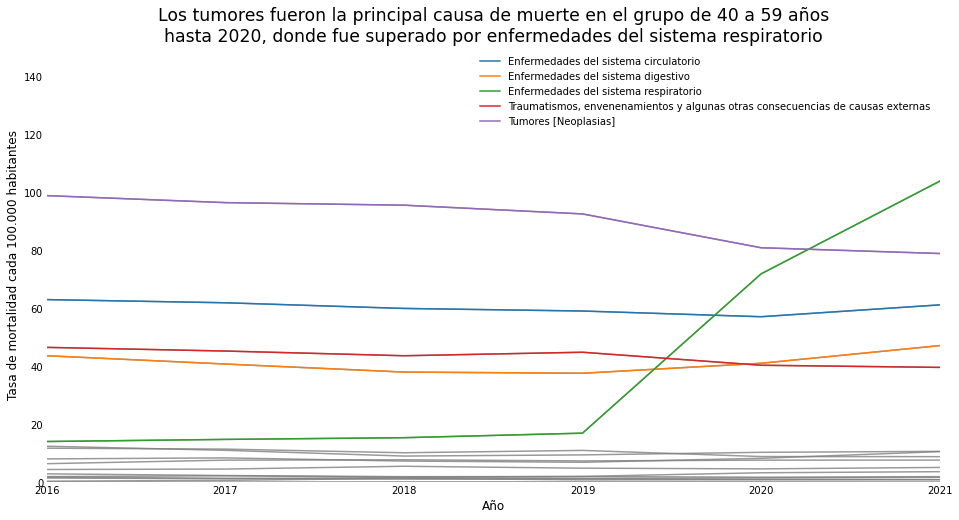

In [15]:
tasa_def_edad_40 = tasa_def_edad[tasa_def_edad['rango_edad'] == '40 a 59 años']
tab5 = tasa_def_edad_40.pivot_table(values="tasa_def_edad",index=["causa"],columns = "anio",aggfunc=sum).dropna()
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab5.index:
    tab5.loc[year].plot.line(ax=ax,label='_Hiden',color='gray',alpha=.8)

plt.plot(tab5.loc['Enfermedades del sistema circulatorio '], label='Enfermedades del sistema circulatorio ')
plt.plot(tab5.loc['Enfermedades del sistema digestivo'], label='Enfermedades del sistema digestivo')
plt.plot(tab5.loc['Enfermedades del sistema respiratorio '], label='Enfermedades del sistema respiratorio ')
plt.plot(tab5.loc['Traumatismos, envenenamientos y algunas otras consecuencias de causas externas'], label='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas')
plt.plot(tab5.loc['Tumores [Neoplasias]'], label='Tumores [Neoplasias]')
plt.title("Los tumores fueron la principal causa de muerte en el grupo de 40 a 59 años\nhasta 2020, donde fue superado por enfermedades del sistema respiratorio",fontsize='xx-large') 
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.legend(frameon=False)
plt.ylim(0, 150)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

Ahora bien, en el grupo de edad de 60 a 79 años, nuevamente la principal causa de muerte son los tumores, seguido por las enfermedades del sistema circulatorio. Sin embargo, en 2020 las enfermedades del sistema respiratorio superan a las del sistema circulatorio, e incluso en 2021 superan a los tumores como la principal causa. 

Asimismo, en este grupo etario se observa una leve disminución de las muertes por enfermedades del sistema circulatorio y tumores en los años 2020 y 2021. No obstante, como se mencionó anteriormente, esto podría deberse a que las personas con estas enfermedades eran consideradas población de riesgo para el Covid-19 y, por lo tanto, en caso de enfermarse las consecuencias podrían ser peores. De este modo, en caso de morir debido a la combinación de Covid-19 y otra enfermedad crónica, la causa de muerte especificada es la primera.

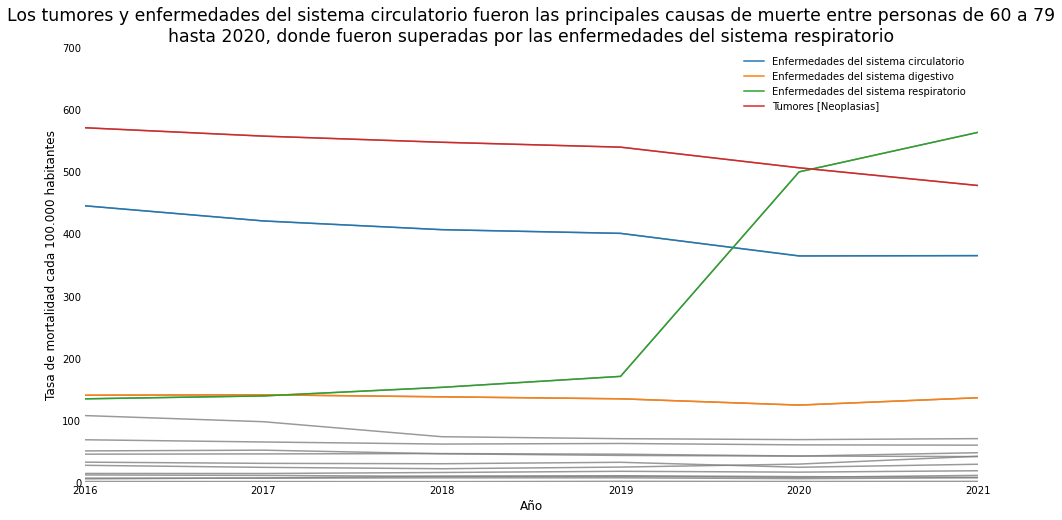

In [16]:
tasa_def_edad_60 = tasa_def_edad[tasa_def_edad['rango_edad'] == '60 a 79 años']
tab6 = tasa_def_edad_60.pivot_table(values="tasa_def_edad",index=["causa"],columns = "anio",aggfunc=sum).dropna()
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab6.index:
    tab6.loc[year].plot.line(ax=ax,label='_Hiden',color='gray',alpha=.8)

plt.plot(tab6.loc['Enfermedades del sistema circulatorio '], label='Enfermedades del sistema circulatorio ')
plt.plot(tab6.loc['Enfermedades del sistema digestivo'], label='Enfermedades del sistema digestivo')
plt.plot(tab6.loc['Enfermedades del sistema respiratorio '], label='Enfermedades del sistema respiratorio ')
plt.plot(tab6.loc['Tumores [Neoplasias]'], label='Tumores [Neoplasias]')
plt.title("Los tumores y enfermedades del sistema circulatorio fueron las principales causas de muerte entre personas de 60 a 79\nhasta 2020, donde fueron superadas por las enfermedades del sistema respiratorio",fontsize='xx-large') 
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.legend(frameon=False)
plt.ylim(0, 700)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

Por último, en el grupo de 80 o más años, hasta 2020 la principal causa de muerte fueron las enfermedades del sistema circulatorio, siendo levemente superada en 2021 por las enfermedades del sistema respiratorio, pese a que eran considerados uno de los grupos de mayor riesgo frente al Covid-19. Asimismo, los tumores se encontraban en segundo lugar hasta 2019, pero a partir de 2020 también perdieron preponderancia frente a las enfermedades del sistema respiratorio.

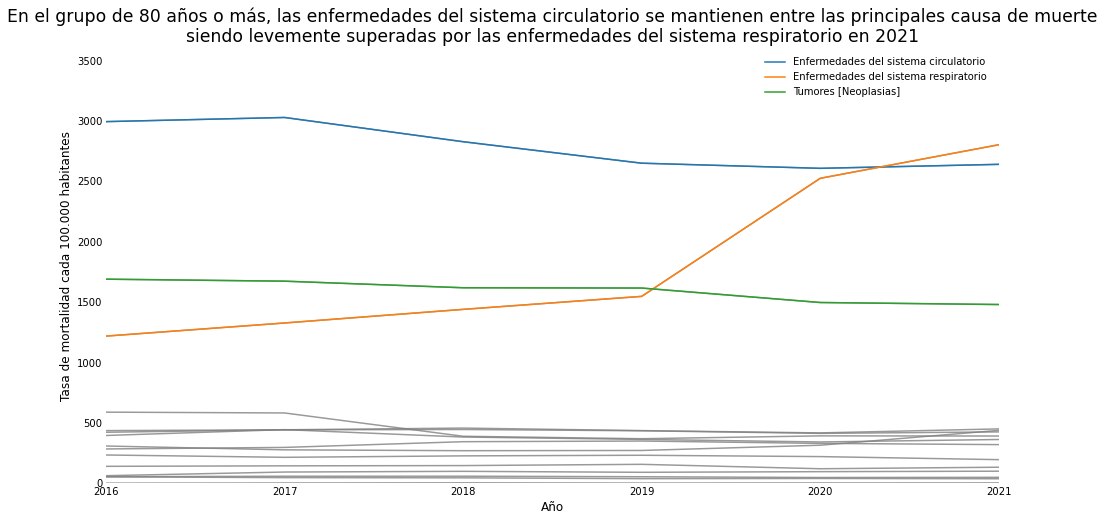

In [17]:
tasa_def_edad_80 = tasa_def_edad[tasa_def_edad['rango_edad'] == '80 años o más']
tab7 = tasa_def_edad_80.pivot_table(values="tasa_def_edad",index=["causa"],columns = "anio",aggfunc=sum).dropna()
fig, ax = plt.subplots(1,1, figsize=(16,8))

for year in tab7.index:
    tab7.loc[year].plot.line(ax=ax,label='_Hiden',color='gray',alpha=0.8)

plt.plot(tab7.loc['Enfermedades del sistema circulatorio '], label='Enfermedades del sistema circulatorio ')
plt.plot(tab7.loc['Enfermedades del sistema respiratorio '], label='Enfermedades del sistema respiratorio ')
plt.plot(tab7.loc['Tumores [Neoplasias]'], label='Tumores [Neoplasias]')
plt.title("En el grupo de 80 años o más, las enfermedades del sistema circulatorio se mantienen entre las principales causa de muerte\nsiendo levemente superadas por las enfermedades del sistema respiratorio en 2021",fontsize='xx-large') 
plt.xlabel("Año",fontsize='large')
plt.ylabel("Tasa de mortalidad cada 100.000 habitantes",fontsize='large')
plt.legend(frameon=False)
plt.ylim(0, 3600)
plt.xlim(2016,2021)
hide_border(ax)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.show()

## Análisis de patrones por región
Chile se caracteriza por una gran diversidad territorial, lo cual influye en la calidad de vida y hábitos de la población que habita las distintas zonas del país. Es por esto que es de interés analizar si existen diferencias en las causas de muerte entre las regiones, y su evolución en el tiempo.

In [18]:
defunciones_mes['region_o'] = defunciones_mes['region'].map({
    1:2,
    2:3,
    3:4,
    4:5,
    5:6,
    6:8,
    7:9,
    8:11,
    9:12,
    10:14,
    11:15,
    12:16,
    13:7,
    14:13,
    15:1,
    16:10
})

In [19]:
defunciones_mes_res_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema respiratorio ']
defunciones_mes_res_reg = defunciones_mes_res_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_res_reg = (defunciones_mes_res_reg.groupby(by=['ANO_DEF','mes','region_o'])
                           .count()
                           .reset_index()
                          .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_res_reg['tasa_def'] = defunciones_mes_res_reg['FECHA_DEF']/defunciones_mes_res_reg['pob']*100000
defunciones_mes_res_reg = (defunciones_mes_res_reg
                           .pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum)
                           .dropna())
defunciones_mes_res_reg = defunciones_mes_res_reg.reset_index()

In [20]:
label_region ='Arica y Parinacota','Tarapacá','Antofagasta','Atacama','Coquimbo','Valparaíso','Metropolitana',"O'Higgins",'Maule','Ñuble','Biobío','La Araucanía','Los Ríos','Los Lagos','Aysén','Magallanes'

En el siguiente grupo de gráficos se presenta la evolución de la tasa de mortalidad debido a enfermedades del sistema respiratorio en las distintas regiones del país, por año y mes. Si bien en todas las regiones, desde 2020 hay un aumento en esta tasa, es posible observar las distintas olas que ocurrieron y cómo el Covid-19 afectó las regiones en diferentes períodos. 

En el caso de la Región Metropolitana y Antofagasta, las muertes se concentran a mediados de 2020. Por otro lado, en Arica y Parinacota, Tarapacá, O'Higgins y Magallanes, son más notorias las dos olas de Covid-19 que hubo a nivel nacional. Para el resto de las regiones, se observa una mayor tasa de mortalidad por esta causa en el año 2021, especialmente en el primer semestre.

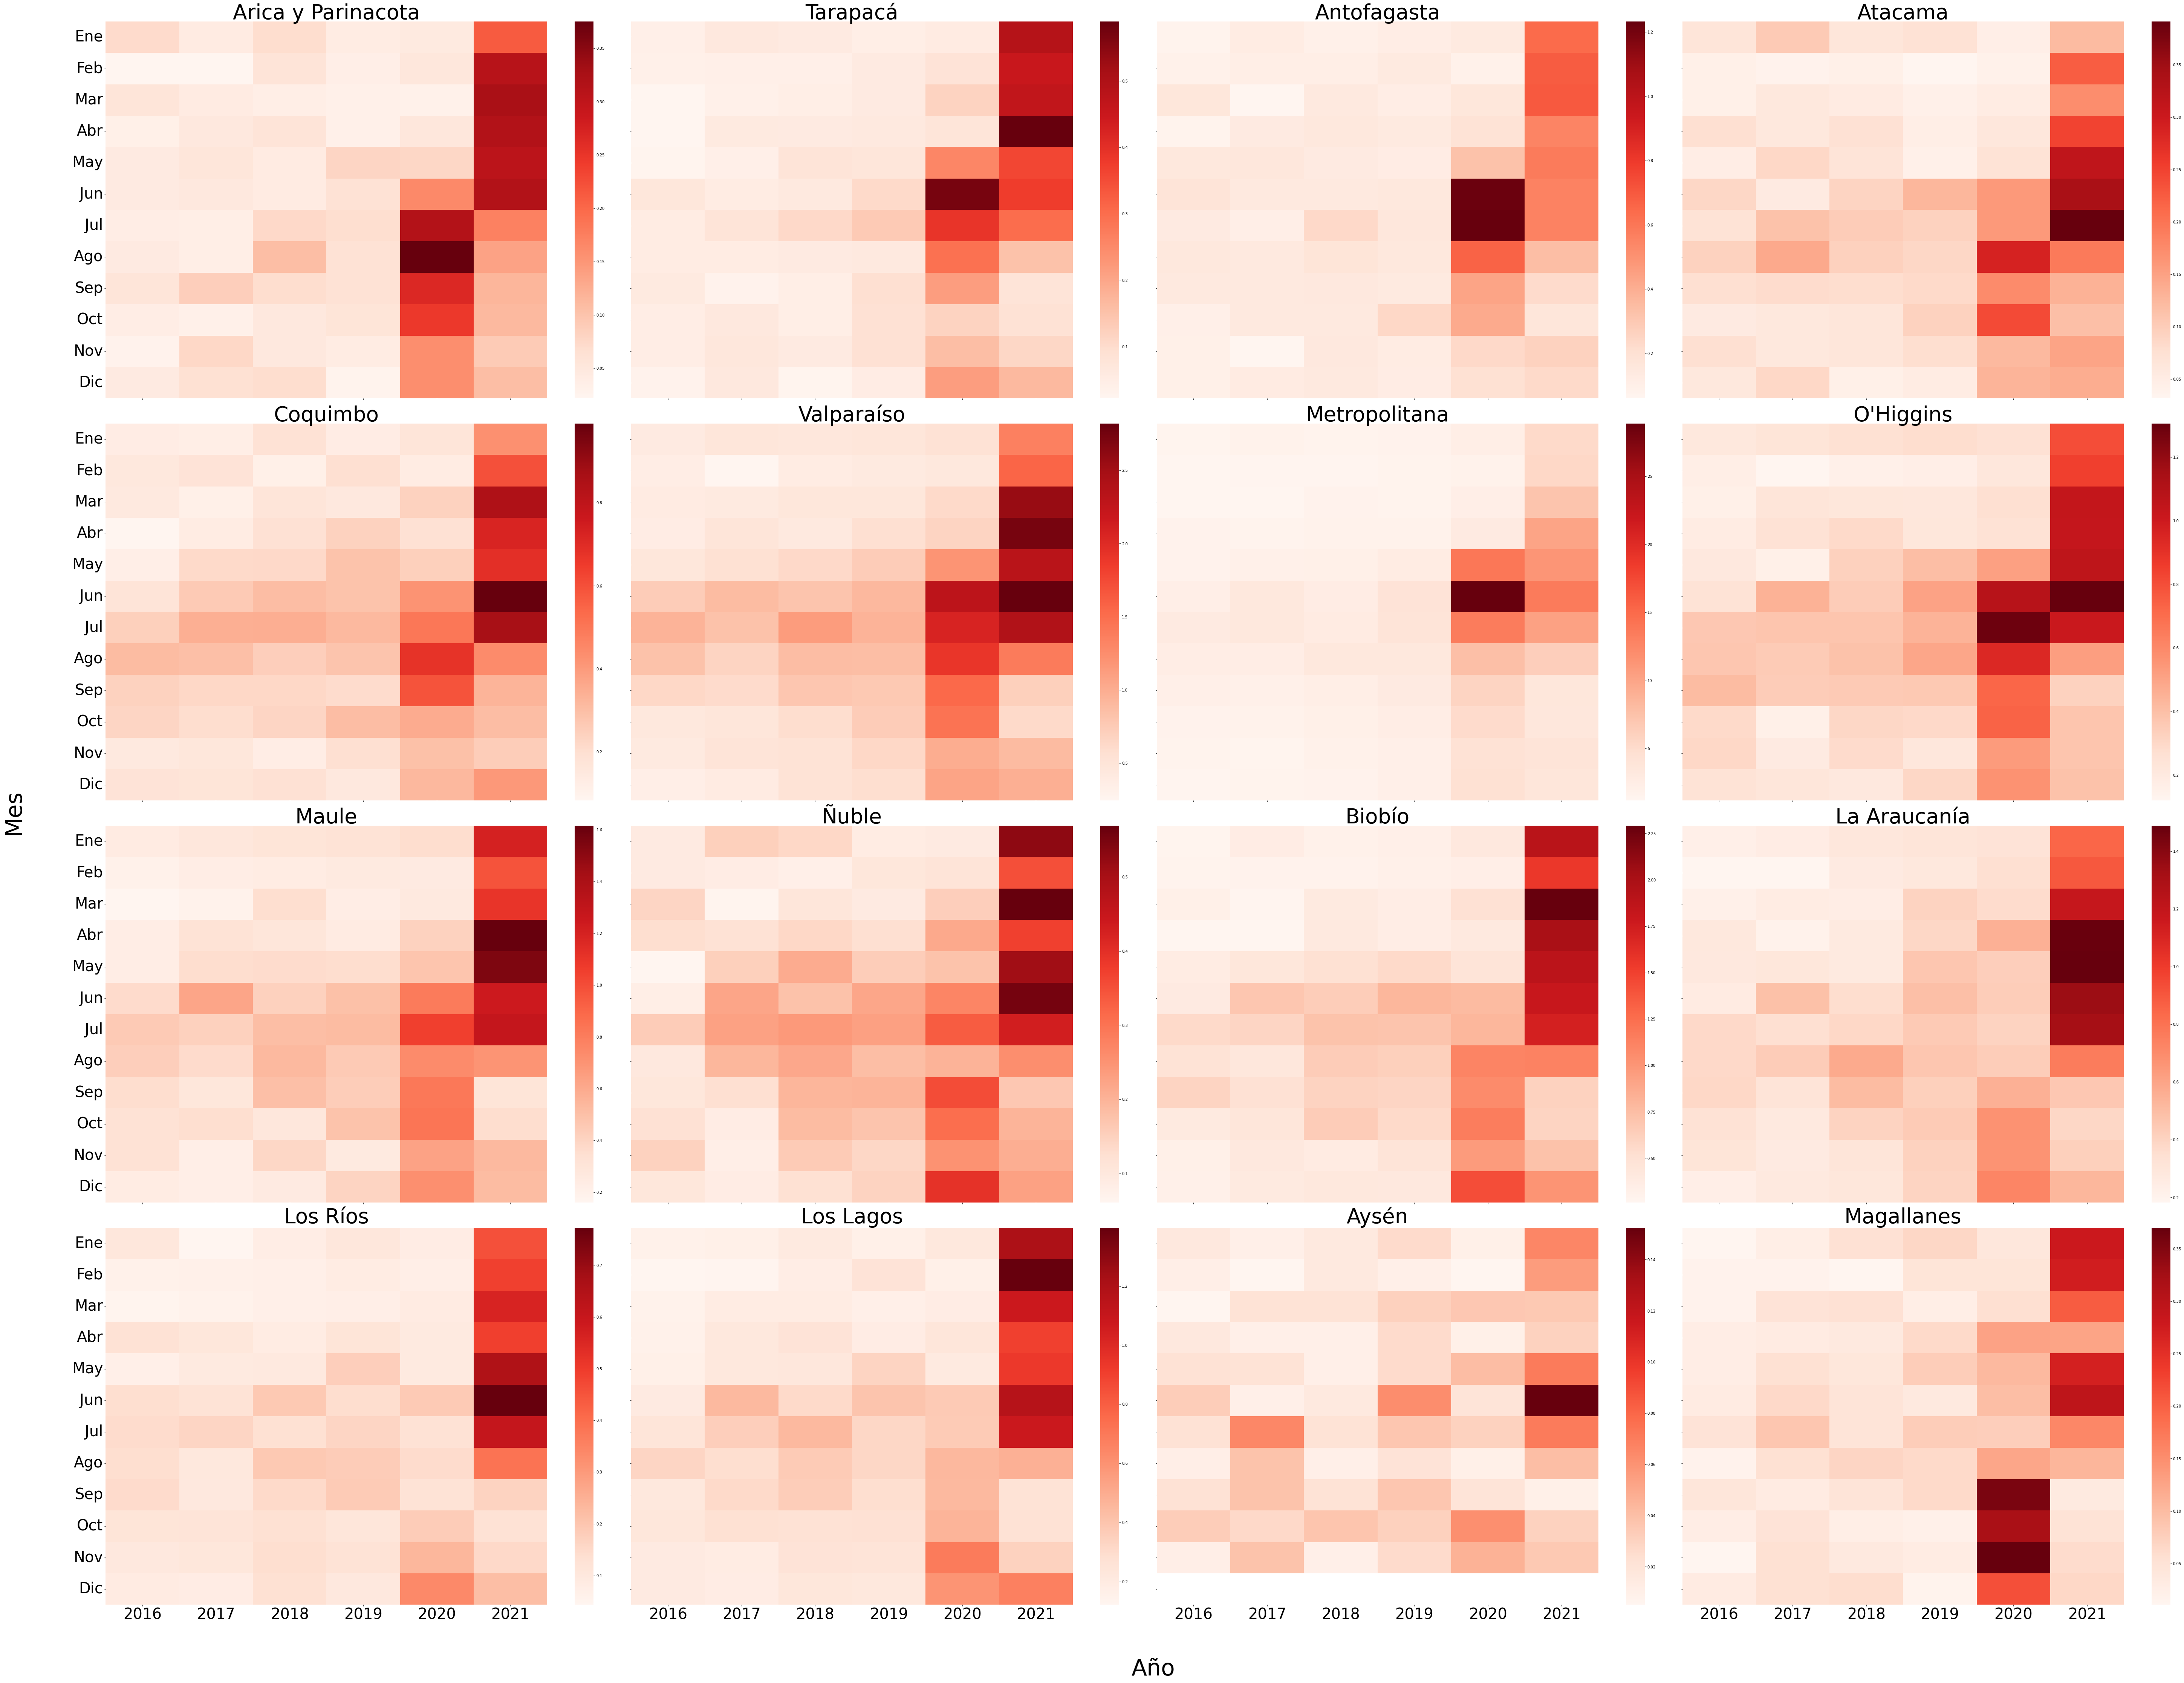

In [21]:
regiones = defunciones_mes_res_reg['region_o'].unique()
nregiones = len(regiones)
cols = 4
rows = int(nregiones/cols)

def plot_region_o(region_o, ax, df):
    data = (
        df[df['region_o'] == region_o]
            .drop(['region_o'], axis=1)
            .set_index('mes')
        )
    sns.heatmap(data, ax=ax, cmap='Reds', yticklabels=meses)
    ax.set_title(label_region[region_o-1], fontsize=55)
    ax.set_xlabel('',fontsize=1)
    ax.set_ylabel('',fontsize=1)
    ax.tick_params(labelsize=40,labelrotation=0)
    
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_res_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60)    
fig.tight_layout()

Respecto a las muertes causadas por enfermedades del sistema circulatorio, si bien a nivel nacional se observa una mayor tasa de mortalidad en los meses de invierno, esto no se replica en todas las regiones, sino solamente entre Coquimbo y La Araucanía. Por lo tanto, en las regiones del centro de Chile, se observa una mayor estacionalidad de esta causa de muerte.

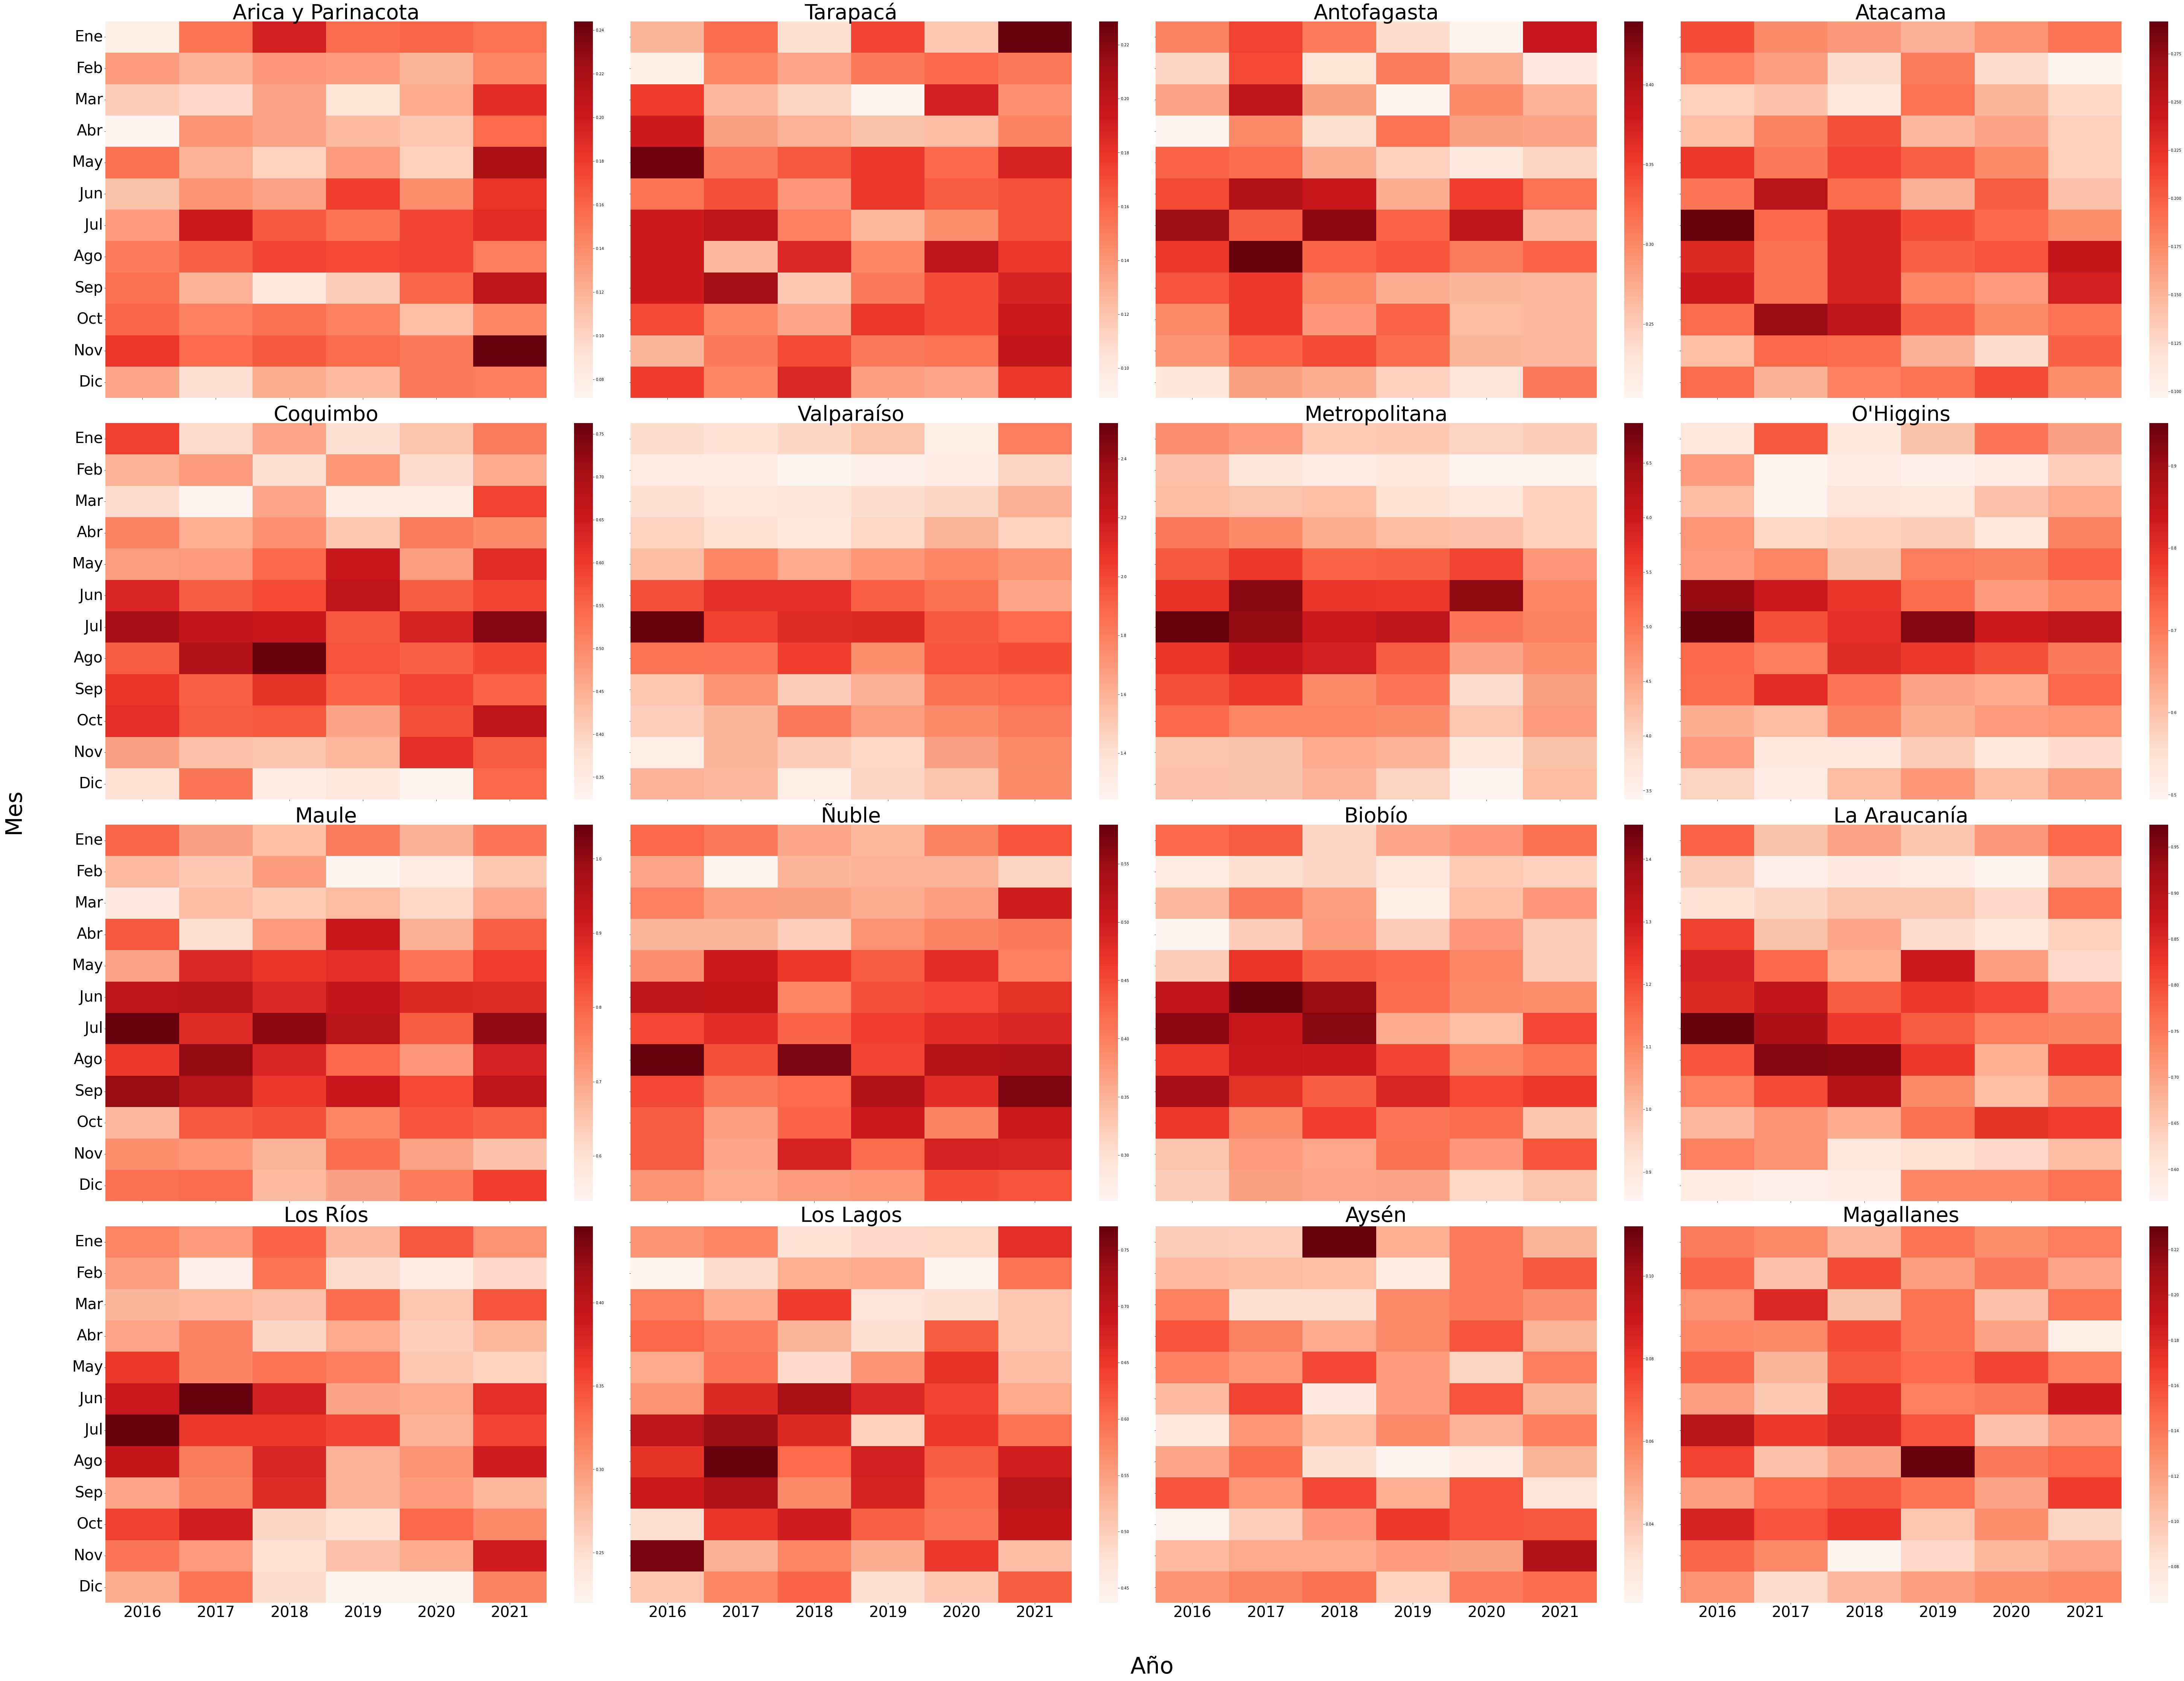

In [22]:
defunciones_mes_cir_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema circulatorio ']
defunciones_mes_cir_reg = defunciones_mes_cir_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_cir_reg = (defunciones_mes_cir_reg.groupby(by=['ANO_DEF','mes','region_o'])
                            .count()
                            .reset_index()
                           .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_cir_reg['tasa_def'] = defunciones_mes_cir_reg['FECHA_DEF']/defunciones_mes_cir_reg['pob']*100000
defunciones_mes_cir_reg = (defunciones_mes_cir_reg.pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum,fill_value=0))
defunciones_mes_cir_reg = defunciones_mes_cir_reg.reset_index()
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_cir_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60) 
fig.tight_layout()

En el caso de los tumores, la cual es una de las principales causas de muerte, se observa que en todas las regiones las tasas de mortalidad no presentan una clara estacionalidad. Es decir, las muertes por este motivo se distribuyen a lo largo del año.

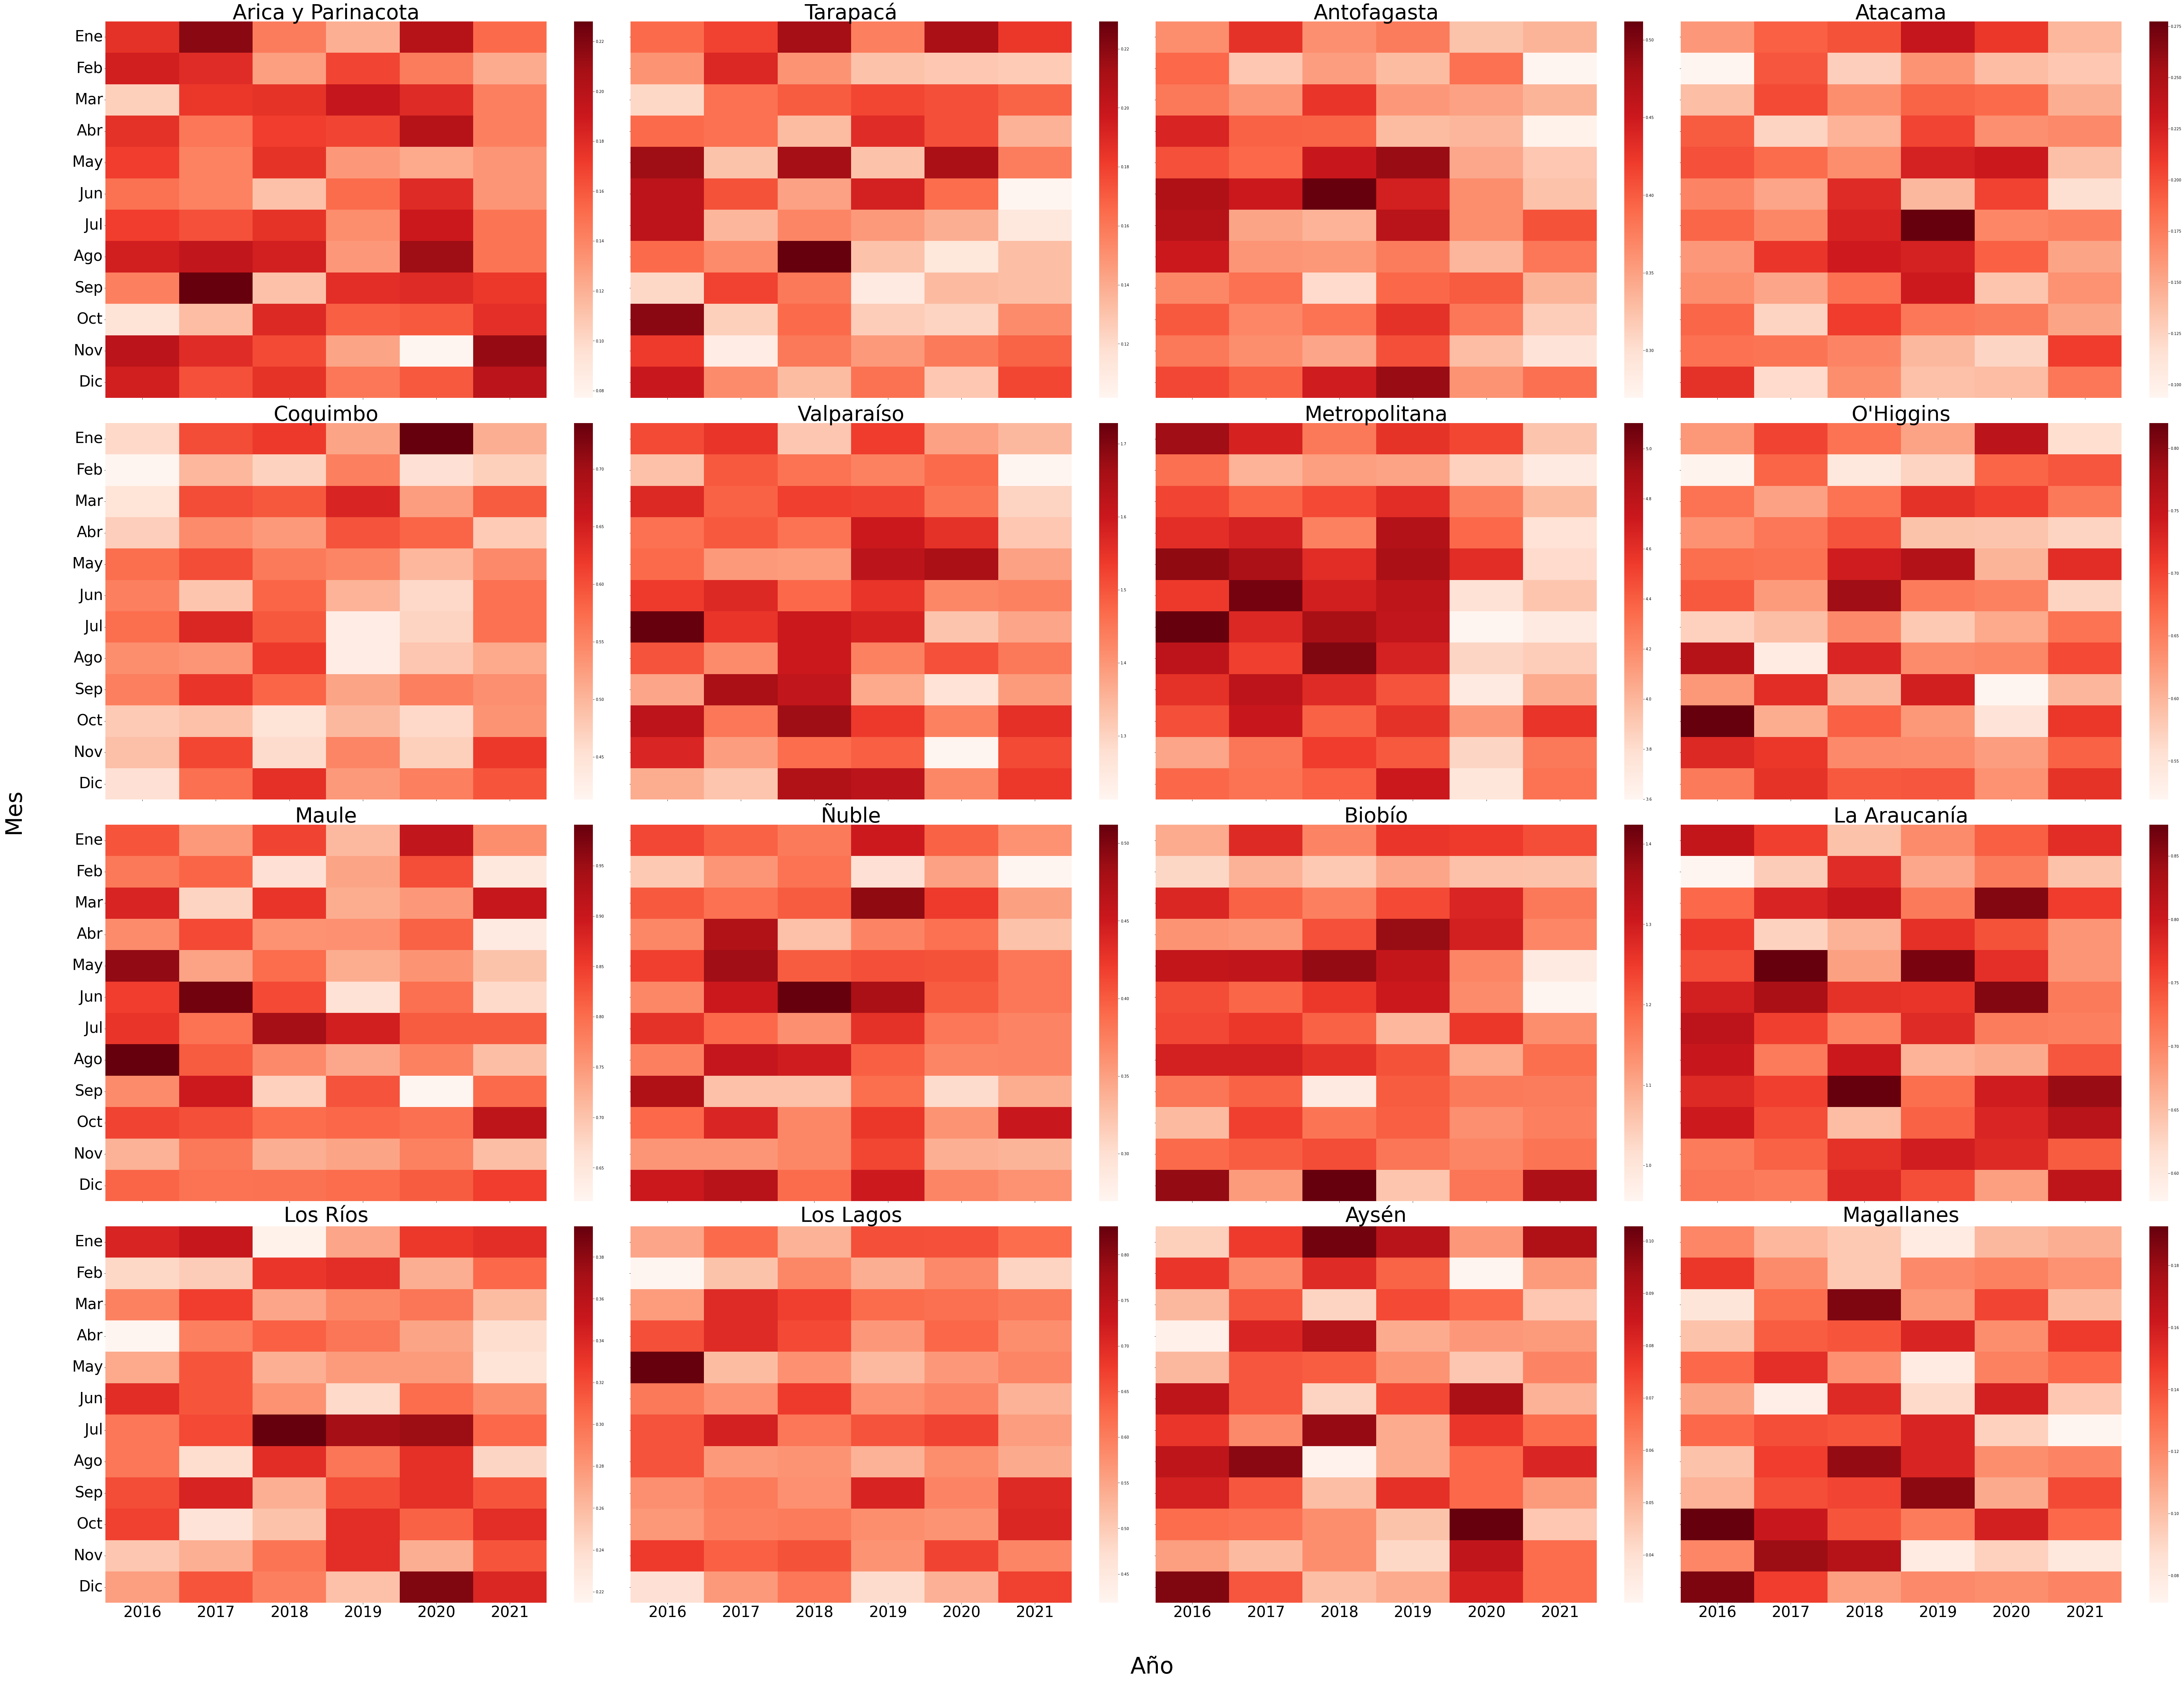

In [23]:
defunciones_mes_tum_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Tumores [Neoplasias]']
defunciones_mes_tum_reg = defunciones_mes_tum_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_tum_reg = (defunciones_mes_tum_reg.groupby(by=['ANO_DEF','mes','region_o'])
                            .count()
                            .reset_index()
                           .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_tum_reg['tasa_def'] = defunciones_mes_tum_reg['FECHA_DEF']/defunciones_mes_tum_reg['pob']*100000
defunciones_mes_tum_reg = (defunciones_mes_tum_reg.pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum,fill_value=0))
defunciones_mes_tum_reg = defunciones_mes_tum_reg.reset_index()
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_tum_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60) 
fig.tight_layout()

En relación a las muertes por enfermedades del sistema digestivo, tampoco se observa una estacionalidad. Sin embargo, es posible destacar que en las regiones de La Araucanía y Los Lagos hubo un aumento de fallecimientos por este motivo durante 2021.

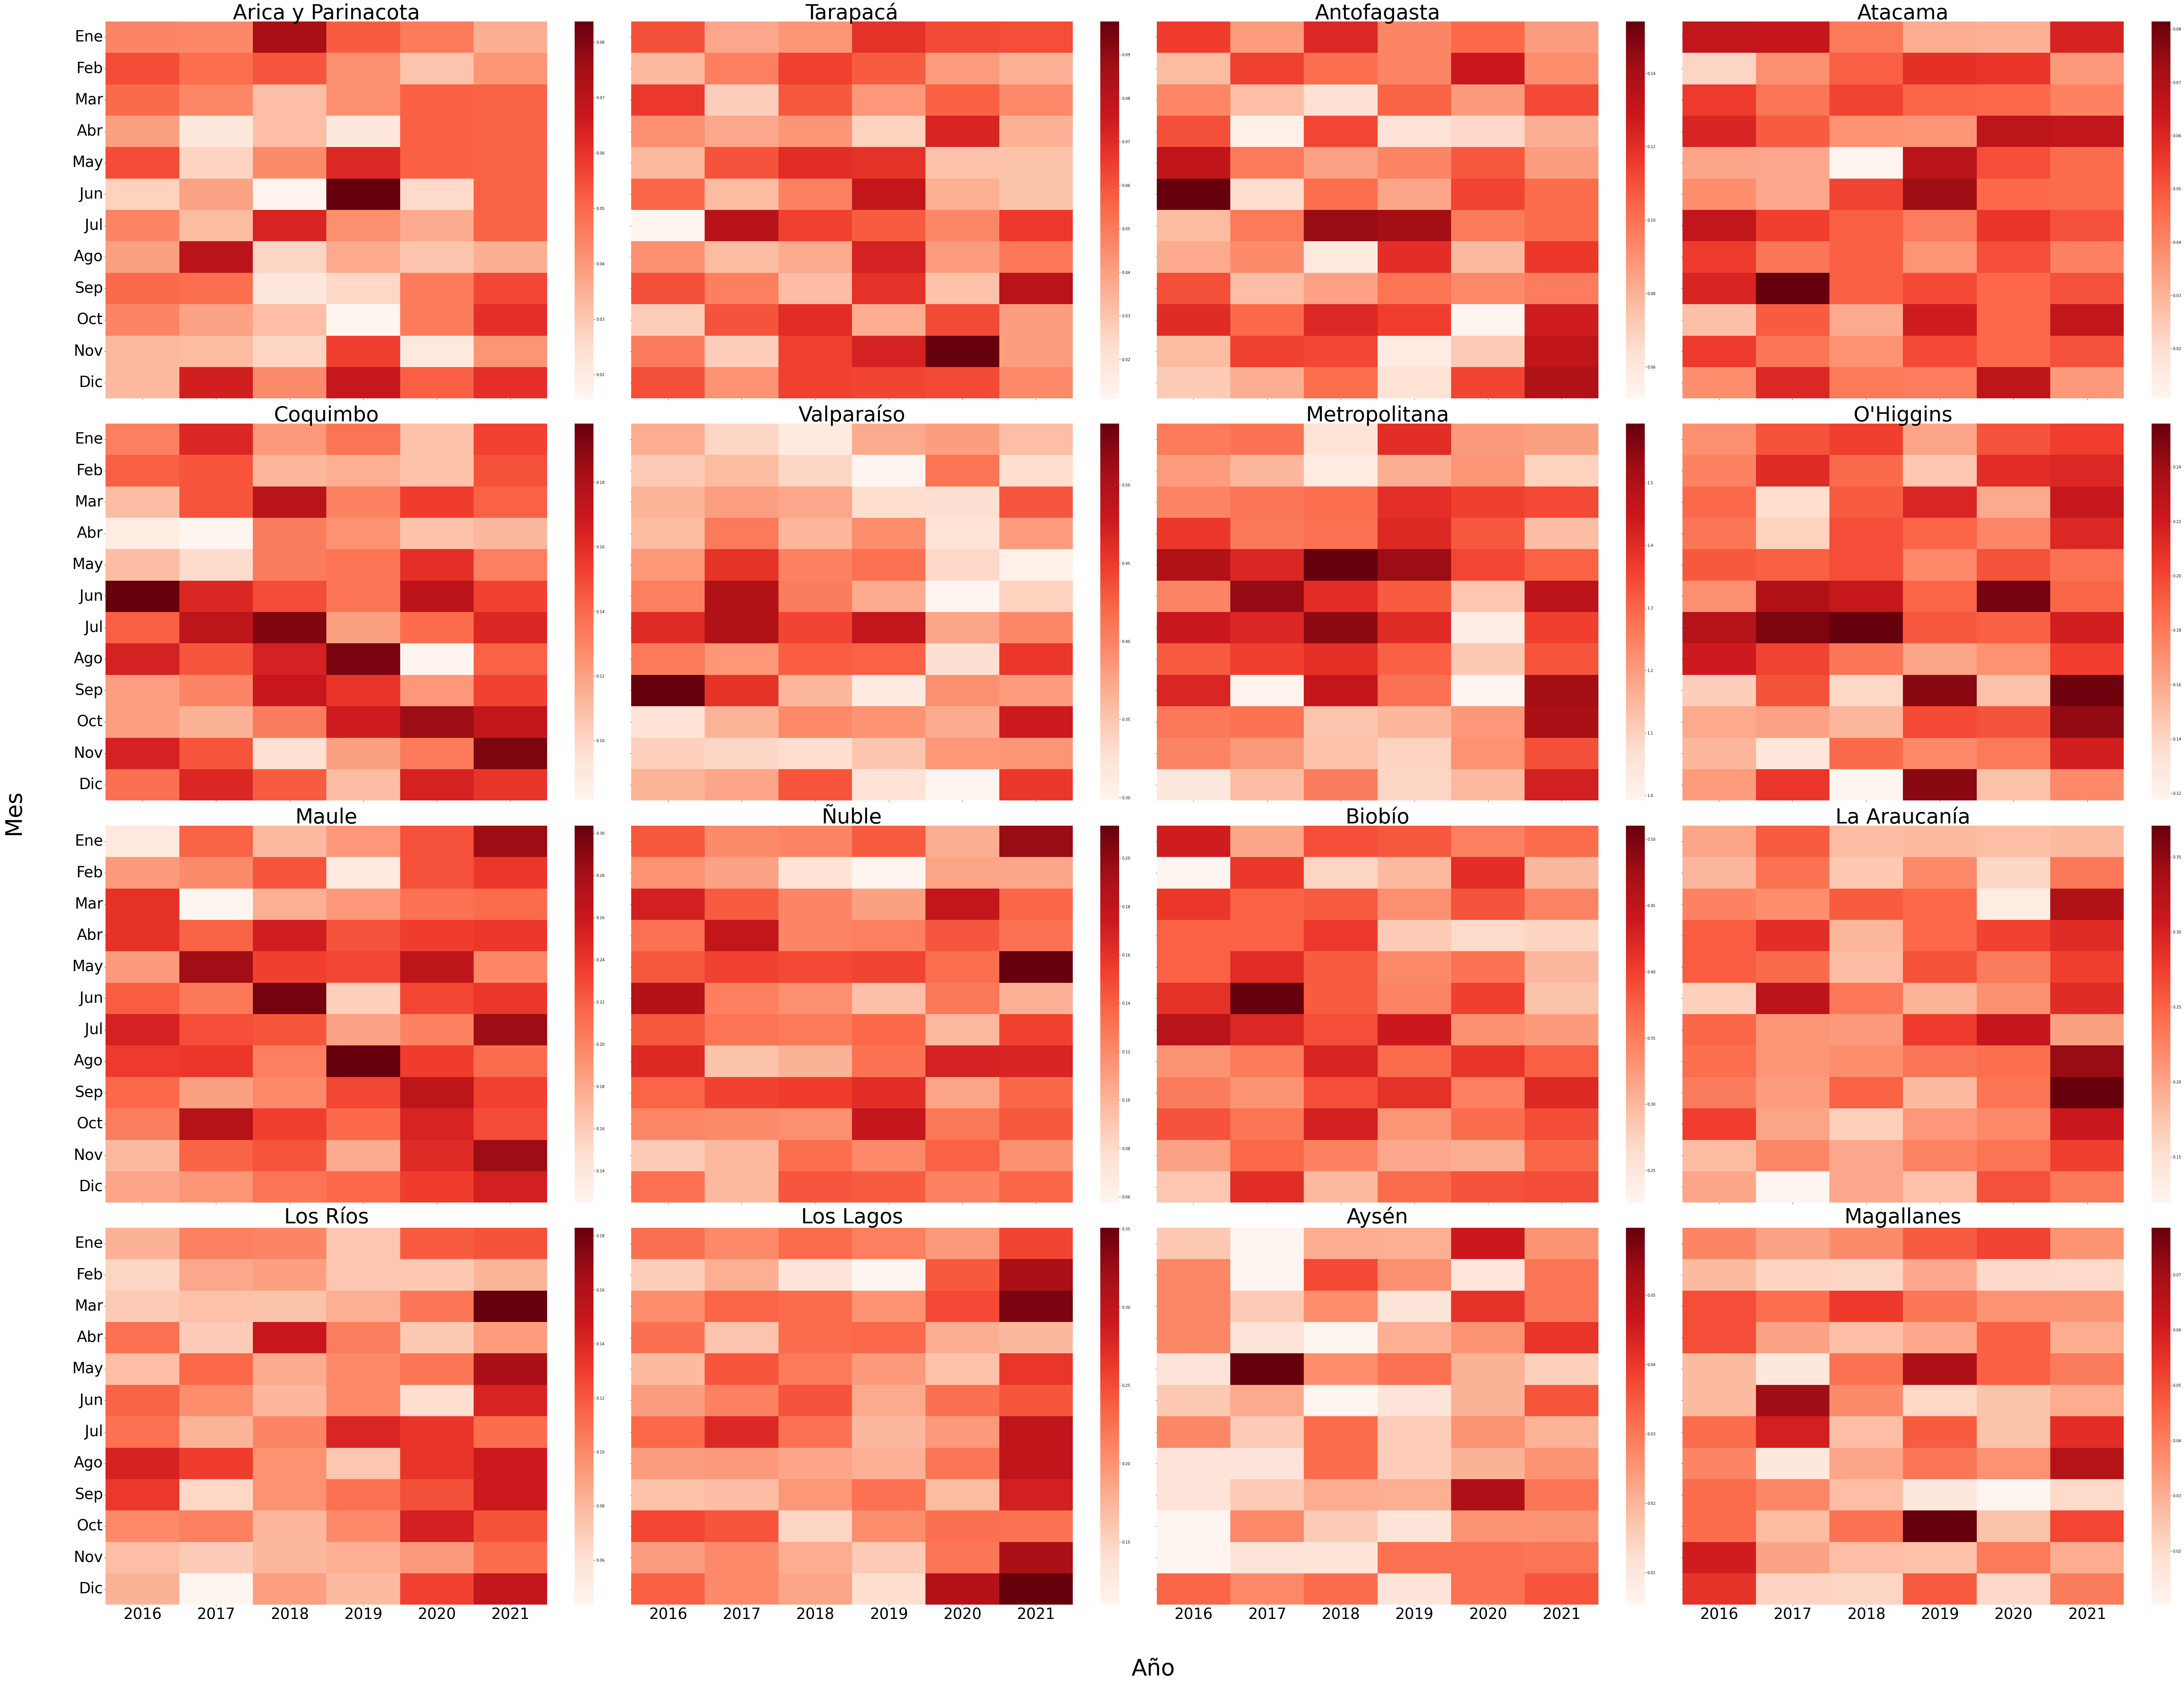

In [24]:
defunciones_mes_dig_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Enfermedades del sistema digestivo']
defunciones_mes_dig_reg = defunciones_mes_dig_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_dig_reg = (defunciones_mes_dig_reg.groupby(by=['ANO_DEF','mes','region_o'])
                            .count()
                            .reset_index()
                           .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_dig_reg['tasa_def'] = defunciones_mes_dig_reg['FECHA_DEF']/defunciones_mes_dig_reg['pob']*100000
defunciones_mes_dig_reg = (defunciones_mes_dig_reg.pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum,fill_value=0))
defunciones_mes_dig_reg = defunciones_mes_dig_reg.reset_index()
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_dig_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60) 
fig.tight_layout()

En cuanto a las muertes por traumatismos, solamente en la Región Metropolitana se observa una estacionalidad, con una mayor tasa de mortalidad en los meses de verano. Por lo tanto, la estacionalidad existente a nivel nacional se debe, principalmente, a las muertes ocurridas en la Región Metropolitana, donde se concentra aproximadamente un tercio de la población del país.

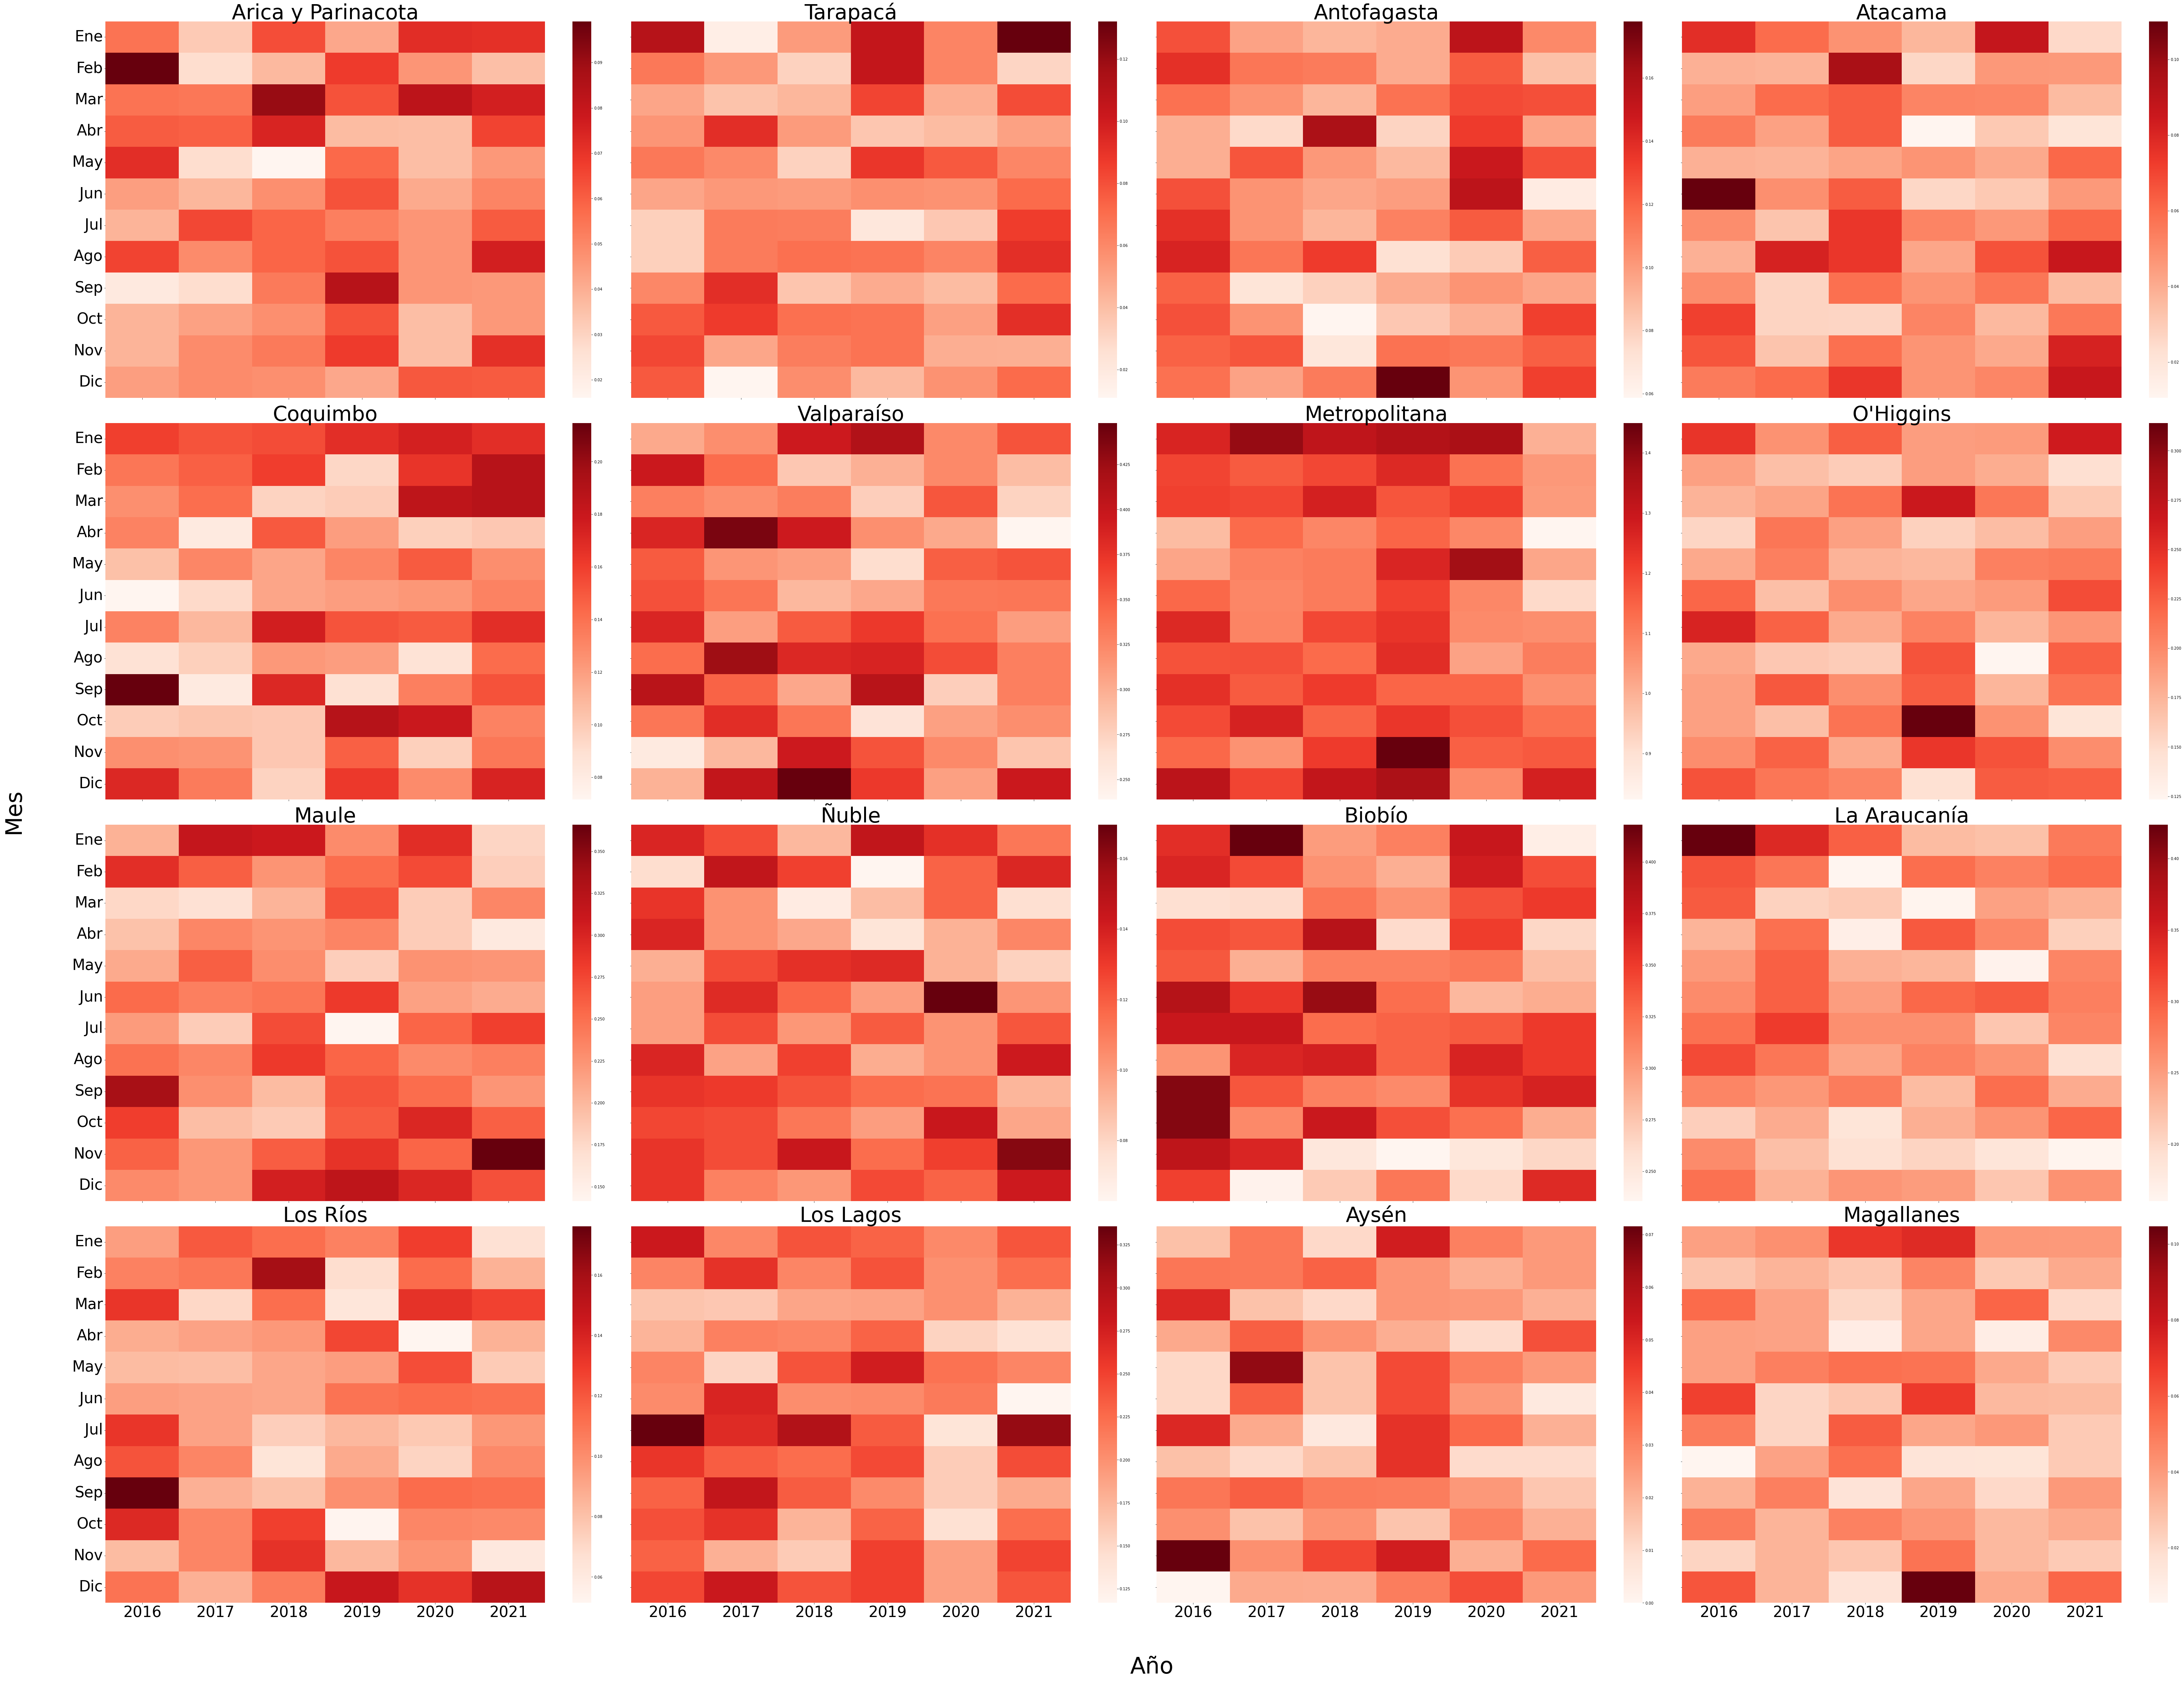

In [25]:
defunciones_mes_traum_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas']
defunciones_mes_traum_reg = defunciones_mes_traum_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_traum_reg = (defunciones_mes_traum_reg.groupby(by=['ANO_DEF','mes','region_o'])
                            .count()
                            .reset_index()
                           .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_traum_reg['tasa_def'] = defunciones_mes_traum_reg['FECHA_DEF']/defunciones_mes_traum_reg['pob']*100000
defunciones_mes_traum_reg = (defunciones_mes_traum_reg.pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum,fill_value=0))
defunciones_mes_traum_reg = defunciones_mes_traum_reg.reset_index()
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_traum_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60) 
fig.tight_layout()

En el caso de las muertes por enfermedades endocrinas, nutricionales y metabólicas, se observa una marcada disminución a partir de 2018. Esto mismo, aunque es menor medida, ocurre en las regiones de Valparaíso, O'Higgins, Maule, Ñuble, Biobío y La Araucanía. En cambio, en la Región de Magallanes, hubo un aumento a partir de 2021.

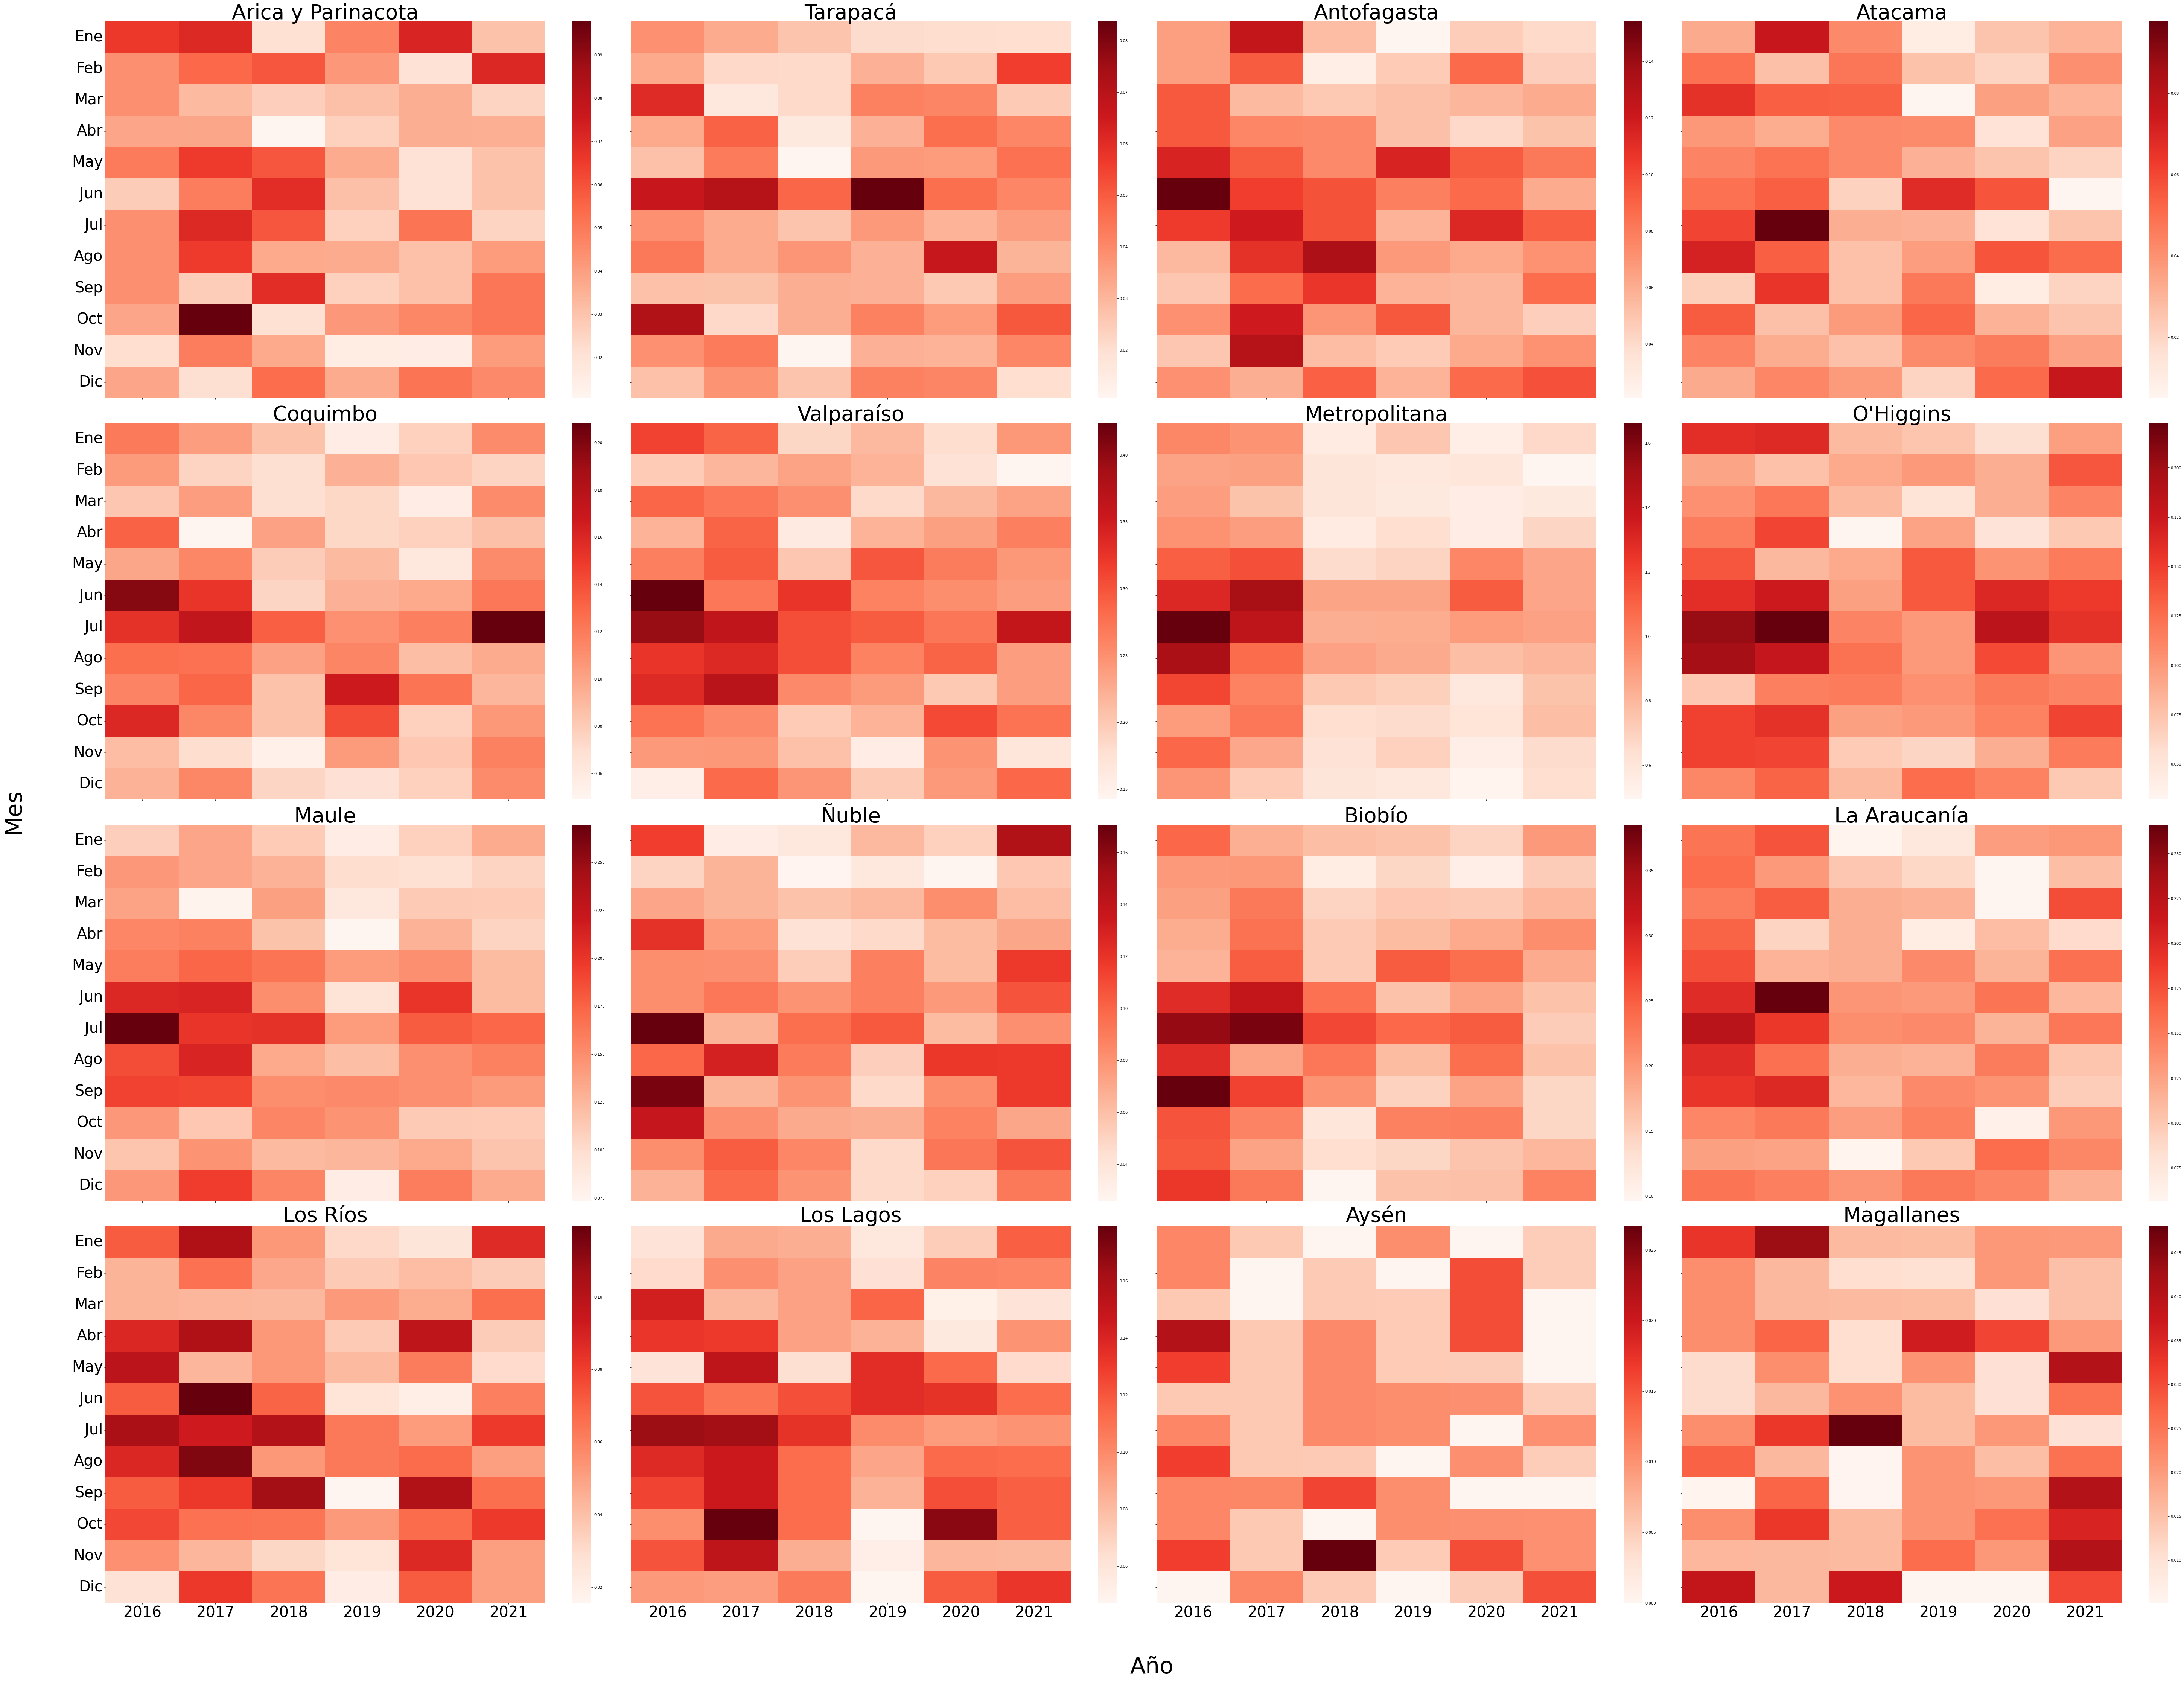

In [26]:

defunciones_mes_endoc_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Enfermedades endocrinas, nutricionales y metabólicas']
defunciones_mes_endoc_reg = defunciones_mes_endoc_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_endoc_reg = (defunciones_mes_endoc_reg.groupby(by=['ANO_DEF','mes','region_o'])
                            .count()
                            .reset_index()
                           .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_endoc_reg['tasa_def'] = defunciones_mes_endoc_reg['FECHA_DEF']/defunciones_mes_endoc_reg['pob']*100000
defunciones_mes_endoc_reg = (defunciones_mes_endoc_reg.pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum,fill_value=0))
defunciones_mes_endoc_reg = defunciones_mes_endoc_reg.reset_index()
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_endoc_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60) 
fig.tight_layout()

Respecto a 'síntomas, signos y hallazgos anormales clínicos y de laboratorio, no clasificados en otra parte', a nivel nacional se observaba un aumento importante durante el año 2021, lo cual se replica en las regiones Metropolitana, O'Higgins, Biobío, Los Lagos y Aysén. Este fenómeno podría deberse al denominado 'Covid largo', el cual podría presentar síntomas no estudiados previamente y que, por lo tanto, no sea posible clasificar de forma certera. 

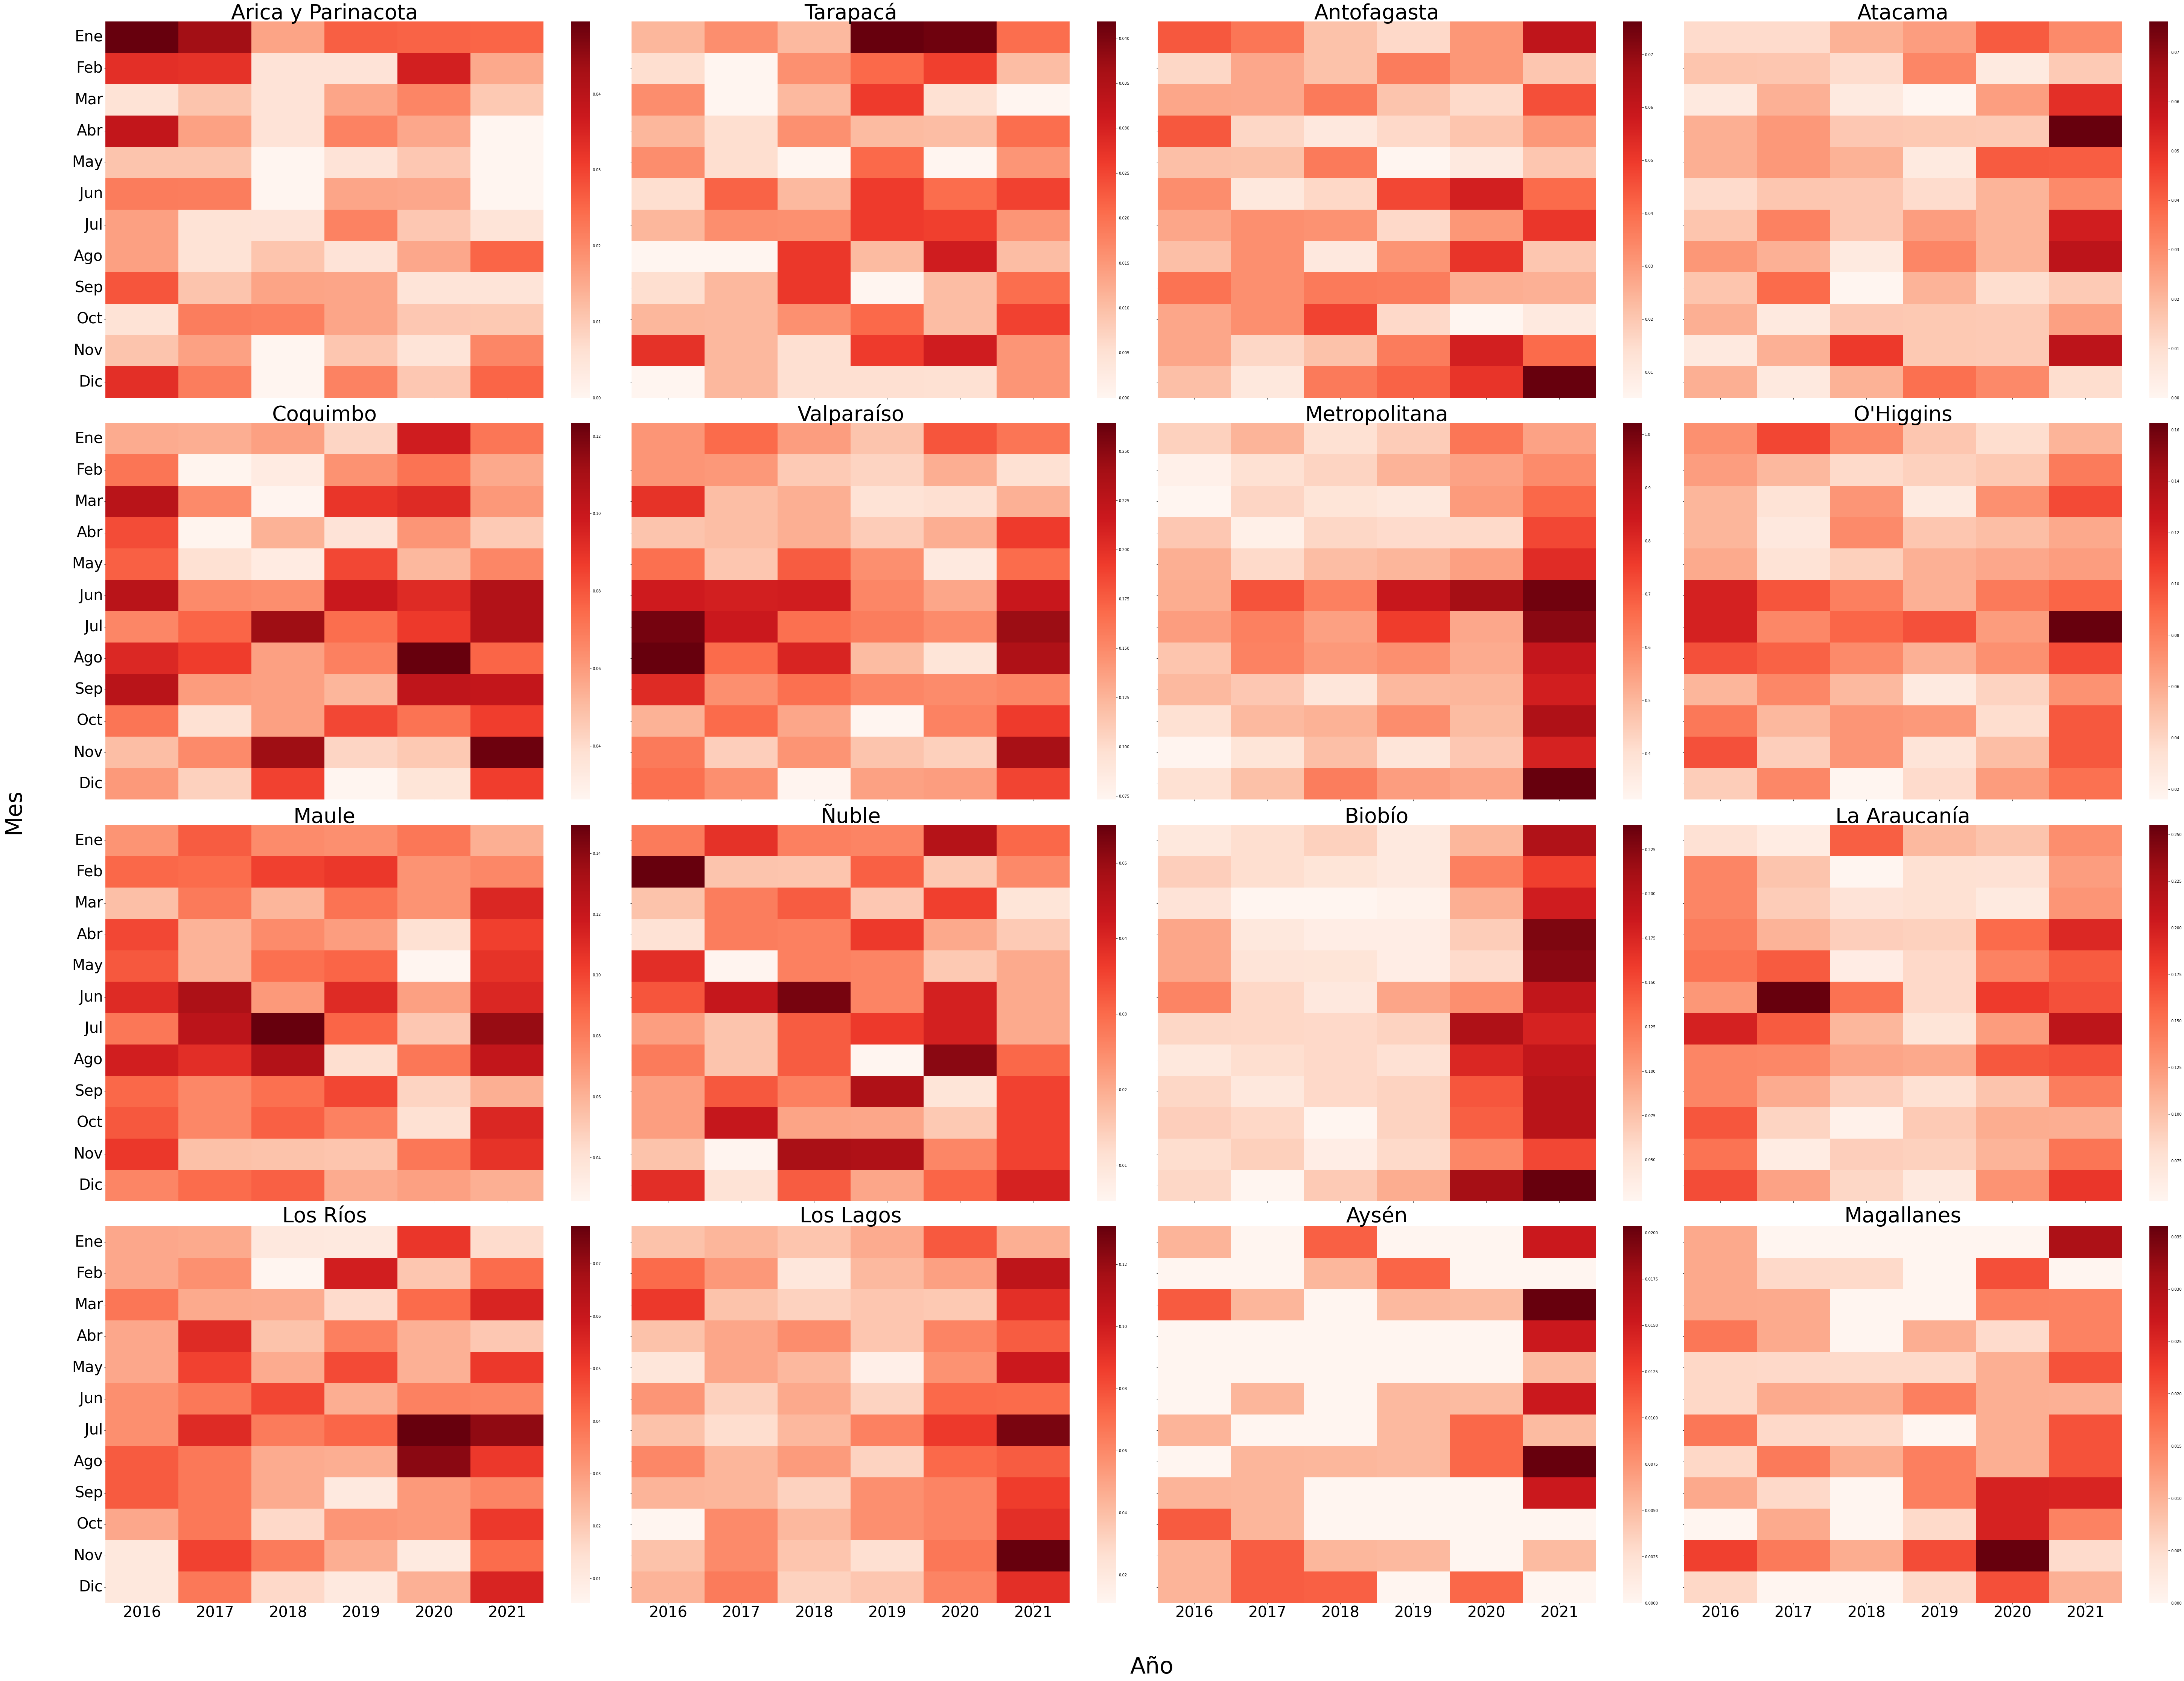

In [27]:
defunciones_mes_otros_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Síntomas, signos y hallazgos anormales clínicos y de laboratorio, no clasificados en otra parte']
defunciones_mes_otros_reg = defunciones_mes_otros_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_otros_reg = (defunciones_mes_otros_reg.groupby(by=['ANO_DEF','mes','region_o'])
                            .count()
                            .reset_index()
                           .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_otros_reg['tasa_def'] = defunciones_mes_otros_reg['FECHA_DEF']/defunciones_mes_otros_reg['pob']*100000
defunciones_mes_otros_reg = (defunciones_mes_otros_reg.pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum,fill_value=0))
defunciones_mes_otros_reg = defunciones_mes_otros_reg.reset_index()
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_otros_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60) 
fig.tight_layout()

En relación con las muertes causadas por 'trastornos mentales y del comportamiento', en algunas regiones como Valparaíso, Metropolitana, Maule, La Araucanía y Los Lagos, se observa una mayor tasa de mortalidad durante los meses de invierno. Asimismo, en La Araucanía y Los Lagos hay un aumento de estas muertes durante los últimos dos años.

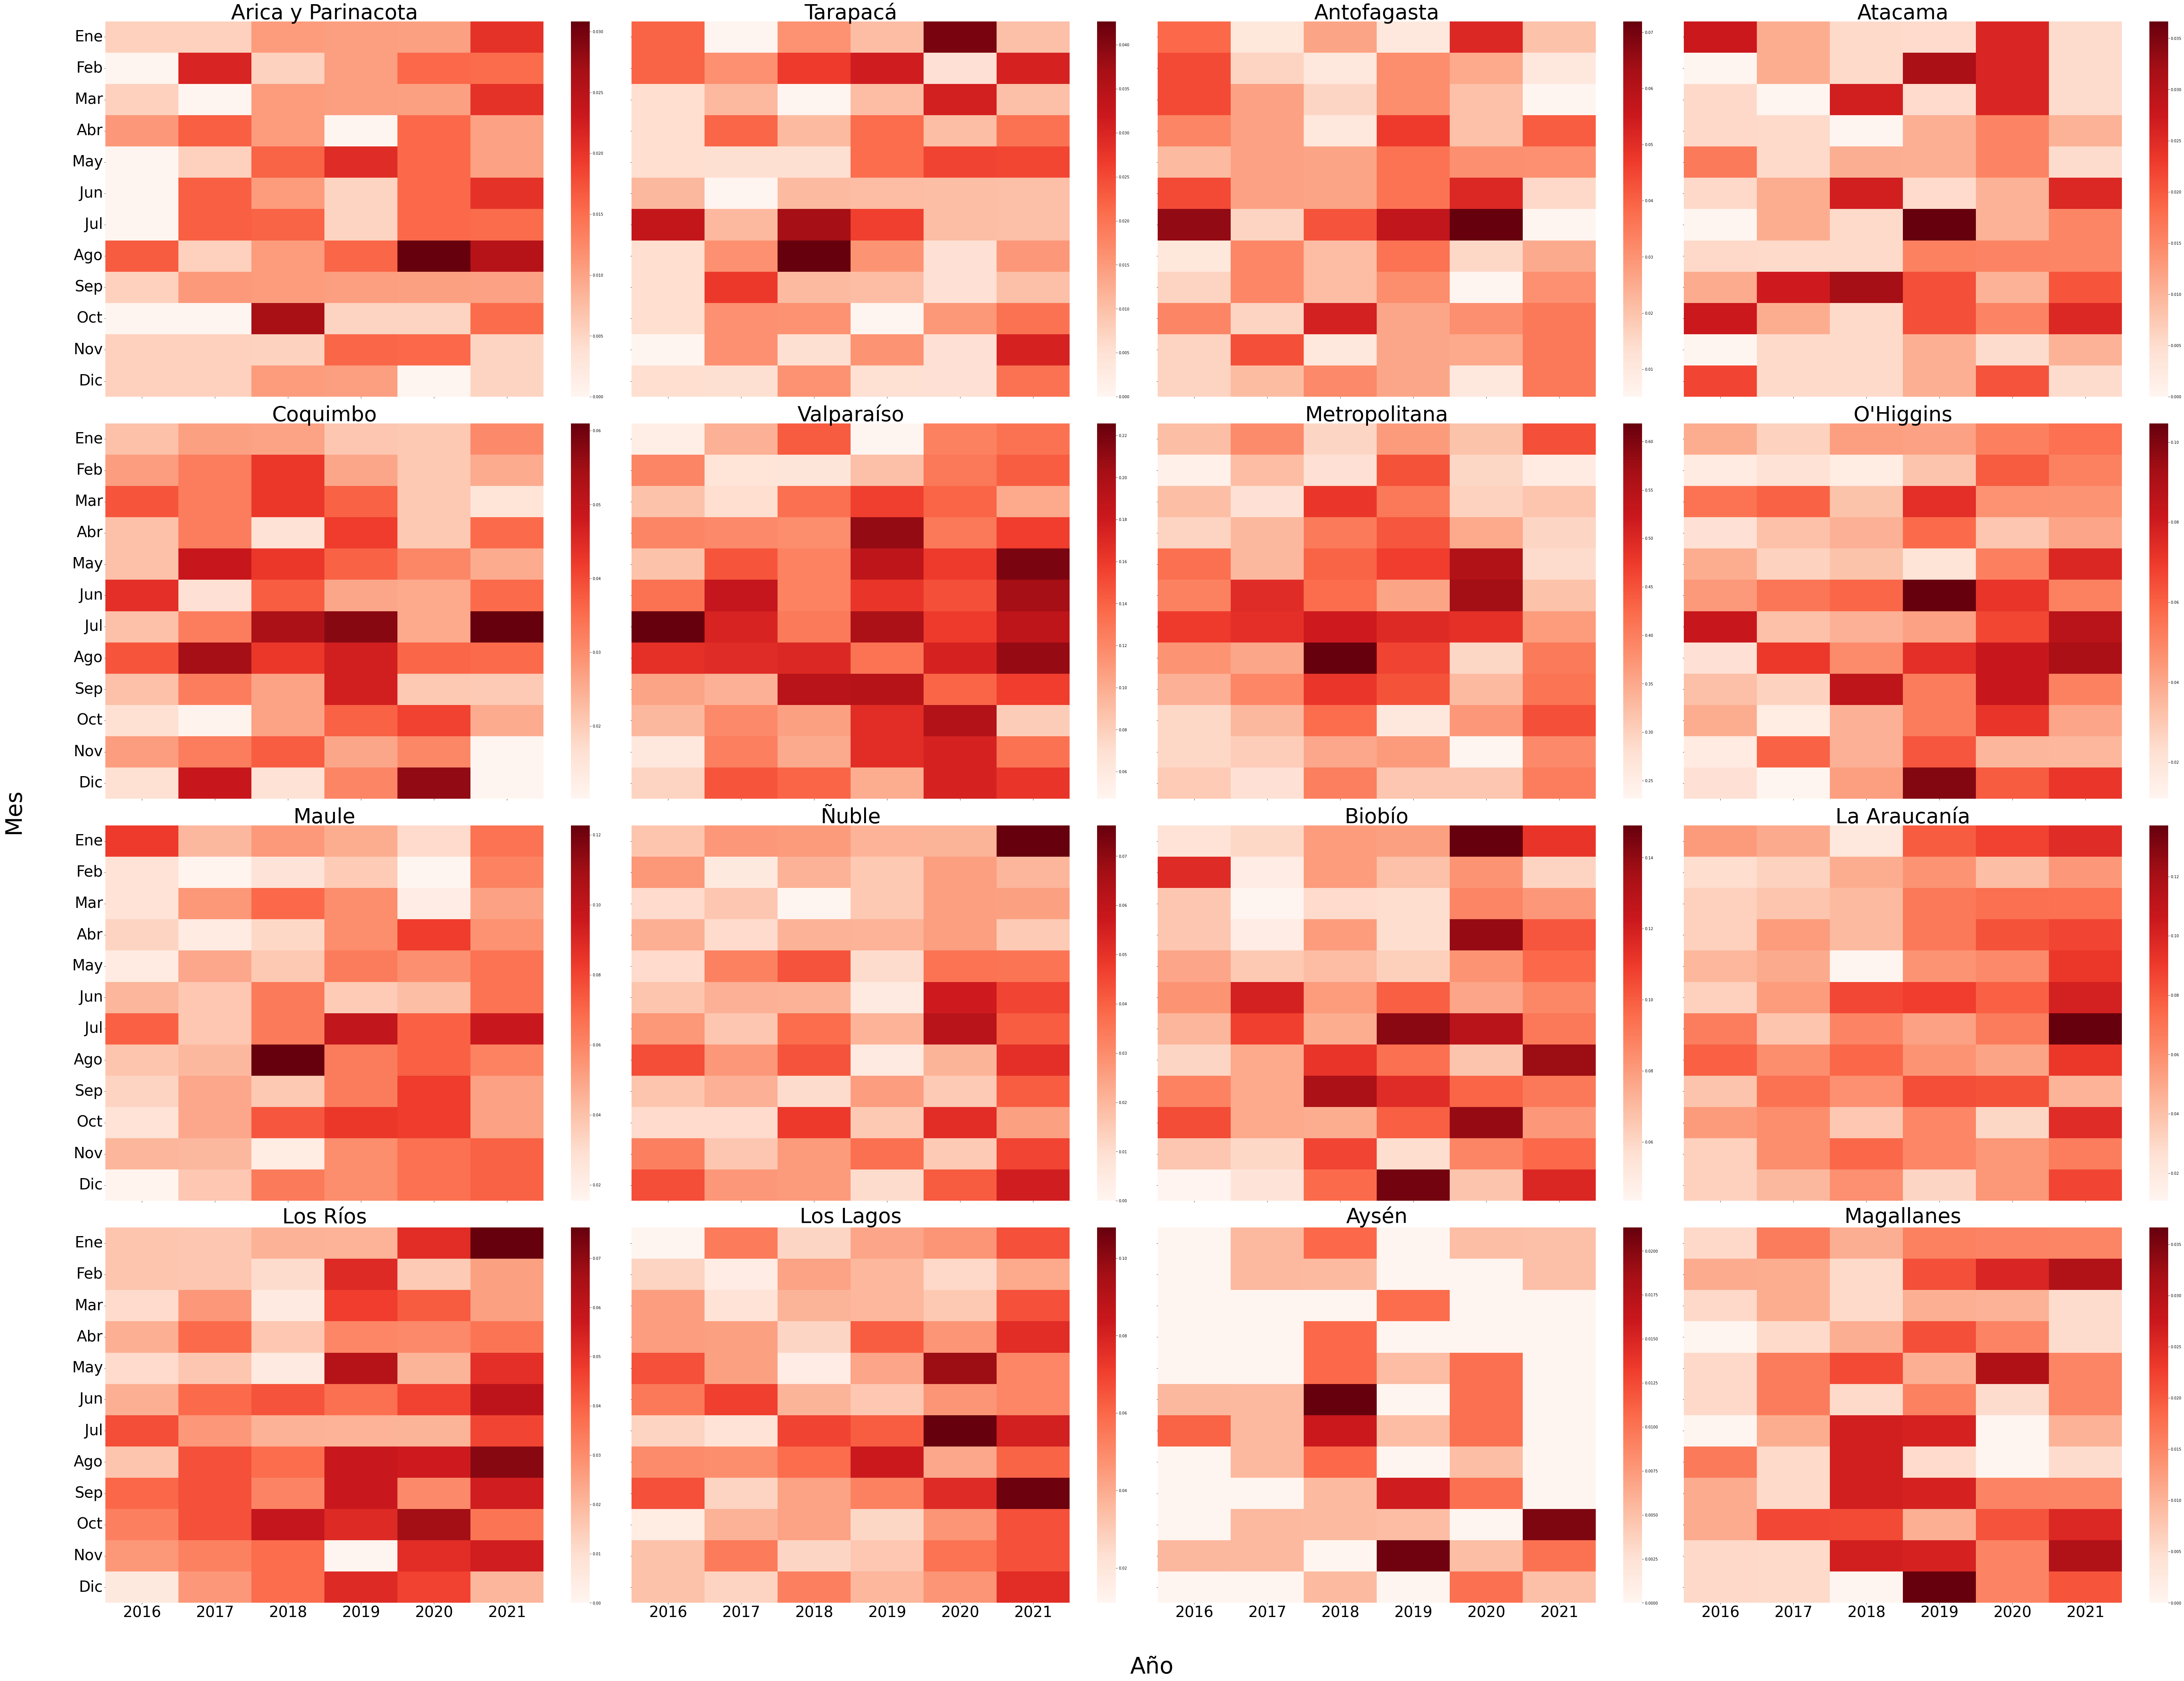

In [28]:
defunciones_mes_mental_reg = defunciones_mes[defunciones_mes['GLOSA_CAPITULO_DIAG1']=='Trastornos mentales y del comportamiento']
defunciones_mes_mental_reg = defunciones_mes_mental_reg[['ANO_DEF','mes','region_o','FECHA_DEF']]
defunciones_mes_mental_reg = (defunciones_mes_mental_reg.groupby(by=['ANO_DEF','mes','region_o'])
                            .count()
                            .reset_index()
                           .merge(proy_pob_nac,how='left',right_on=['anio'],left_on='ANO_DEF'))
defunciones_mes_mental_reg['tasa_def'] = defunciones_mes_mental_reg['FECHA_DEF']/defunciones_mes_mental_reg['pob']*100000
defunciones_mes_mental_reg = (defunciones_mes_mental_reg.pivot_table(values='tasa_def',index=["mes",'region_o'], columns = "ANO_DEF",aggfunc=sum,fill_value=0))
defunciones_mes_mental_reg = defunciones_mes_mental_reg.reset_index()
fig, ax = plt.subplots(rows, cols, figsize=(80,60), sharex=True,sharey=True)

for idx_region_o, region_o in enumerate(regiones):
    row = int(idx_region_o / cols)
    col = idx_region_o % cols
    plot_region_o(region_o, ax[row][col],defunciones_mes_mental_reg)
fig.text(0.5, -0.03, 'Año', ha='center',fontsize=60)
fig.text(-0.03, 0.5, 'Mes', va='center', rotation='vertical',fontsize=60) 
fig.tight_layout()

Para el resto de las causas de muerte, no se observaron patrones interesantes, lo cual podría deberse a que tienen una menor prevalencia, de modo que no es posible presentar una visualización tan desagregada. 

## Diferencias de género en las causas de muerte
Dado que la esperanza de vida es mayor en mujeres que en los hombres, llegando a 81,8 y 76,7 años, respectivamente (INE, *s.f.*), es interesante analizar las diferencias en las causas de muerte, ya que podrían explicar por qué se produce esta brecha.

In [29]:
tasa_def_gen_2016 = tasa_def_gen[tasa_def_gen['anio']==2016]
tasa_def_gen_2016 = tasa_def_gen_2016[tasa_def_gen_2016['causa']!='Enfermedades del oído y de la apófisis mastoides']
tasa_def_gen_2016 = tasa_def_gen_2016[tasa_def_gen_2016['causa']!='Enfermedades del ojo y sus anexos ']
tab7 = (tasa_def_gen_2016
        .pivot_table("tasa_def_gen",index=["causa"], columns = "sexo",aggfunc=sum))
tab7['delta'] = tab7["Hombre"] / tab7["Mujer"] - 1
tab7 = tab7.sort_values('delta').dropna()

Tal como se observa en el siguiente gráfico, en el año 2016, la principal diferencia en tasa de mortalidad entre hombres y mujeres se da en las muertes por traumatismos, envenenamientos y otras consecuencias de causas externas, donde los hombres presentan una mortalidad 217% mayor. Desde la perspectiva de género, este fenómeno ha sido estudiado en las ciencias sociales y epidemiología, relacionándose a las distintas conductas que adquieren hombres y mujeres durante el proceso de socialización. En este sentido, predomina todavía un vínculo entre la masculinidad y la violencia, en el sentido de que existe una presión social en los hombres que los lleva a adquirir actitudes más violentas y riesgosas, para así demostrar su virilidad. De este modo, los hombres se ven más involucrados en peleas y accidentes de tránsito. Asimismo, los mandatos sociales impiden que los hombres expresen sus emociones y/o soliciten ayuda en situaciones difíciles, de modo que tienen una mayor tasa de suicidio. Todo lo anterior, lleva a una mayor cantidad de muertes tempranas y, por lo tanto, menor esperanza de vida en hombres (Rodríguez, 2015).

Por otro lado, en las mujeres hay una mayor cantidad de muertes debido a causas asociadas al deterioro de la edad, lo cual se explica por el hecho de que viven más y, por ende, tienen más tiempo para desarrollar estas patologías. Asimismo, respecto a la enfermedades del sistema respiratorio, cabe destacar que no existe una brecha en la mortalidad entre hombres y mujeres.

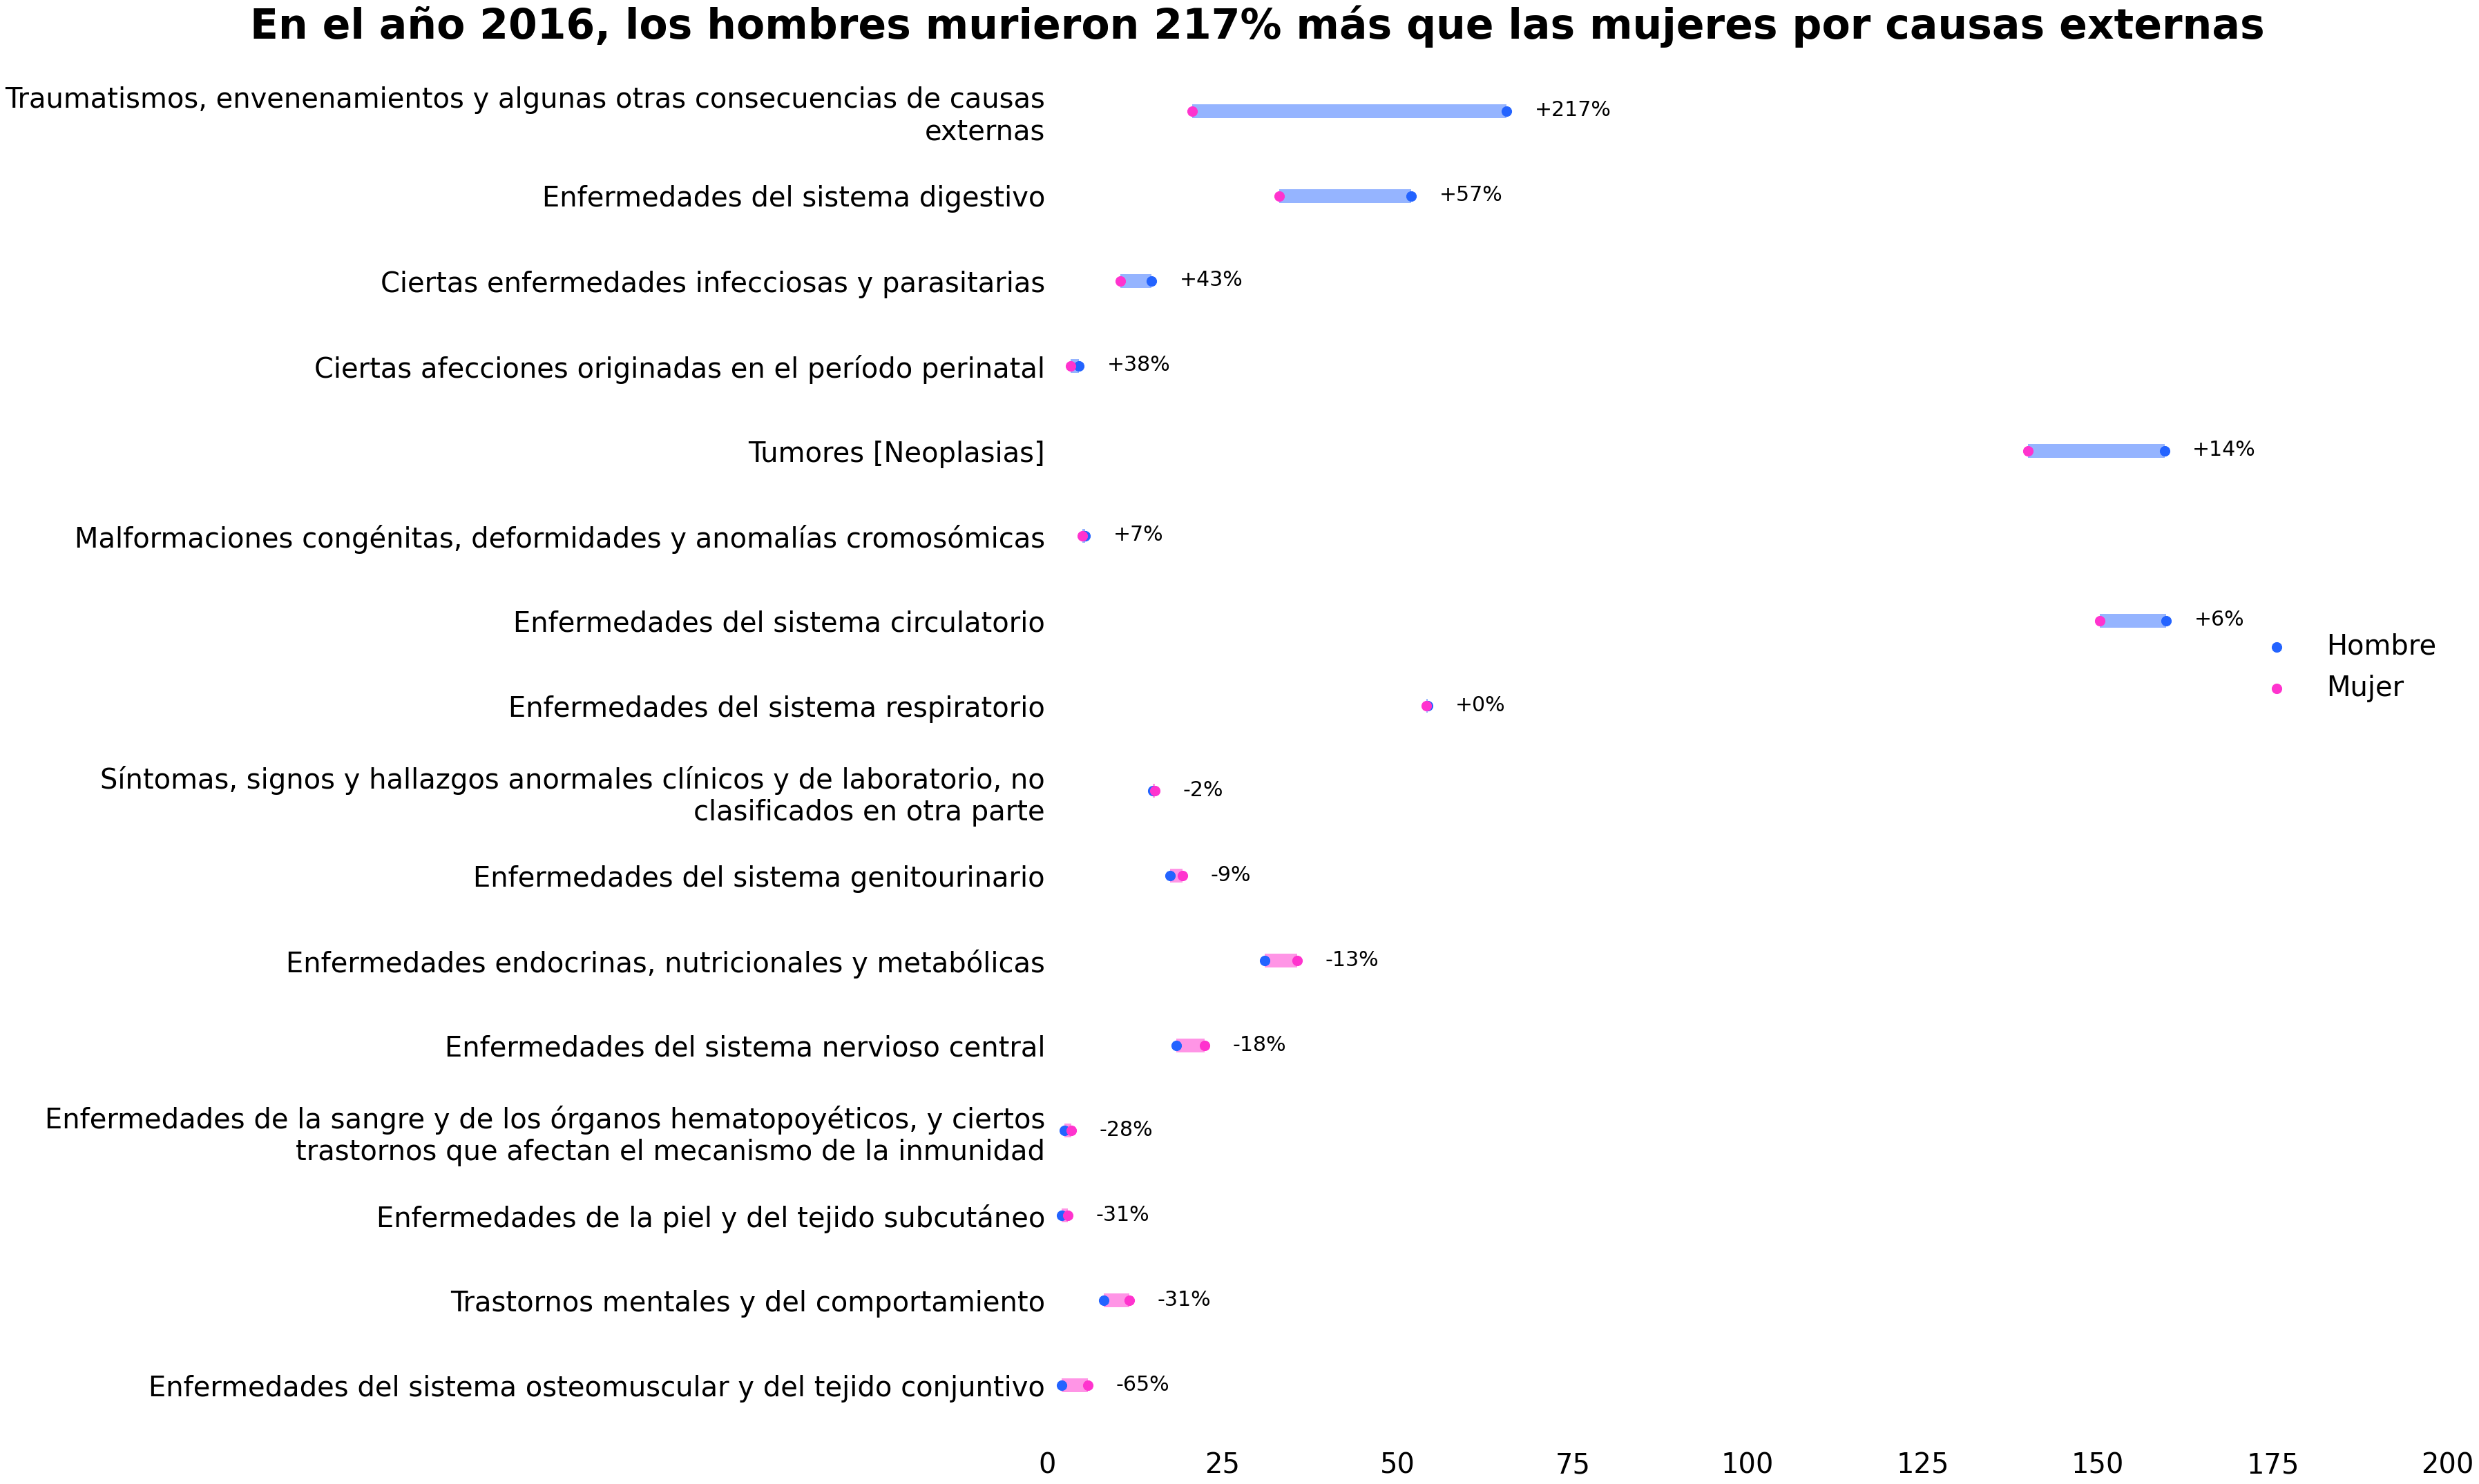

In [30]:

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab7.index) + 1)
colors = np.where(tab7['Mujer'] > tab7['Hombre'], '#FF95E6', '#95B4FF')

plt.hlines(y=y_range, xmin=tab7['Hombre'], xmax=tab7['Mujer'],
           color=colors, lw=20)
plt.scatter(tab7['Hombre'], y_range, color='#2363FF', s=200, label='Hombre', zorder=3)
plt.scatter(tab7['Mujer'], y_range, color='#FF33CE', s=200 , label='Mujer', zorder=3)

plt.yticks(y_range, [ '\n'.join(textwrap.wrap(l, 70)) for l in tab7.index ],fontsize=40)
plt.xticks(fontsize=40)
plt.title("En el año 2016, los hombres murieron 217% más que las mujeres por causas externas", 
          fontsize=60,position= (.15,0),weight='bold')
plt.xlim(0, 200)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab7.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["Hombre"], row["Mujer"]) +4 , y - 0.06), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.4, -0.15, 0.2), loc='upper center', frameon=False, prop={'size': 40})
ax.tick_params(axis=u'both', which=u'both', length=0)
hide_border(ax)
plt.show()

En los siguientes gráficos, se observa que para los años 2017, 2018 y 2019, la mayor brecha entre hombres y mujeres sigue estando en la tasa mortalidad por traumatismos, envenamientos y otras causas externas, la cual bordea el 200%. Asimismo, las mujeres mueren más por causas asociadas al deterioro por la edad, mientras que donde se observan menos diferencias es en las muertes ocasionadas por enfermedades del sistema respiratorio.

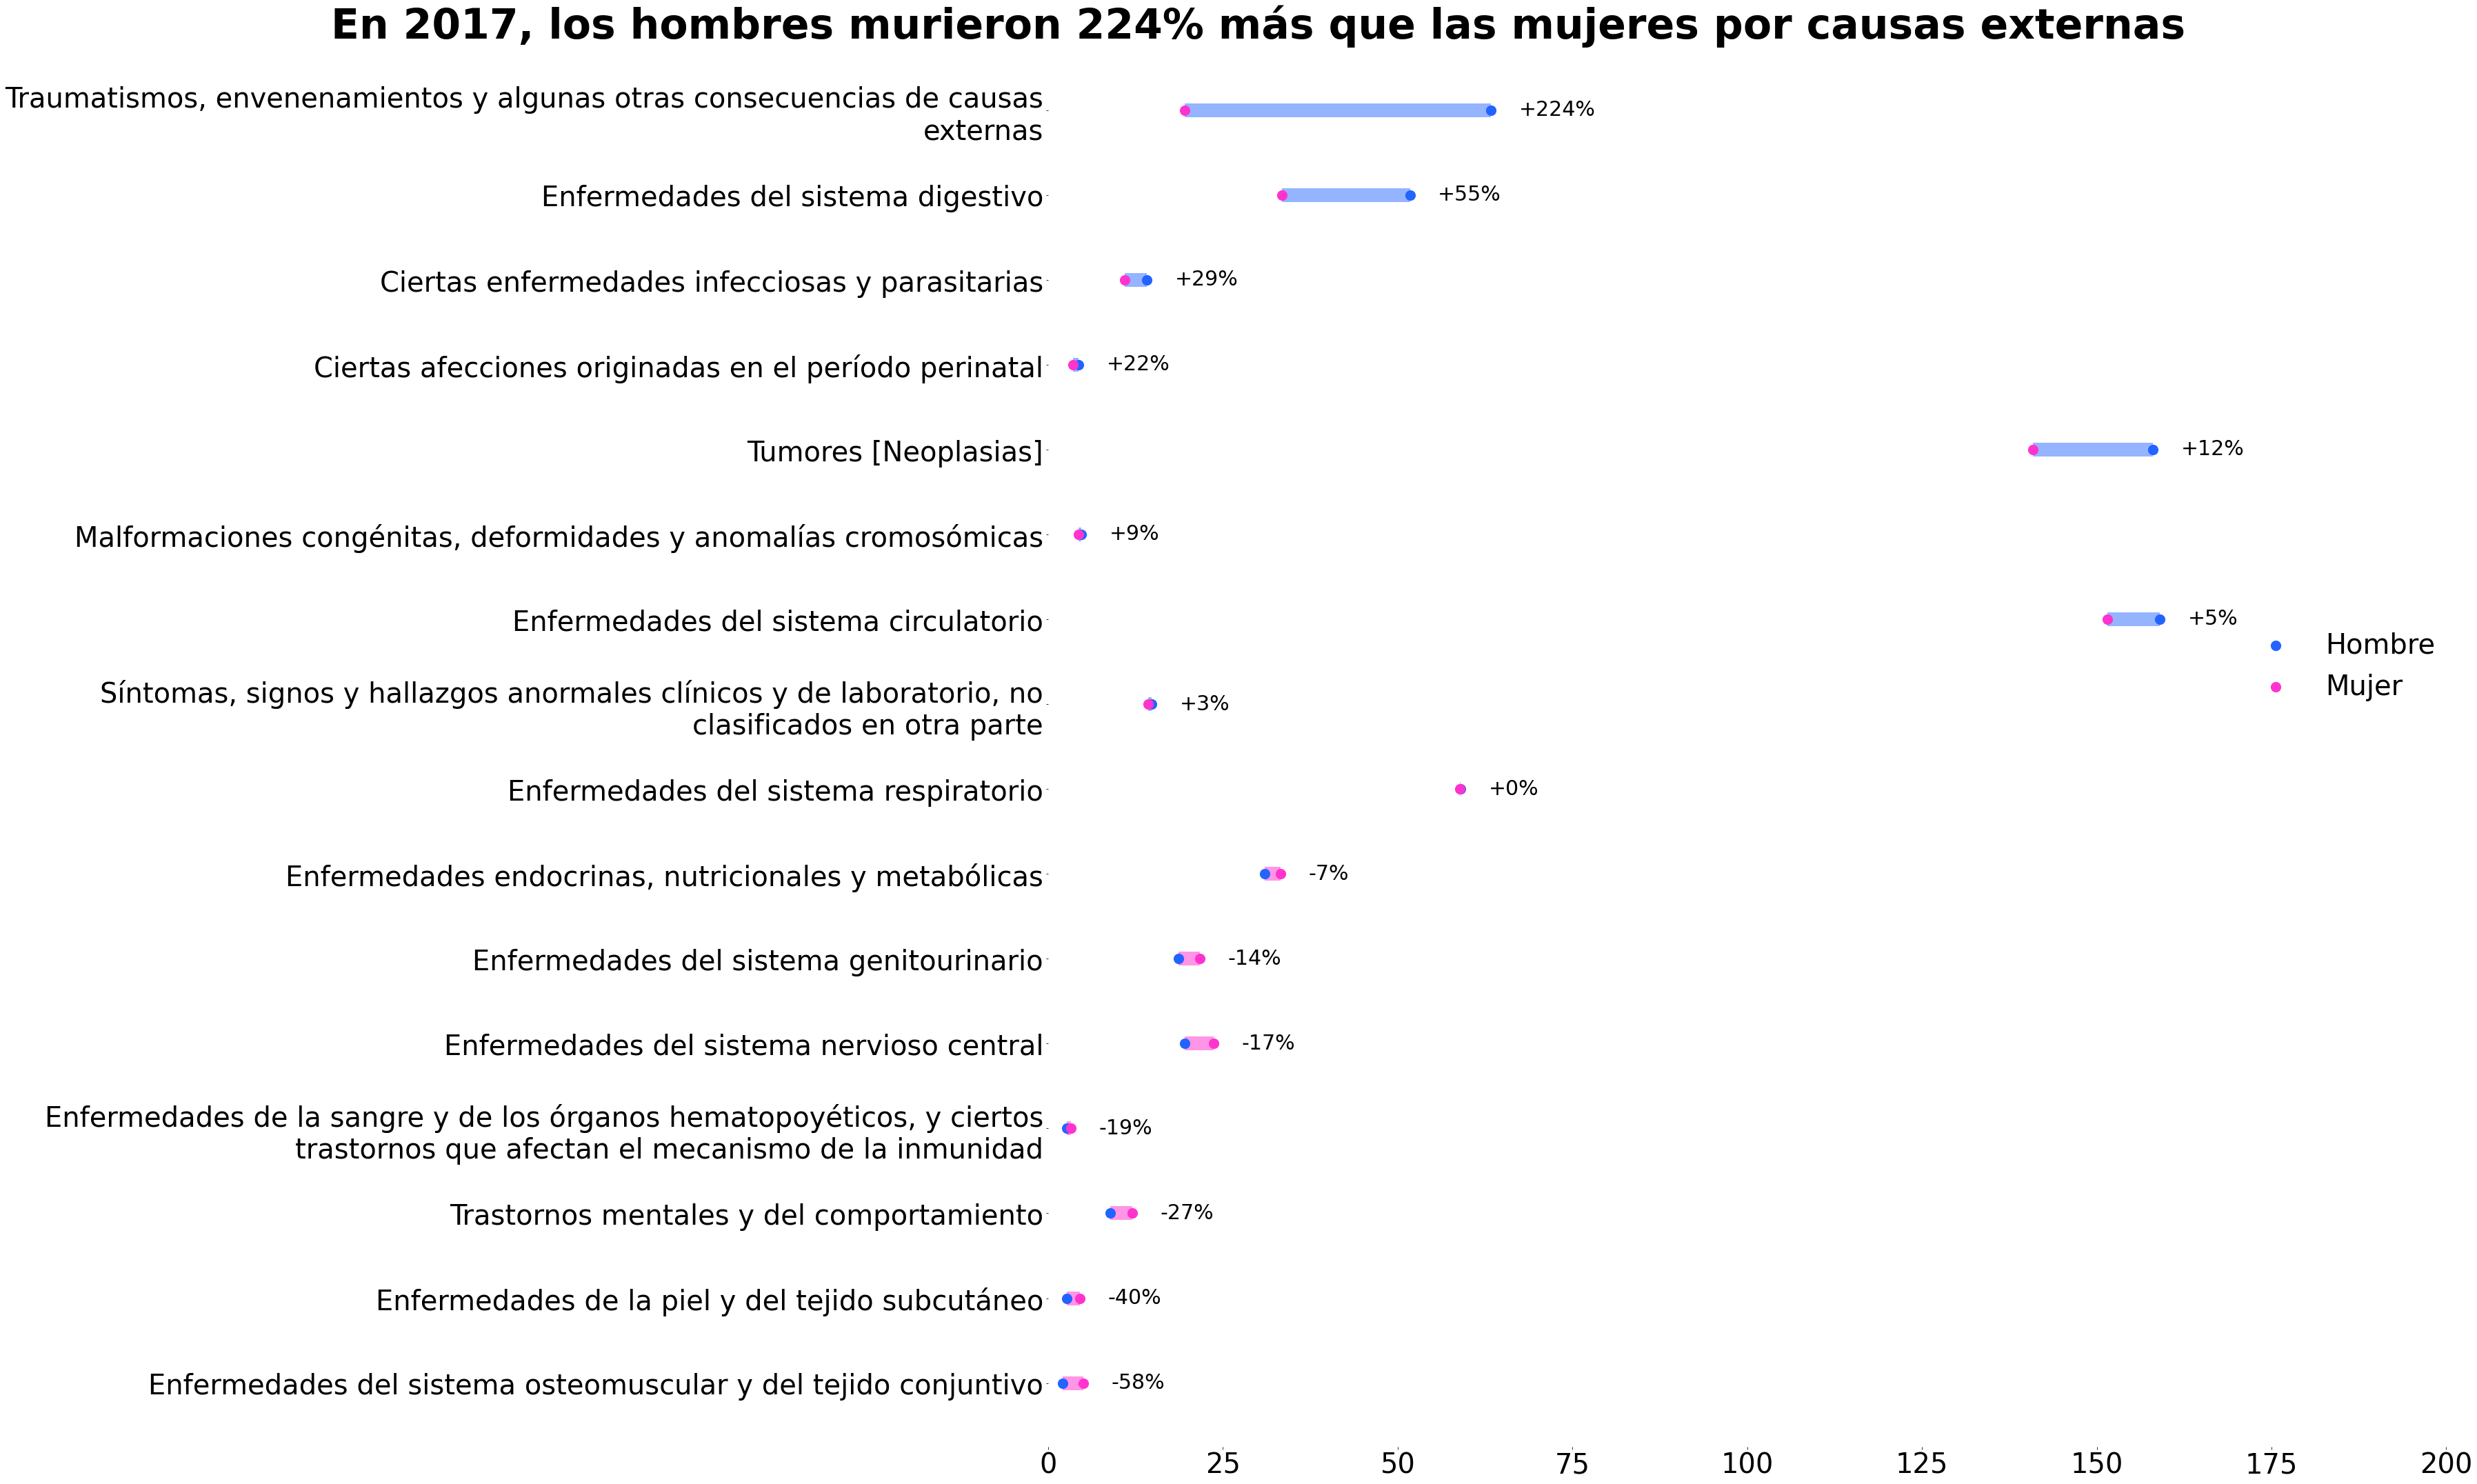

In [31]:
tasa_def_gen_2017 = tasa_def_gen[tasa_def_gen['anio']==2017]
tasa_def_gen_2017 = tasa_def_gen_2017[tasa_def_gen_2017['causa']!='Enfermedades del oído y de la apófisis mastoides']
tasa_def_gen_2017 = tasa_def_gen_2017[tasa_def_gen_2017['causa']!='Enfermedades del ojo y sus anexos ']
tab8 = (tasa_def_gen_2017
        .pivot_table("tasa_def_gen",index=["causa"], columns = "sexo",aggfunc=sum))
tab8['delta'] = tab8["Hombre"] / tab8["Mujer"] - 1
tab8 = tab8.sort_values('delta').dropna()

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab8.index) + 1)
colors = np.where(tab8['Mujer'] > tab8['Hombre'], '#FF95E6', '#95B4FF')

plt.hlines(y=y_range, xmin=tab8['Hombre'], xmax=tab8['Mujer'],
           color=colors, lw=20)
plt.scatter(tab8['Hombre'], y_range, color='#2363FF', s=200, label='Hombre', zorder=3)
plt.scatter(tab8['Mujer'], y_range, color='#FF33CE', s=200 , label='Mujer', zorder=3)

plt.yticks(y_range, [ '\n'.join(textwrap.wrap(l, 70)) for l in tab8.index ],fontsize=40)
plt.xticks(fontsize=40)
plt.title("En 2017, los hombres murieron 224% más que las mujeres por causas externas",
         fontsize=60,position= (.15,0),weight='bold')
plt.xlim(0, 200)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab8.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["Hombre"], row["Mujer"]) +4 , y - 0.06), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.4, -0.15, 0.2), loc='upper center', frameon=False, prop={'size': 40})
hide_border(ax)
plt.show()

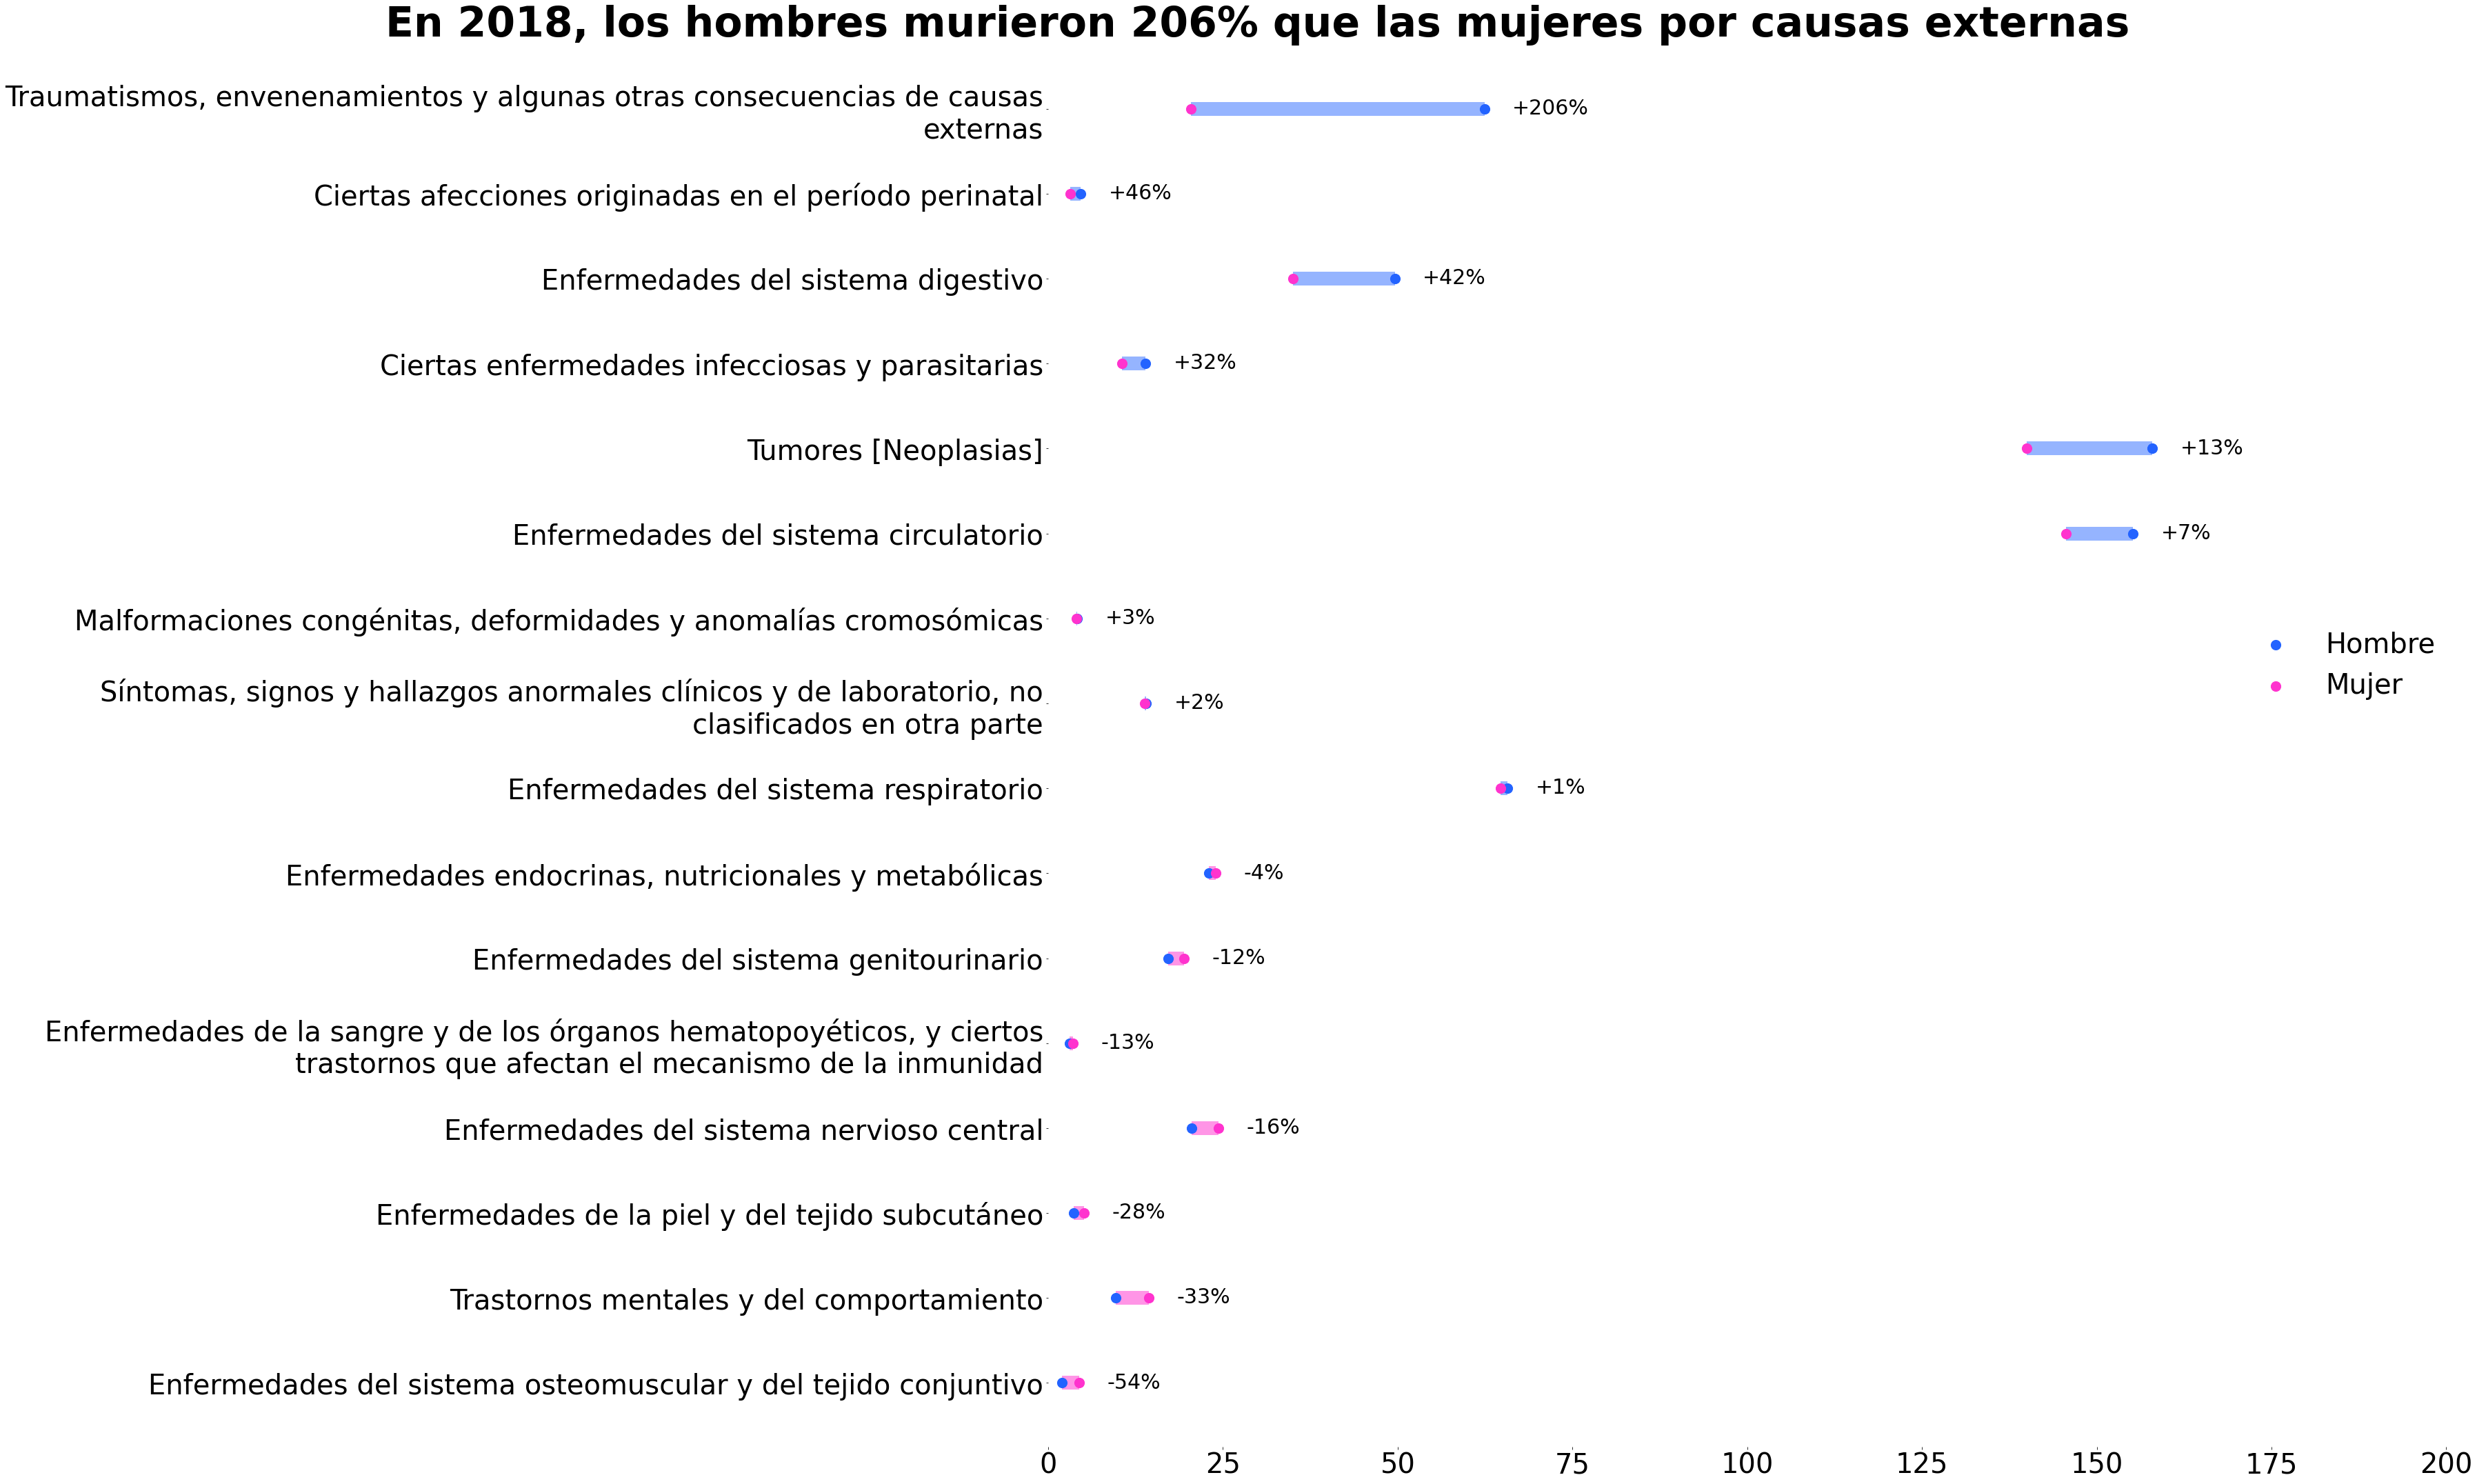

In [32]:
tasa_def_gen_2018 = tasa_def_gen[tasa_def_gen['anio']==2018]
tasa_def_gen_2018 = tasa_def_gen_2018[tasa_def_gen_2018['causa']!='Enfermedades del oído y de la apófisis mastoides']
tasa_def_gen_2018 = tasa_def_gen_2018[tasa_def_gen_2018['causa']!='Enfermedades del ojo y sus anexos ']
tab9 = (tasa_def_gen_2018
        .pivot_table("tasa_def_gen",index=["causa"], columns = "sexo",aggfunc=sum))
tab9['delta'] = tab9["Hombre"] / tab9["Mujer"] - 1
tab9 = tab9.sort_values('delta').dropna()

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab9.index) + 1)
colors = np.where(tab9['Mujer'] > tab9['Hombre'], '#FF95E6', '#95B4FF')

plt.hlines(y=y_range, xmin=tab9['Hombre'], xmax=tab9['Mujer'],
           color=colors, lw=20)
plt.scatter(tab9['Hombre'], y_range, color='#2363FF', s=200, label='Hombre', zorder=3)
plt.scatter(tab9['Mujer'], y_range, color='#FF33CE', s=200 , label='Mujer', zorder=3)
plt.yticks(y_range, [ '\n'.join(textwrap.wrap(l, 70)) for l in tab9.index ],fontsize=40)
plt.xticks(fontsize=40)
plt.title("En 2018, los hombres murieron 206% que las mujeres por causas externas",
         fontsize=60,position= (.15,0),weight='bold')
plt.xlim(0, 200)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab9.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["Hombre"], row["Mujer"]) +4 , y - 0.06), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.4, -0.15, 0.2), loc='upper center', frameon=False, prop={'size': 40})
hide_border(ax)
plt.show()

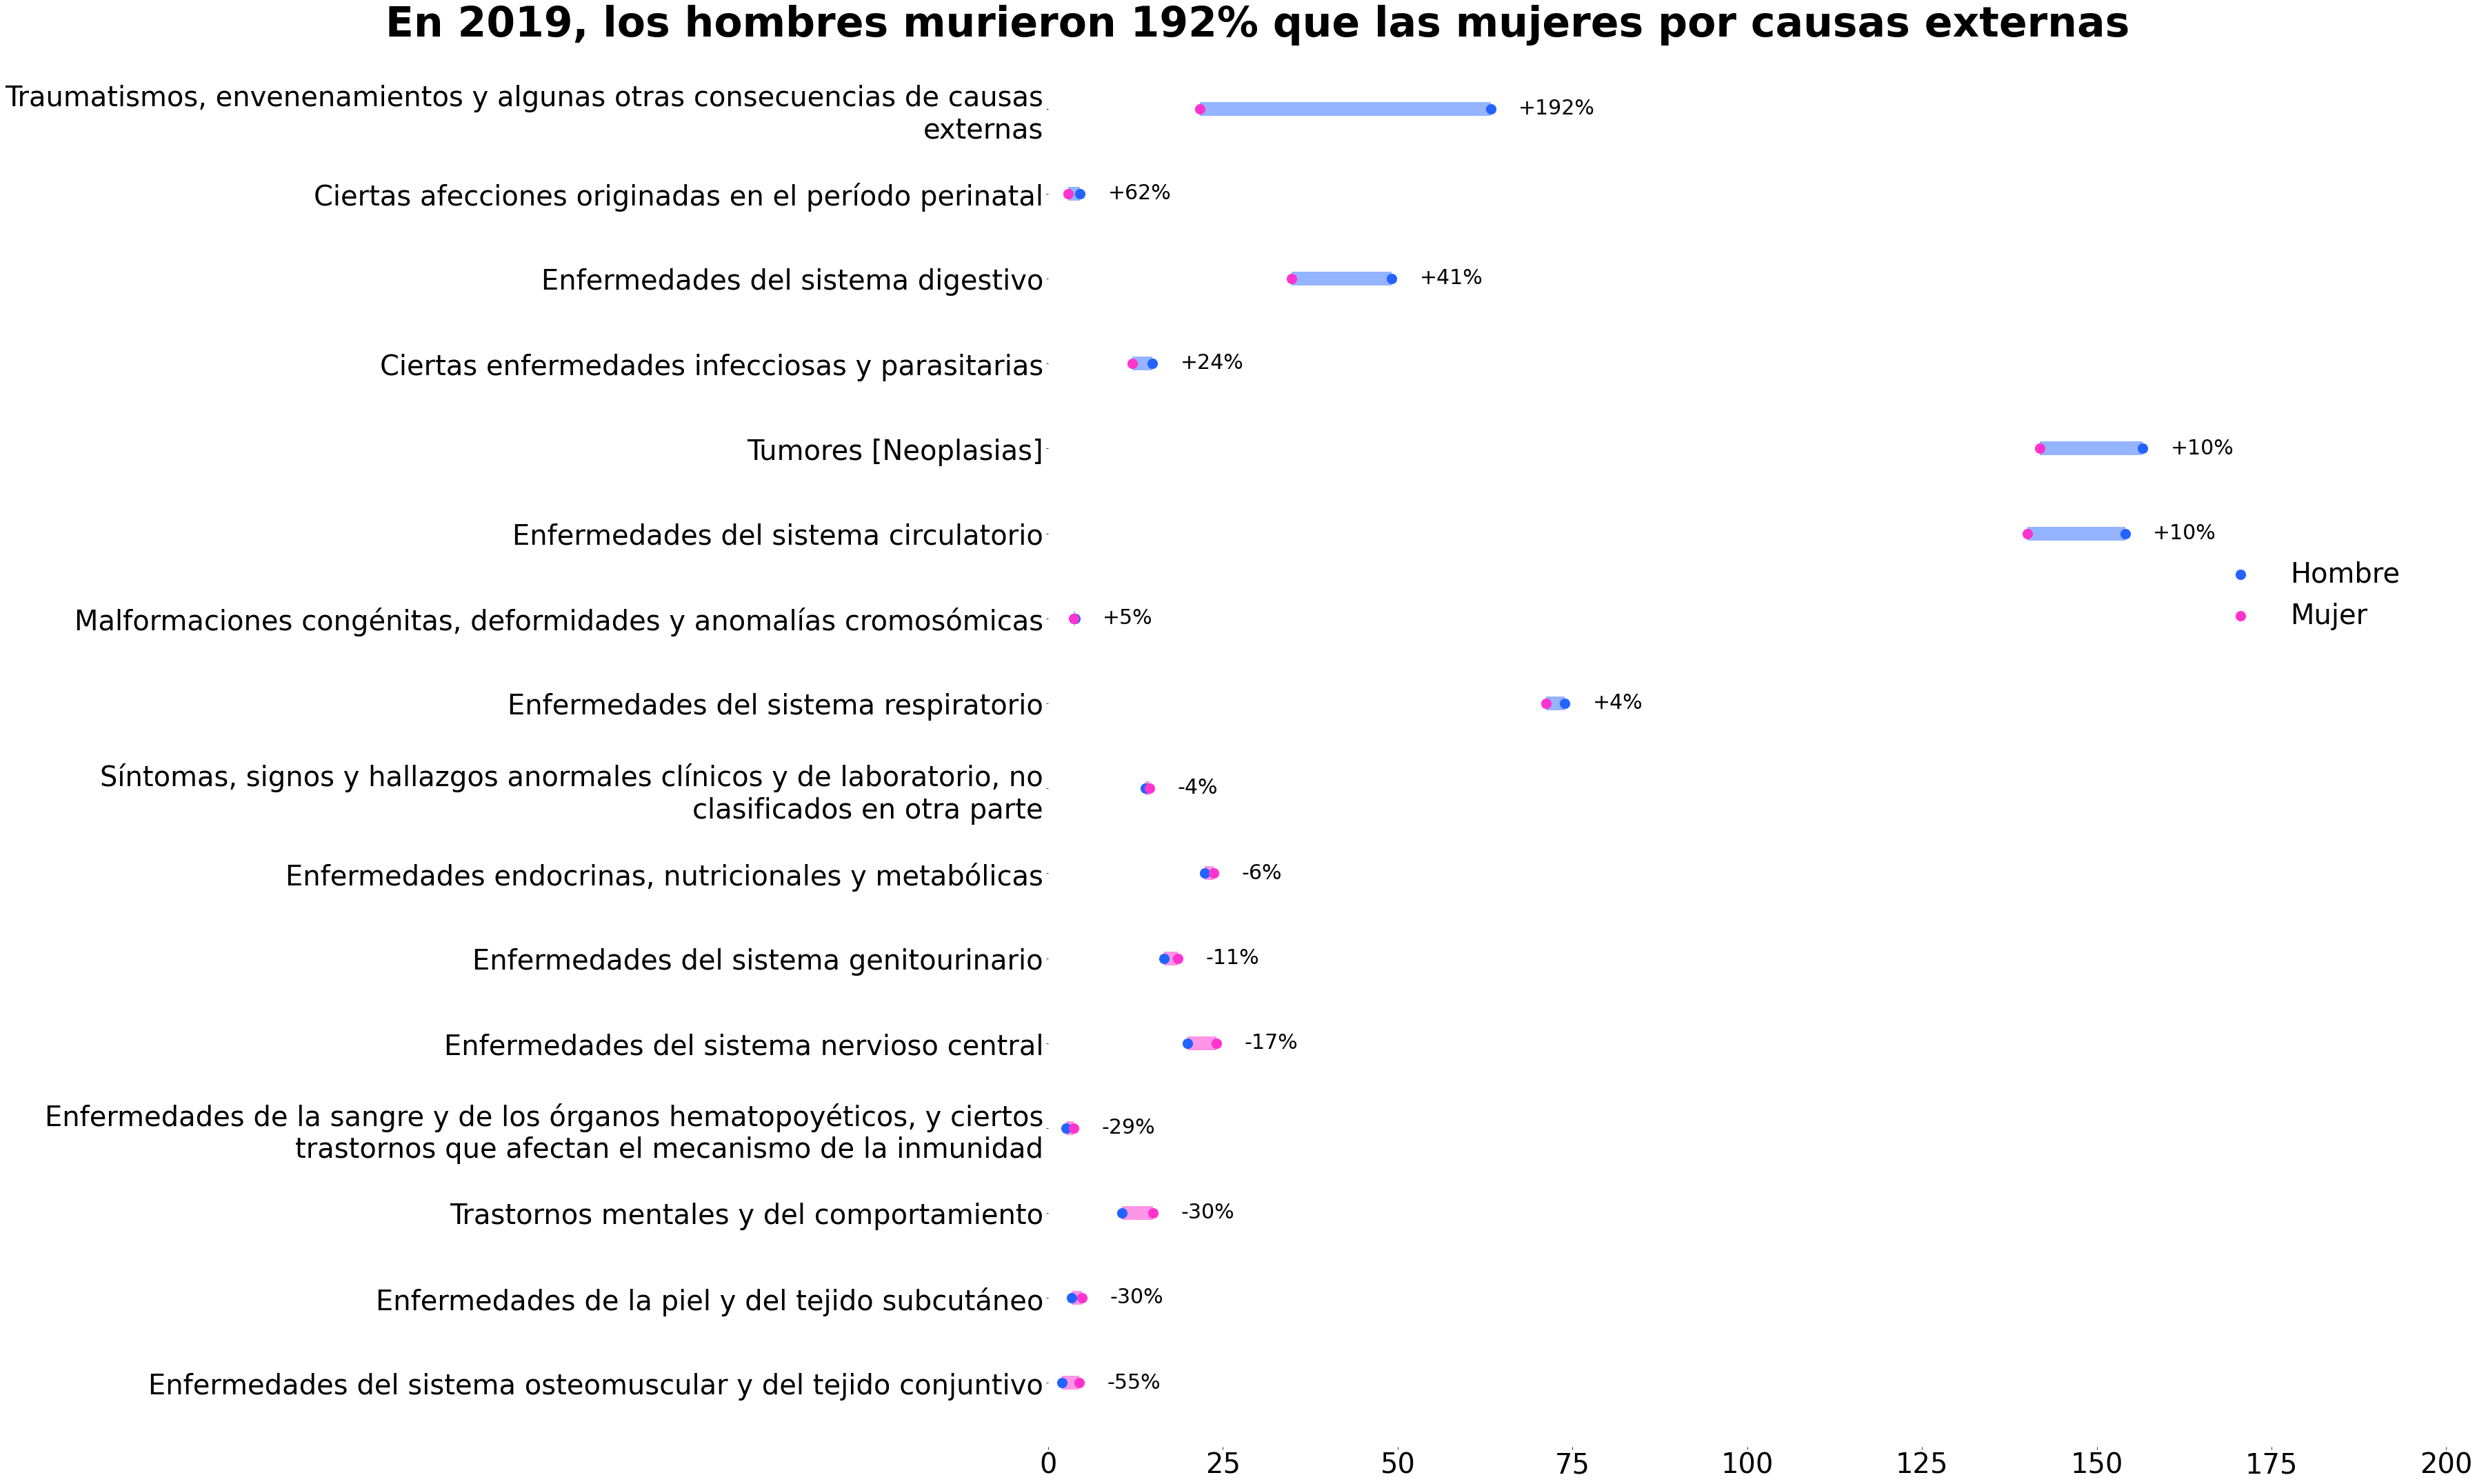

In [33]:
tasa_def_gen_2019 = tasa_def_gen[tasa_def_gen['anio']==2019]
tasa_def_gen_2019 = tasa_def_gen_2019[tasa_def_gen_2019['causa']!='Enfermedades del oído y de la apófisis mastoides']
tasa_def_gen_2019 = tasa_def_gen_2019[tasa_def_gen_2019['causa']!='Enfermedades del ojo y sus anexos ']
tab10 = (tasa_def_gen_2019
        .pivot_table("tasa_def_gen",index=["causa"], columns = "sexo",aggfunc=sum))
tab10['delta'] = tab10["Hombre"] / tab10["Mujer"] - 1
tab10 = tab10.sort_values('delta').dropna()

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab10.index) + 1)
colors = np.where(tab10['Mujer'] > tab10['Hombre'], '#FF95E6', '#95B4FF')

plt.hlines(y=y_range, xmin=tab10['Hombre'], xmax=tab10['Mujer'],
           color=colors, lw=20)
plt.scatter(tab10['Hombre'], y_range, color='#2363FF', s=200, label='Hombre', zorder=3)
plt.scatter(tab10['Mujer'], y_range, color='#FF33CE', s=200 , label='Mujer', zorder=3)

plt.yticks(y_range, [ '\n'.join(textwrap.wrap(l, 70)) for l in tab10.index ],fontsize=40)
plt.xticks(fontsize=40)
plt.title("En 2019, los hombres murieron 192% que las mujeres por causas externas", 
          fontsize=60,position= (.15,0),weight='bold')
plt.xlim(0, 200)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab10.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["Hombre"], row["Mujer"]) +4 , y - 0.06), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.45, -0.2, 0.2), loc='upper center', frameon=False, prop={'size': 40})
hide_border(ax)
plt.show()

Por otro lado, si bien en los años 2020 y 2021 la principal diferencia entre hombres y mujeres sigue estando en las muertes causadas por traumatismos, envenenamientos y otras consecuencias de causas externas, se produce un quiebre respecto a los años anteriores. Como se mencionó anteriormente, entre 2016 y 2019 no se observaron diferencias entre hombres y mujeres respecto a la mortalidad según enfermedades del sistema respiratorio, sin embargo, como muestran los siguientes gráficos, en 2020 y 2021, dicha mortalidad en hombres fue mayor en 27% y 21%, respectivamente, en comparación a las mujeres. Dado que estos años los fallecimientos por esta causa aumentaron debido a la llegada del Covid-19, es posible concluir que el Covid-19 tuvo un mayor impacto en hombres que en mujeres.

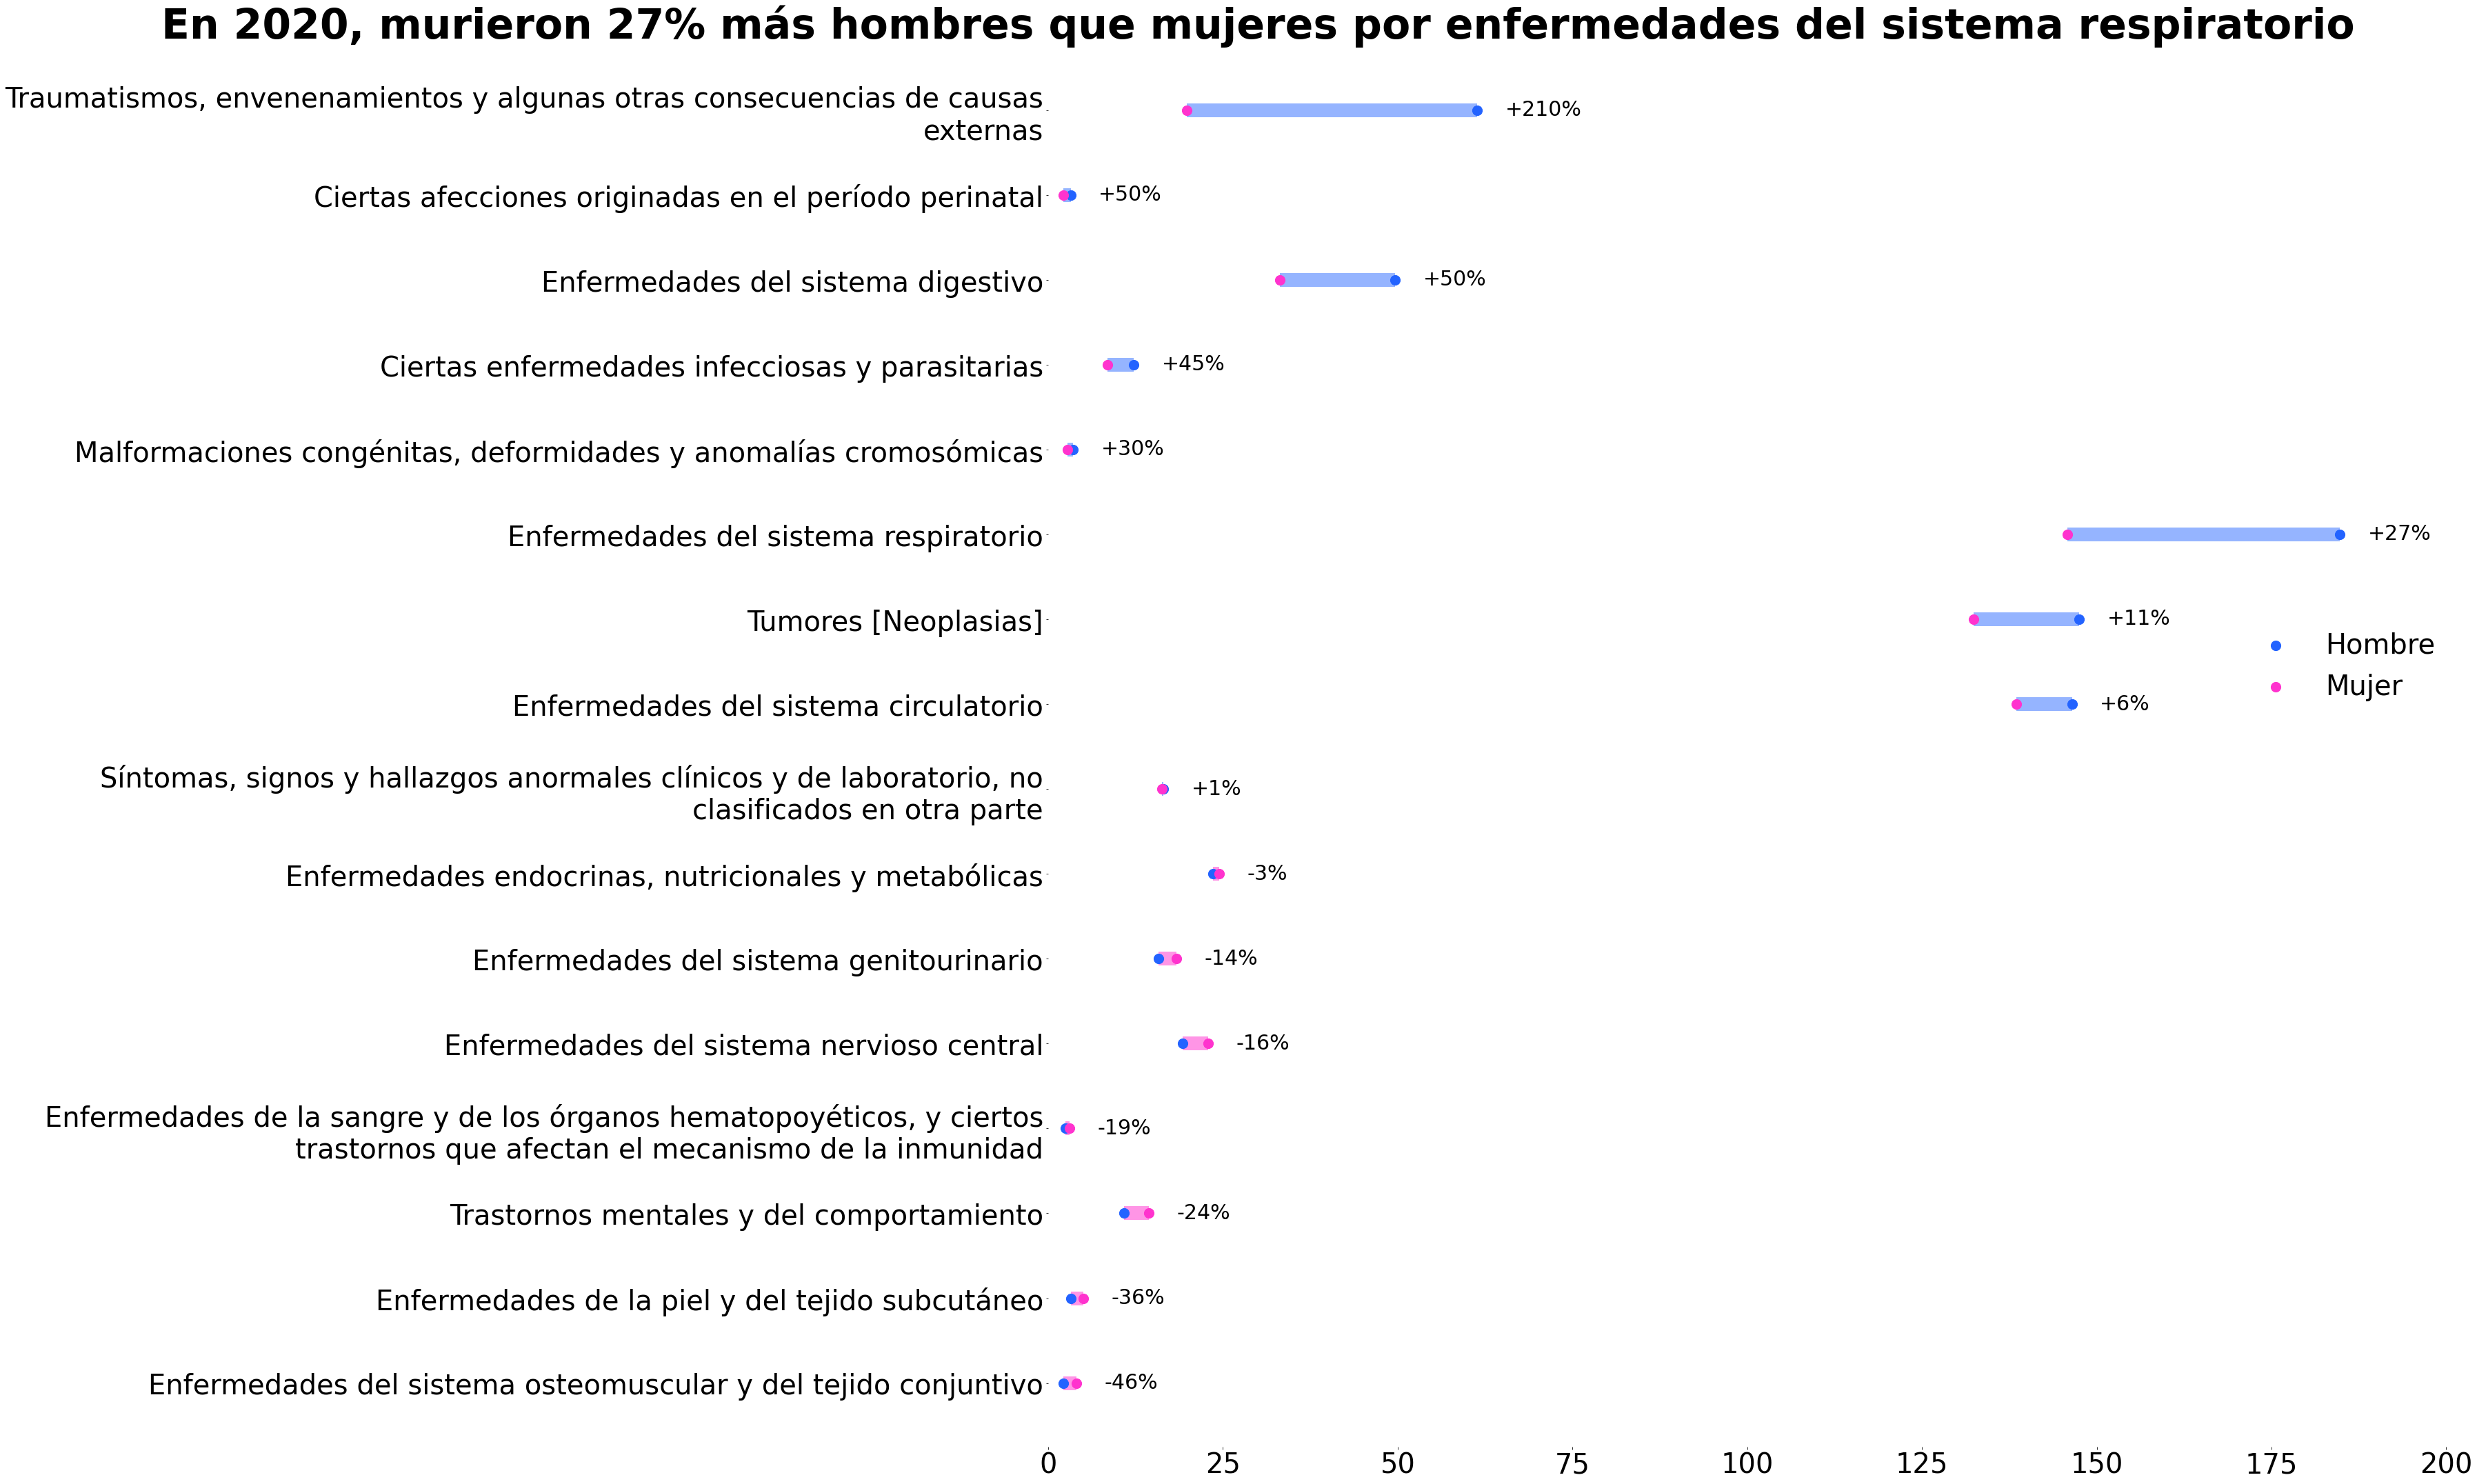

In [34]:
tasa_def_gen_2020 = tasa_def_gen[tasa_def_gen['anio']==2020]
tasa_def_gen_2020 = tasa_def_gen_2020[tasa_def_gen_2020['causa']!='Enfermedades del oído y de la apófisis mastoides']
tasa_def_gen_2020 = tasa_def_gen_2020[tasa_def_gen_2020['causa']!='Enfermedades del ojo y sus anexos ']
tab11 = (tasa_def_gen_2020
        .pivot_table("tasa_def_gen",index=["causa"], columns = "sexo",aggfunc=sum))
tab11['delta'] = tab11["Hombre"] / tab11["Mujer"] - 1
tab11 = tab11.sort_values('delta').dropna()

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab11.index) + 1)
colors = np.where(tab11['Mujer'] > tab11['Hombre'], '#FF95E6', '#95B4FF')

plt.hlines(y=y_range, xmin=tab11['Hombre'], xmax=tab11['Mujer'],
           color=colors, lw=20)
plt.scatter(tab11['Hombre'], y_range, color='#2363FF', s=200, label='Hombre', zorder=3)
plt.scatter(tab11['Mujer'], y_range, color='#FF33CE', s=200 , label='Mujer', zorder=3)
plt.yticks(y_range, [ '\n'.join(textwrap.wrap(l, 70)) for l in tab11.index ],fontsize=40)
plt.xticks(fontsize=40)
plt.title("En 2020, murieron 27% más hombres que mujeres por enfermedades del sistema respiratorio",
         fontsize=60,position= (.15,0),weight='bold')
plt.xlim(0, 200)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab11.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["Hombre"], row["Mujer"]) +4 , y - 0.06), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.4, -0.15, 0.2), loc='upper center', frameon=False, prop={'size': 40})
hide_border(ax)
plt.show()

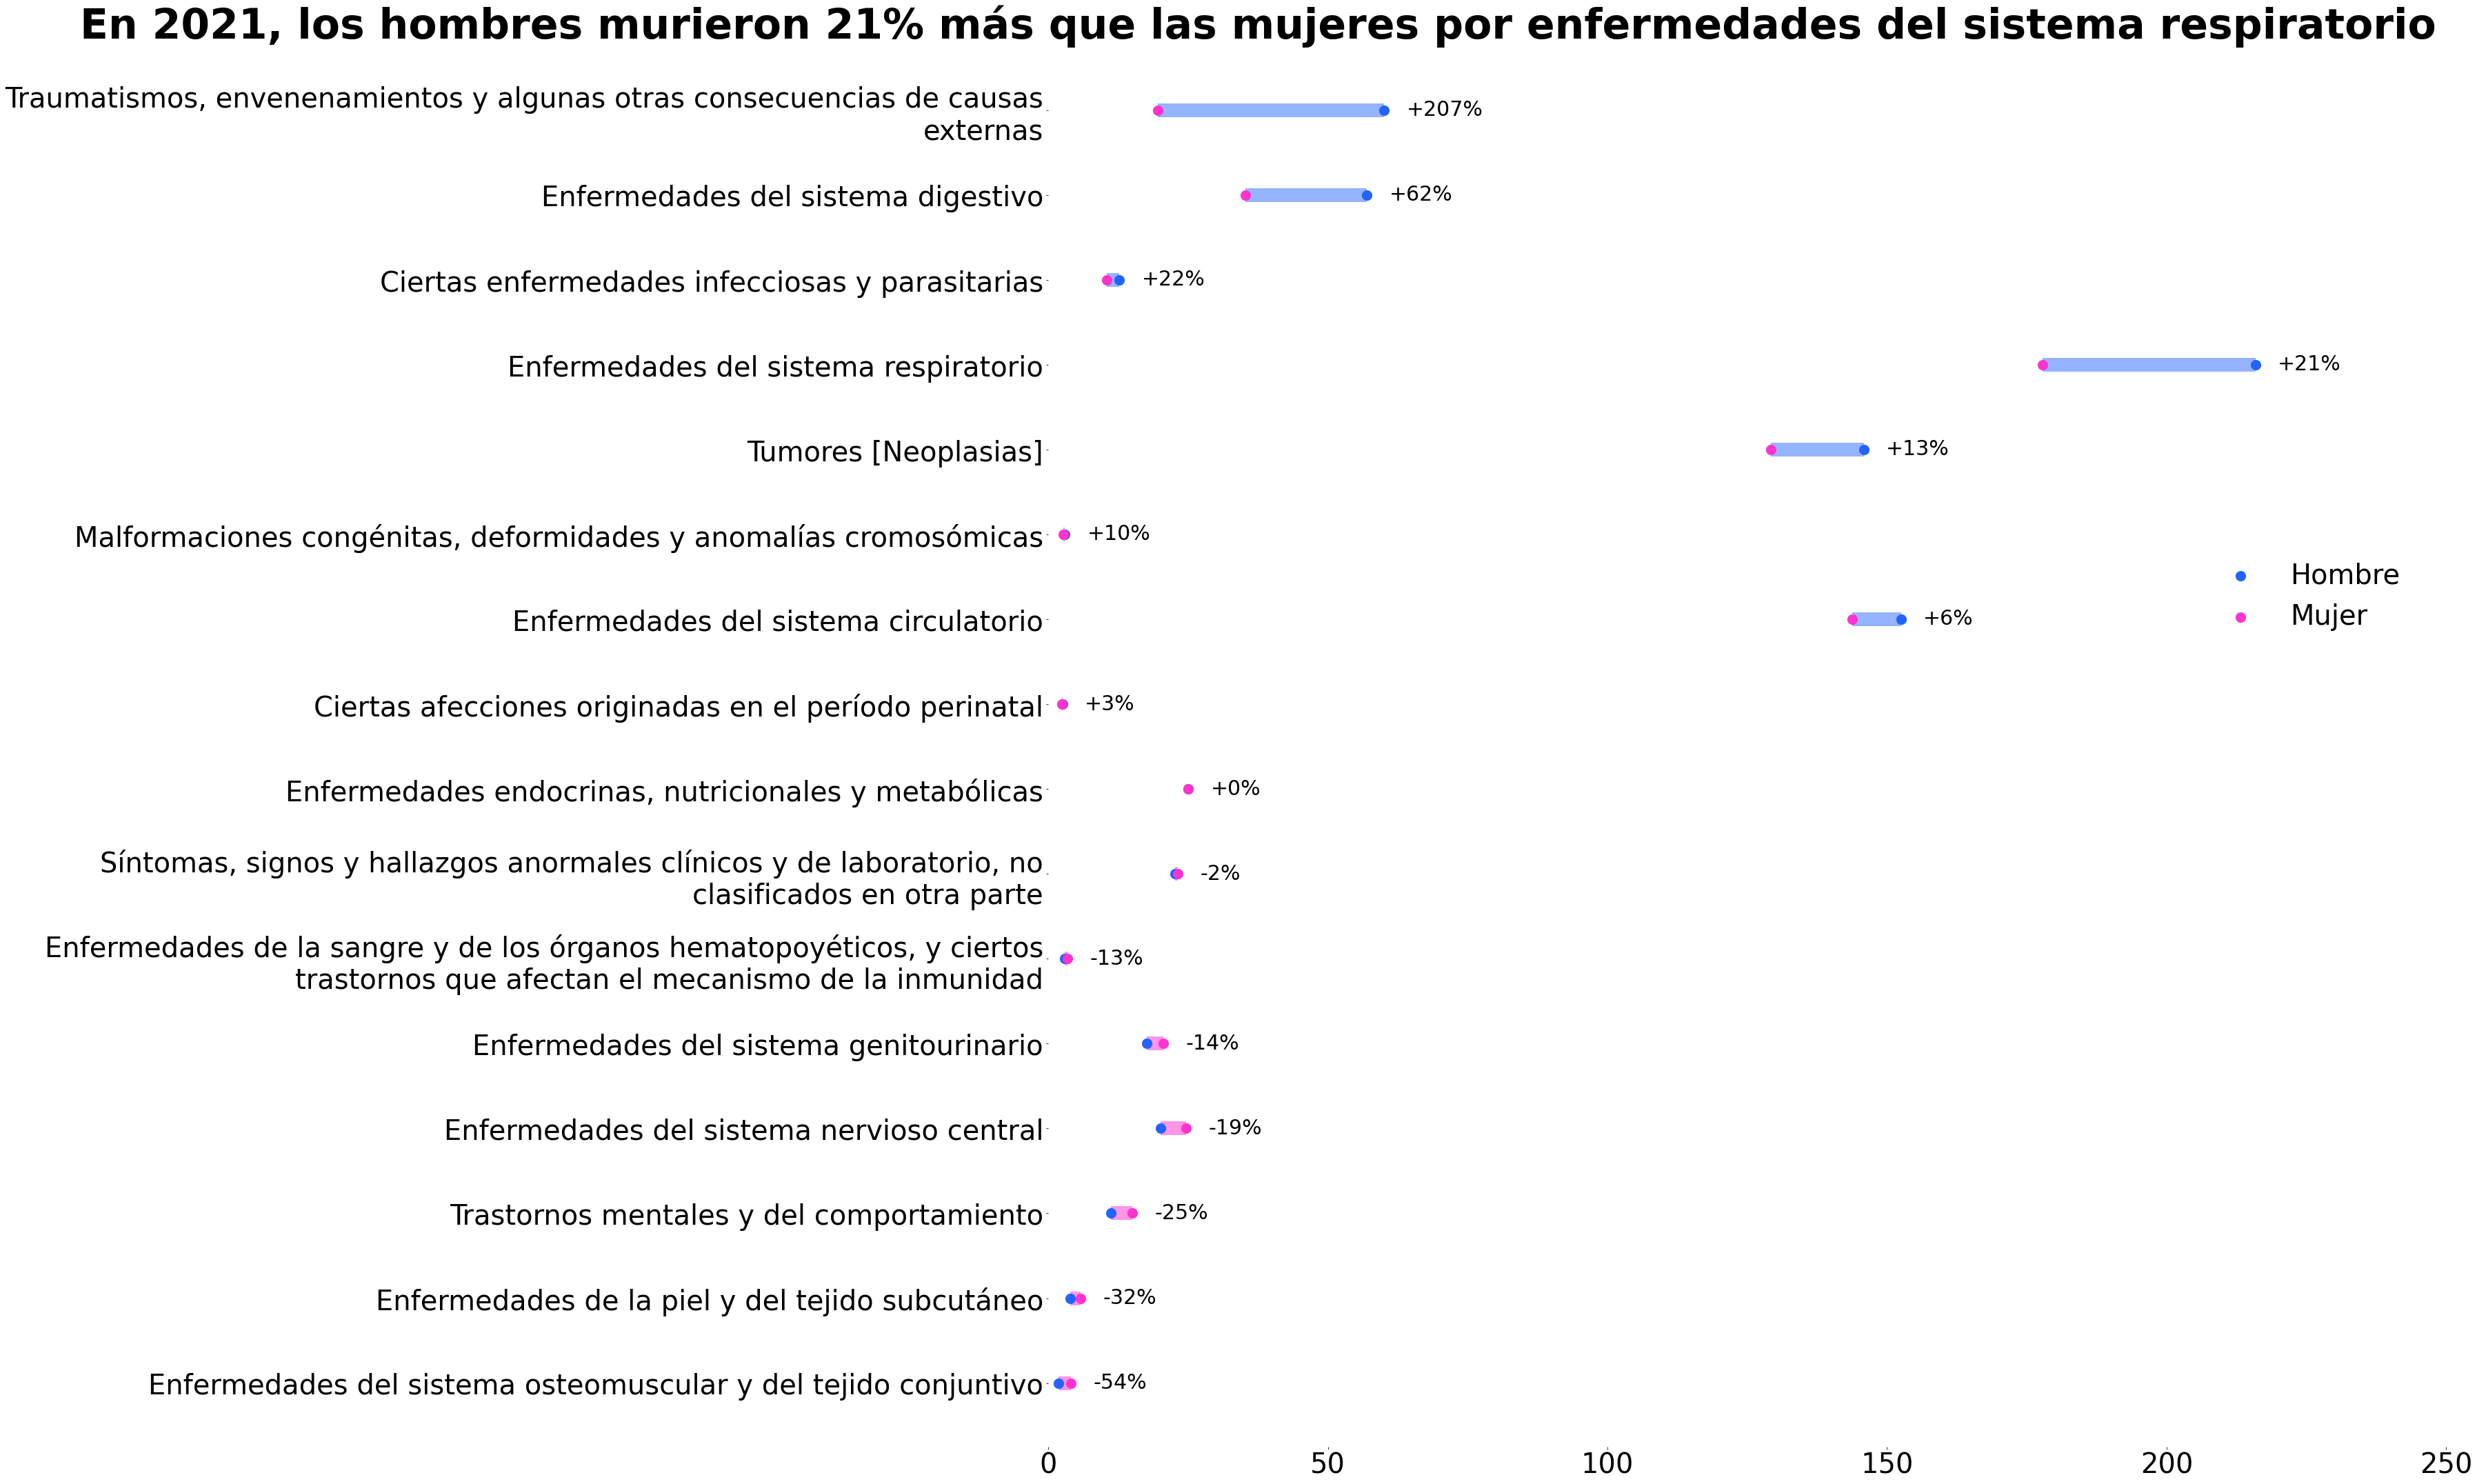

In [35]:
tasa_def_gen_2021 = tasa_def_gen[tasa_def_gen['anio']==2021]
tasa_def_gen_2021 = tasa_def_gen_2021[tasa_def_gen_2021['causa']!='Enfermedades del oído y de la apófisis mastoides']
tasa_def_gen_2021 = tasa_def_gen_2021[tasa_def_gen_2021['causa']!='Enfermedades del ojo y sus anexos ']
tab12 = (tasa_def_gen_2021
        .pivot_table("tasa_def_gen",index=["causa"], columns = "sexo",aggfunc=sum))
tab12['delta'] = tab12["Hombre"] / tab12["Mujer"] - 1
tab12 = tab12.sort_values('delta').dropna()

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab12.index) + 1)
colors = np.where(tab12['Mujer'] > tab12['Hombre'], '#FF95E6', '#95B4FF')

plt.hlines(y=y_range, xmin=tab12['Hombre'], xmax=tab12['Mujer'],
           color=colors, lw=20)
plt.scatter(tab12['Hombre'], y_range, color='#2363FF', s=200, label='Hombre', zorder=3)
plt.scatter(tab12['Mujer'], y_range, color='#FF33CE', s=200 , label='Mujer', zorder=3)

plt.yticks(y_range, [ '\n'.join(textwrap.wrap(l, 70)) for l in tab12.index ],fontsize=40)
plt.xticks(fontsize=40)
plt.title("En 2021, los hombres murieron 21% más que las mujeres por enfermedades del sistema respiratorio",
         fontsize=60,position= (.15,0),weight='bold')
plt.xlim(0, 250)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab12.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["Hombre"], row["Mujer"]) +4 , y - 0.06), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.45, -0.2, 0.2), loc='upper center', frameon=False, prop={'size': 40})
hide_border(ax)
plt.show()

## Diferencias en la mortalidad por enfermedades respiratorias entre zona urbana y rural
En 2020 y 2021, la tasa de mortalidad por enfermedades respiratorias tuvo un aumento importante, llegando a ser la primera causa de muerte en Chile y superando a las enfermedades del sistema circulatorio y los tumores, que en el período 2016-2019 tuvieron una mayor preponderancia. Como se ha mencionado previamente, esto se debe a la llegada del Covid-19 al país, la cual repercutió fuertemente en la salud de la población. Sin embargo, cabe preguntarse si el aumento en dicha tasa de mortalidad fue igual en las zonas urbanas que en las zonas rurales. Para esto, se compara la diferencia en la tasa de mortalidad por enfermedades del sistema respiratorio entre los años 2018 y 2019, y 2019 y 2020, diferenciando entre aquellas comunas 100% rurales y 0% rurales.

In [36]:
tasa_def_com_2018_2019 = tasa_def_com[(tasa_def_com["anio"]==2018) | (tasa_def_com["anio"]==2019)]
tasa_def_com_2018_2019 = tasa_def_com_2018_2019[tasa_def_com_2018_2019['causa']=='Enfermedades del sistema respiratorio ']
tasa_def_com_2018_2019.loc[tasa_def_com_2018_2019.anio == 2018, 'anio'] ='anio_2018'
tasa_def_com_2018_2019.loc[tasa_def_com_2018_2019.anio == 2019, 'anio'] ='anio_2019'
tab13 = (tasa_def_com_2018_2019
        .pivot_table("tasa_def_com",index=["Glosa Comuna"], columns = "anio",aggfunc=sum))
tab13['delta'] = tab13["anio_2019"] / tab13["anio_2018"] - 1
tasa_rur_2019 = tasa_def_com[(tasa_def_com["anio"]==2019) & (tasa_def_com['causa']=='Enfermedades del sistema respiratorio ')]
tasa_rur_2019 = tasa_rur_2019[['Glosa Comuna','tasa_rur']].set_index('Glosa Comuna')
tab13 = pd.merge(tab13, tasa_rur_2019, left_index=True, right_index=True).sort_values(['tasa_rur','delta'])
tab13 = tab13[(tab13['tasa_rur']==100) | (tab13['tasa_rur']==0)].dropna()

En el siguiente gráfico se observa que, entre el año 2018 y 2019, solamente en dos comunas 100% rurales hubo un aumento en la tasa de mortalidad por enfermedades del sistema respiratorio, mientras que en las demás hubo una disminución o no existieron cambios. Por otra parte, en la mayoría de las comunas con 0% de población rural dicha tasa de mortalidad aumentó, y solo en unas pocas se observa la tendencia contraria.

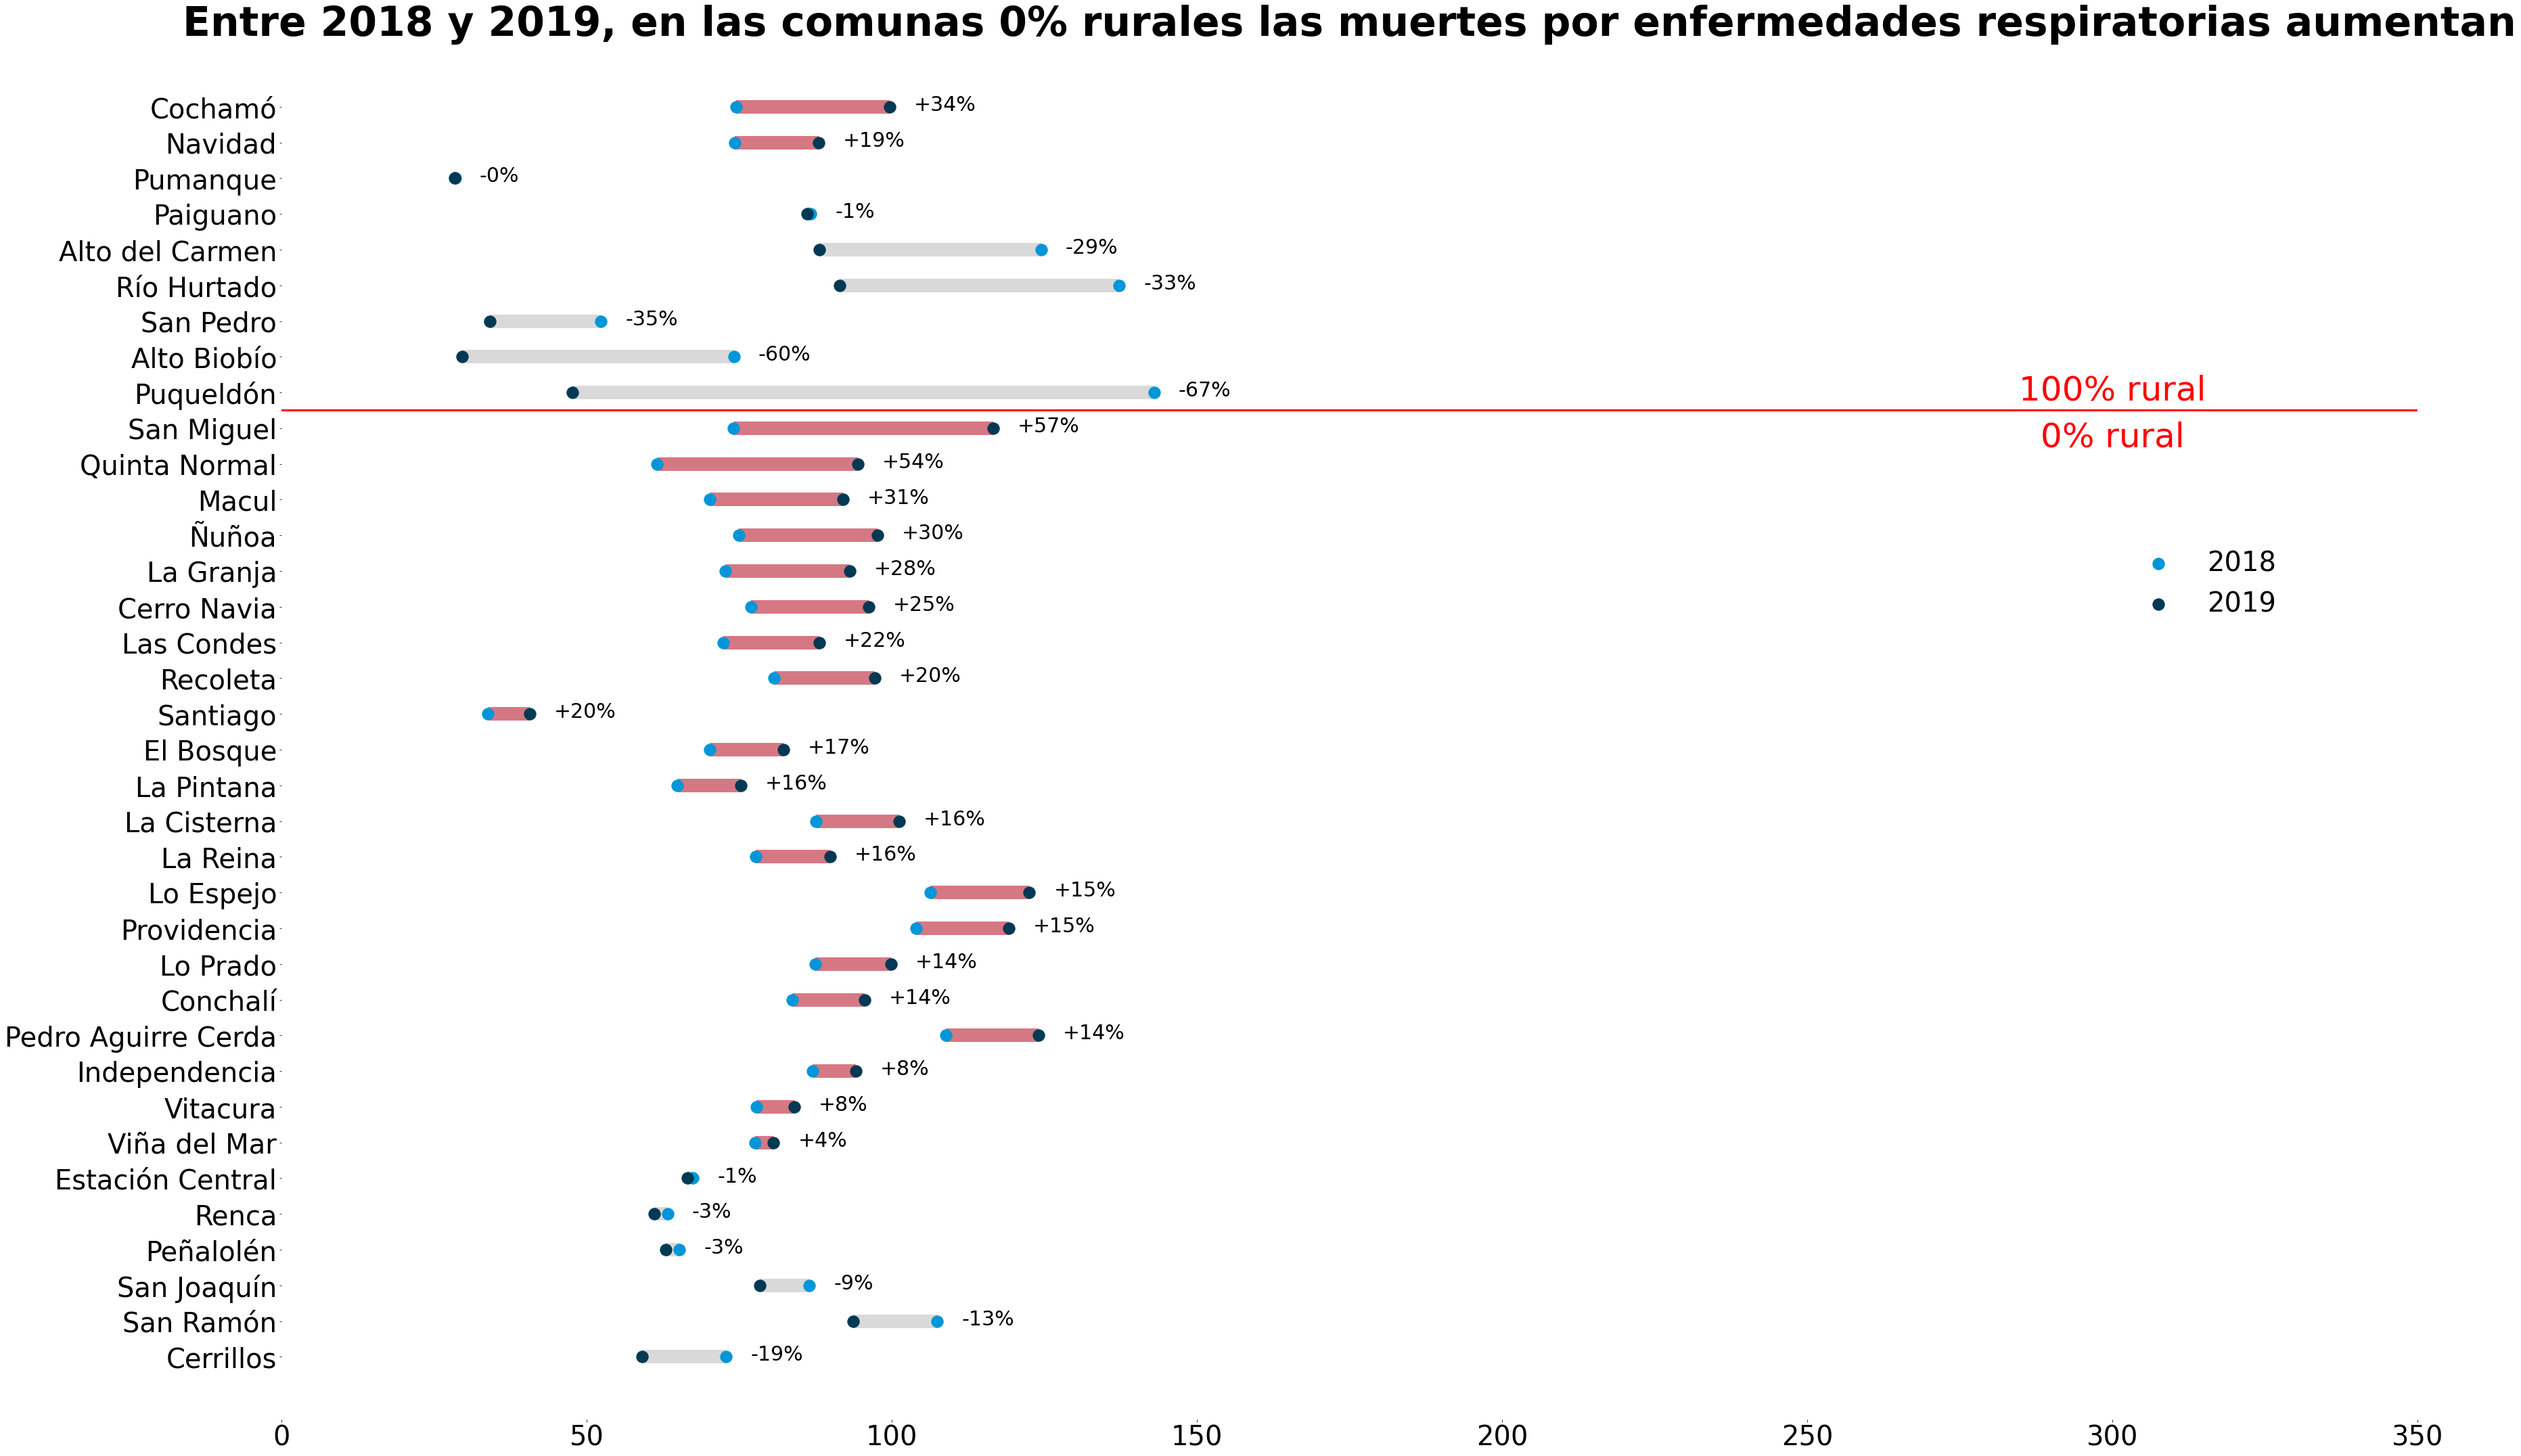

In [37]:

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab13.index) + 1)
colors = np.where(tab13['anio_2019'] > tab13['anio_2018'], '#d57883', '#d9d9d9')

plt.hlines(y=y_range, xmin=tab13['anio_2018'], xmax=tab13['anio_2019'],
           color=colors, lw=20)
plt.scatter(tab13['anio_2018'], y_range, color='#0096d7', s=300, label='2018', zorder=3)
plt.scatter(tab13['anio_2019'], y_range, color='#003953', s=300 , label='2019', zorder=3)

plt.yticks(y_range, tab13.index,fontsize=40)
plt.xticks(fontsize=40)
plt.title("Entre 2018 y 2019, en las comunas 0% rurales las muertes por enfermedades respiratorias aumentan", 
         fontsize=60,position= (.5,0),weight='bold')
plt.xlim(0, 350)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab13.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["anio_2018"], row["anio_2019"]) + 4, y - .1), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.45, -0.2, 0.2), loc='upper center', frameon=False, prop={'size': 40})
hide_border(ax)
plt.axhline(y=27.5, color='r', linestyle='-',lw=3)
plt.text(300,27.8, '100% rural', ha='center',fontsize=50,c='red')
plt.text(300,26.5, '0% rural', ha='center',fontsize=50,c='red')
plt.show()


In [38]:
tasa_def_com_2019_2020 = tasa_def_com[(tasa_def_com["anio"]==2019) | (tasa_def_com["anio"]==2020)]
tasa_def_com_2019_2020 = tasa_def_com_2019_2020[tasa_def_com_2019_2020['causa']=='Enfermedades del sistema respiratorio ']
tasa_def_com_2019_2020.loc[tasa_def_com_2019_2020.anio == 2019, 'anio'] ='anio_2019'
tasa_def_com_2019_2020.loc[tasa_def_com_2019_2020.anio == 2020, 'anio'] ='anio_2020'
tab14 = (tasa_def_com_2019_2020
        .pivot_table("tasa_def_com",index=["Glosa Comuna"], columns = "anio",aggfunc=sum))
tab14['delta'] = tab14["anio_2020"] / tab14["anio_2019"] - 1
tasa_rur_2020 = tasa_def_com[(tasa_def_com["anio"]==2020) & (tasa_def_com['causa']=='Enfermedades del sistema respiratorio ')]
tasa_rur_2020 = tasa_rur_2020[['Glosa Comuna','tasa_rur']].set_index('Glosa Comuna')
tab14 = pd.merge(tab14, tasa_rur_2020, left_index=True, right_index=True).sort_values(['tasa_rur','delta'])
tab14 = tab14[(tab14['tasa_rur']==100) | (tab14['tasa_rur']==0)].dropna()

Ahora bien, entre el año 2019 y 2020, a diferencia de 2018 y 2019, en la mayoría de las comunas 100% rurales se observa un aumento de la mortalidad por enfermedades del sistema respiratorio, lo cual es similar a las comunas 0% rurales, donde dicha mortalidad aumenta en todos los casos. Sin embargo, cabe mencionar que el mayor aumento en el caso de las comunas 100% rurales es de 300% (Pumanque) y, el menor, 39% (Alto del Carmen), incluso con dos comunas donde hay una disminución (Sierra Gorda y Río Ibáñez). No obstante, en el caso de las comunas con 0% de población rural, el mayor aumento es de 400% (San Ramón) y, aproximadamente la mitad presenta un incremento superior a 200%, con un mínimo de 77% (Viña del Mar). 

De este modo, es posible concluir que en las comunas más urbanizadas, el impacto del Covid-19 en términos de aumento de la tasa de mortalidad por enfermedades respiratorias fue mayor. Esto podría explicarse debido a que una mayor urbanización está asociada a una mayor densidad poblacional, por ende, quienes viven en estas zonas están más expuestos a aglomeraciones, donde a su vez es más probable adquirir el virus.

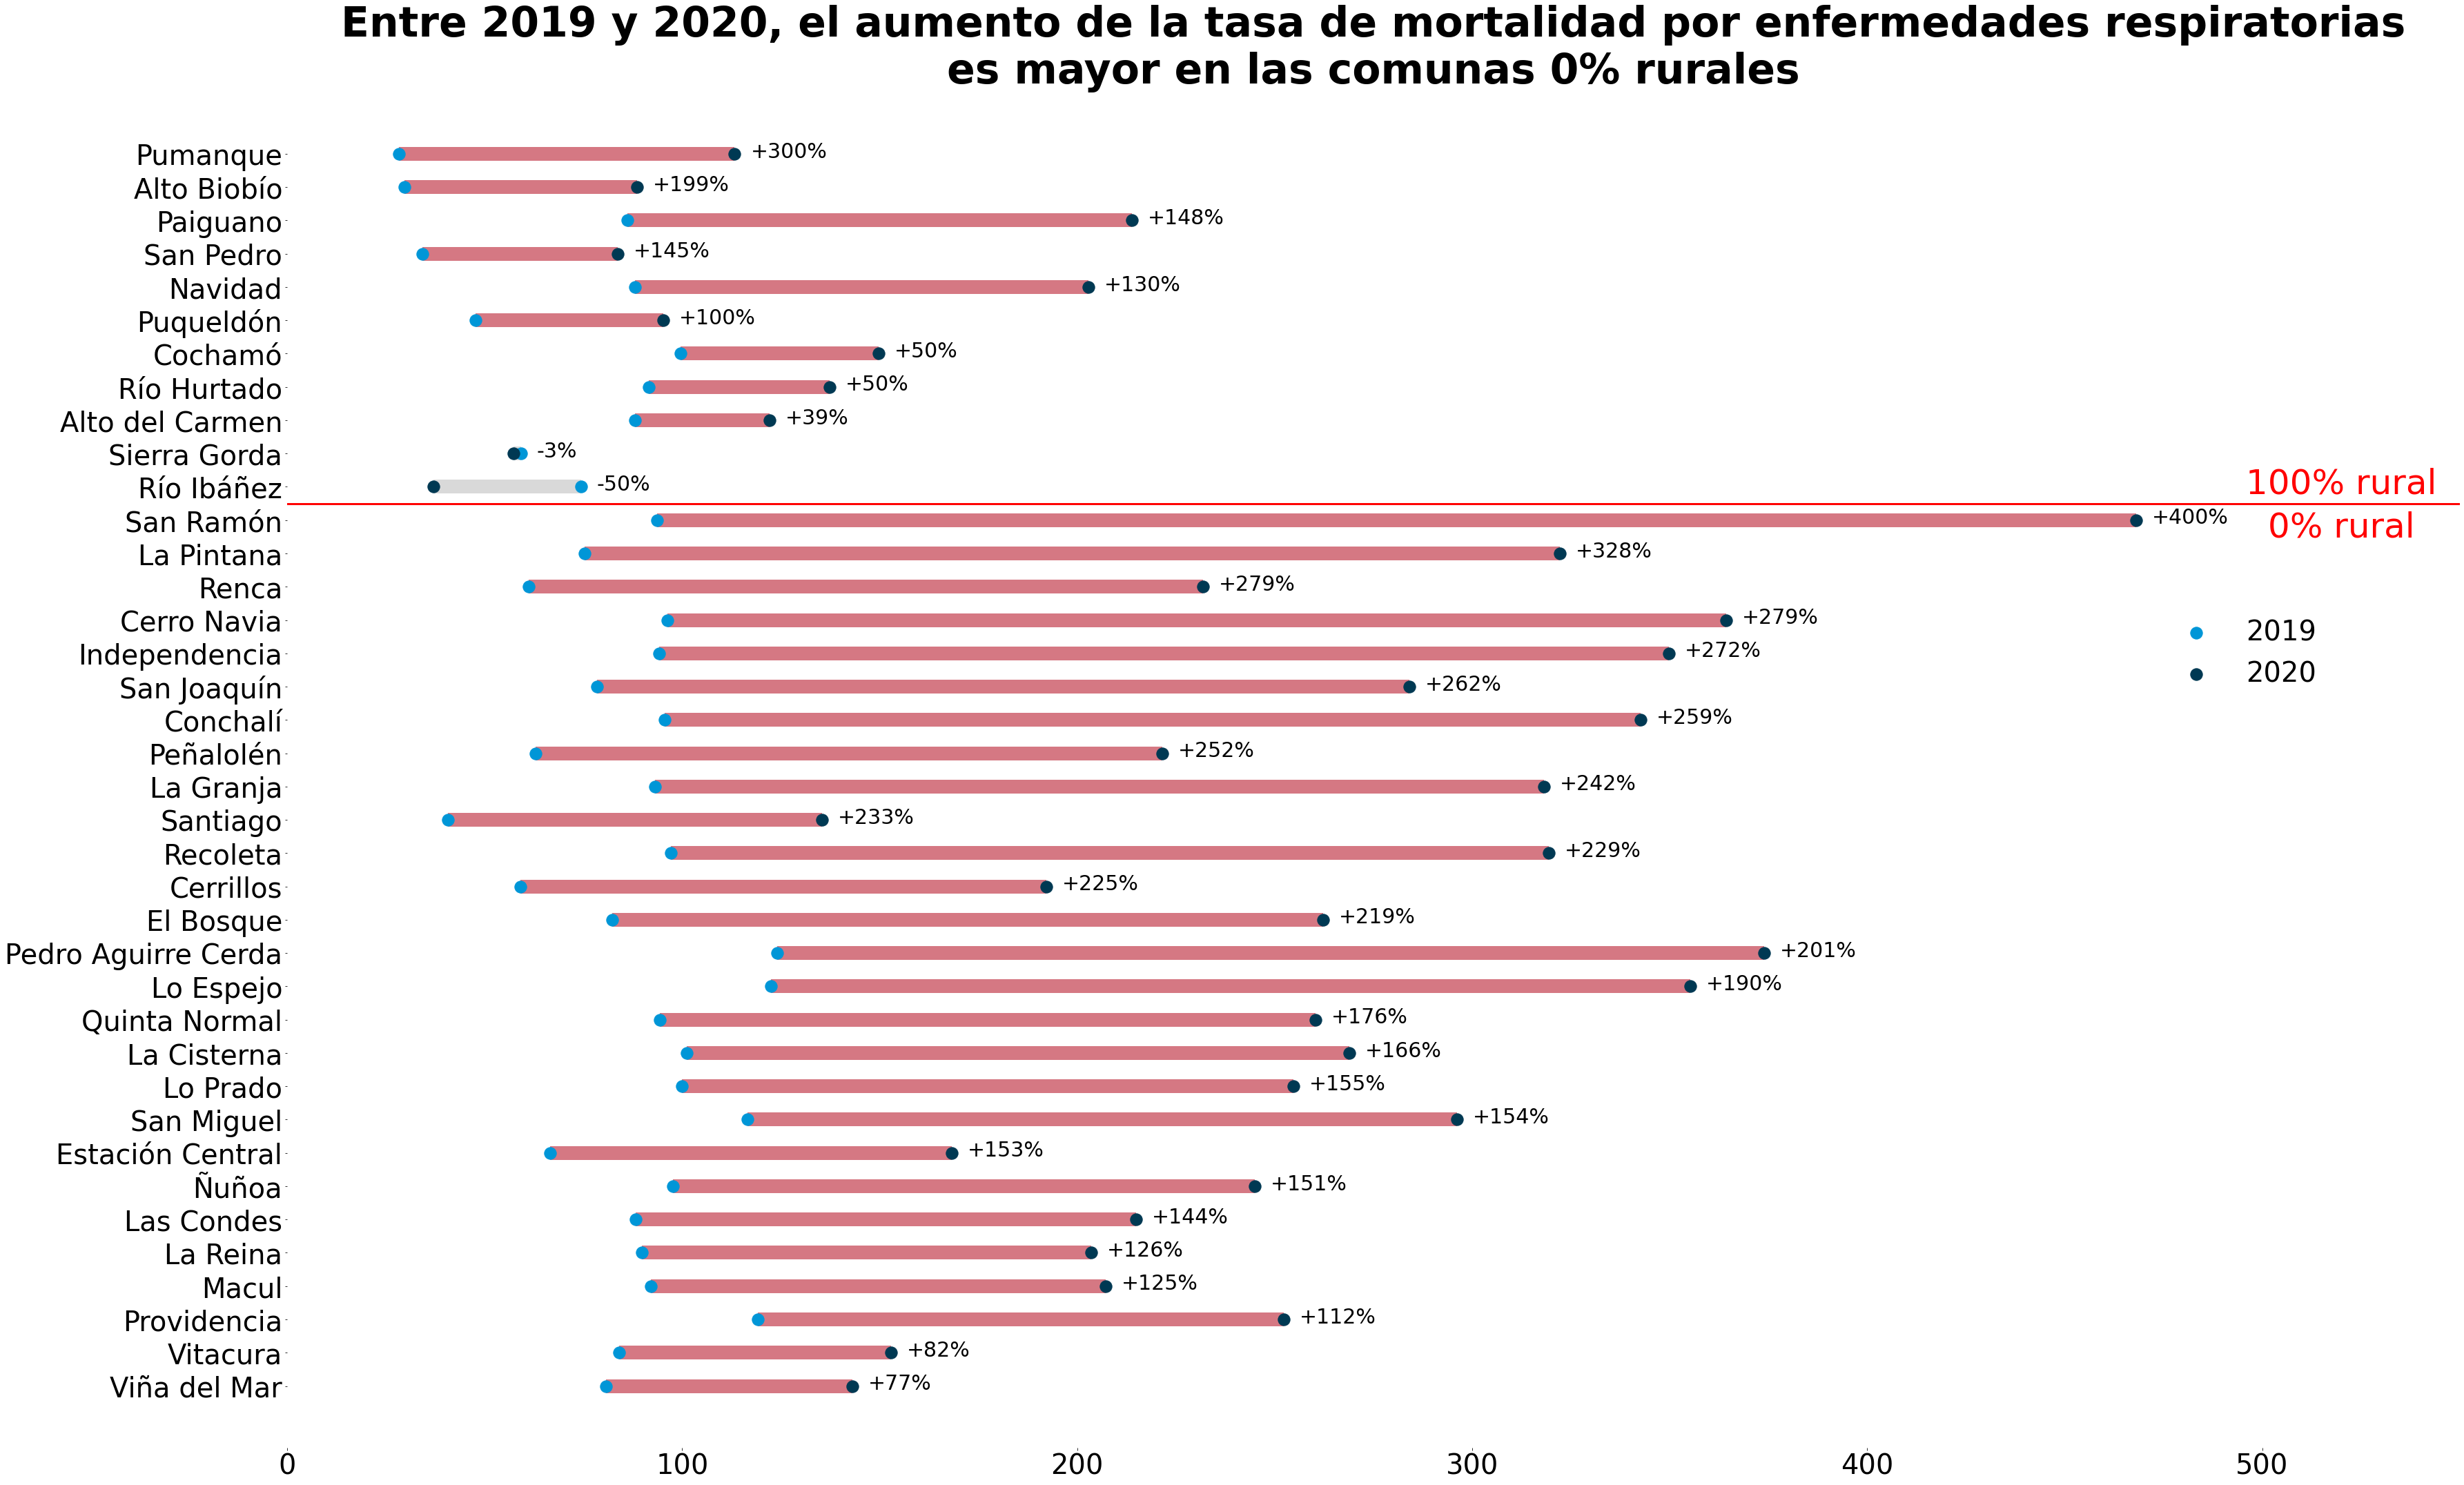

In [39]:

fig,ax = plt.subplots(figsize=(50,30))

y_range = np.arange(1, len(tab14.index) + 1)
colors = np.where(tab14['anio_2020'] > tab14['anio_2019'], '#d57883', '#d9d9d9')

plt.hlines(y=y_range, xmin=tab14['anio_2019'], xmax=tab14['anio_2020'],
           color=colors, lw=20)
plt.scatter(tab14['anio_2019'], y_range, color='#0096d7', s=300, label='2019', zorder=3)
plt.scatter(tab14['anio_2020'], y_range, color='#003953', s=300 , label='2020', zorder=3)

plt.yticks(y_range, tab14.index,fontsize=40)
plt.xticks(fontsize=40)
plt.title("Entre 2019 y 2020, el aumento de la tasa de mortalidad por enfermedades respiratorias\nes mayor en las comunas 0% rurales",
         fontsize=60,position= (.5,0),weight='bold')
plt.xlim(0, 550)
plt.gcf().subplots_adjust(left=0.85)
plt.tight_layout()
for (_, row), y in zip(tab14.iterrows(), y_range):
    plt.annotate(f"{row['delta']:+.0%}", (max(row["anio_2019"], row["anio_2020"]) + 4, y - .1), fontsize=30)
plt.legend(ncol=1,bbox_to_anchor=(1., 0.4, -0.2, 0.23), loc='upper center', frameon=False, prop={'size': 40})
hide_border(ax)
plt.axhline(y=27.5, color='r', linestyle='-',lw=3)
plt.text(520,27.8, '100% rural', ha='center',fontsize=50,c='red')
plt.text(520,26.5, '0% rural', ha='center',fontsize=50,c='red')
plt.show()


## Diferencias en las causas de mortalidad entre comunas de la Región Metropolitana
Estudios anteriores (Bilal, Alazraqui, Caiaffa, Lopez-Olmedo, Martinez-Folgar, Miranda, et. al., 2019) han mostrado que los habitantes de las comunas de mayores ingresos de la Región Metropolitana tienen una mayor esperanza de vida que aquellos de comunas de menores ingresos, de modo que es interesante analizar si esas diferencias en la esperanza de vida se asocian a su vez a diferentes causas de muerte. 

A continuación, se exploran diferencias en las tasas de mortalidad según algunas causas, para el último año disponible (2021), en las comunas de la Región Metropolitana, las cuales presentan diferencias en cuanto a su nivel socioeconómico, de modo que el análisis permite obtener evidencia respecto a la asociación entre el nivel socioeconómico y las causas de muerte de la población.

In [40]:
comunas = (gpd.read_file('Comunas/comunas.shp')
           .drop(['Comuna'], axis=1)
          .rename(columns={'cod_comuna':'Comuna'}))
comunas = comunas[comunas['Region']=='Región Metropolitana de Santiago'].set_index('Comuna')
tasa_res_rm =tasa_def_com[(tasa_def_com['region']==13) & 
                          (tasa_def_com['causa']=='Enfermedades del sistema respiratorio ') &
                         (tasa_def_com['anio']==2021)].set_index('Comuna')

Como se observa en el siguiente gráfico, en las comunas del sur del Gran Santiago, así como San José de Maipo, presentan una mayor mortalidad por enfermedades respiratorias en el año 2021. De este modo, es posible concluir que el Covid-19 repercutió de mayor forma en los sectores de menores ingresos. Esta situación puede deberse a distintos factores, tales como la mayor presencia de enfermedades pre-existentes y el hecho de que las personas de menor nivel socioeconómico desempeñan trabajos menos calificados, los cuales tienen posibilidades de realizarse de forma remota, estando así más expuestos al virus.

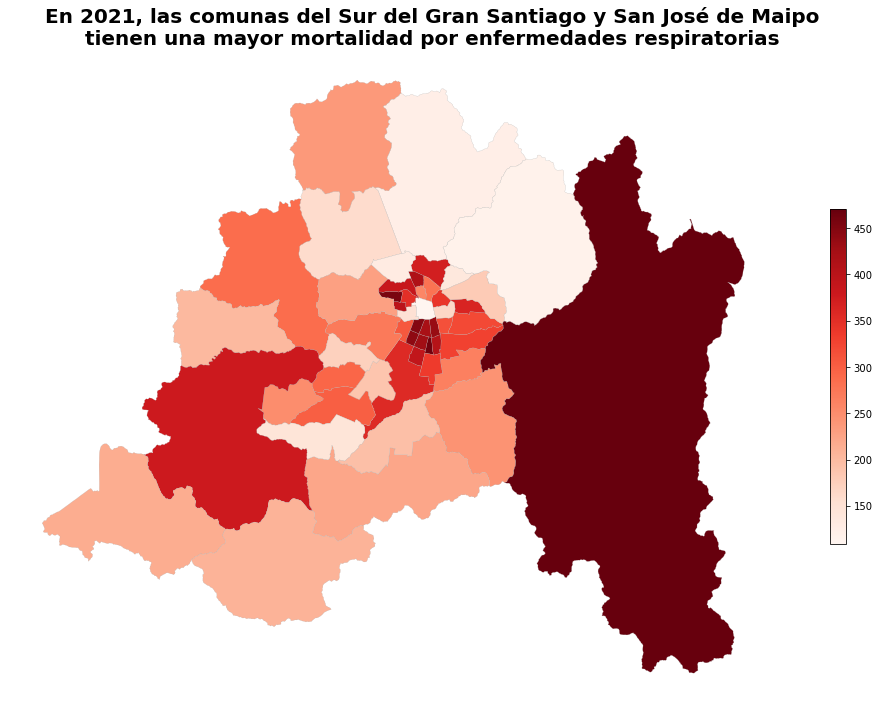

In [41]:
min_sup = tasa_res_rm.tasa_def_com.min()
max_sup = tasa_res_rm.tasa_def_com.max()
    
YlGn = cm.get_cmap('Reds')
norm = Normalize(vmin=min_sup, vmax=max_sup)

# Function that returns the color for a given sup
def get_color(tasa_def_com):
    color_number = (tasa_def_com - min_sup) / (max_sup - min_sup)
    return YlGn(color_number)
fig, ax = plt.subplots(1, 1, figsize=(30,12))

comunas.join(tasa_res_rm, how='inner').plot(ax=ax,
                                            column='tasa_def_com',
                                            k=52,
                                            scheme='Fisher_Jenks',
                                            cmap='Reds',
                                            edgecolors='#abacab',
                                            linewidth=0.2,
                                            legend=False)

plt.title('En 2021, las comunas del Sur del Gran Santiago y San José de Maipo\ntienen una mayor mortalidad por enfermedades respiratorias',
         fontsize=20,position= (.55,0),weight='bold')

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax,fraction=0.01, pad=0.03)

ax.set_axis_off()

plt.show()

En cuanto a las muertes por traumatismos y causas externas, en el caso del Gran Santiago, estas son mayores en la zona poniente y sur, que es donde se concentran las personas de menores recursos. Esto podría estar asociado a mayores niveles de delincuencia y violencia a las que estas personas se ven expuestas. Asimismo, se observa una alta tasa de mortalidad por esta causa en las comunas que están más alejadas del centro urbano, lo cual podría deberse al hecho de contar con menor acceso a recintos asistenciales de alta complejidad, de modo que los accidentes no pueden ser atendidos de forma oportuna y terminan en fallecimientos.

In [42]:
tasa_traum_rm =tasa_def_com[(tasa_def_com['region']==13) & 
                          (tasa_def_com['causa']=='Traumatismos, envenenamientos y algunas otras consecuencias de causas externas') &
                         (tasa_def_com['anio']==2021)].set_index('Comuna')

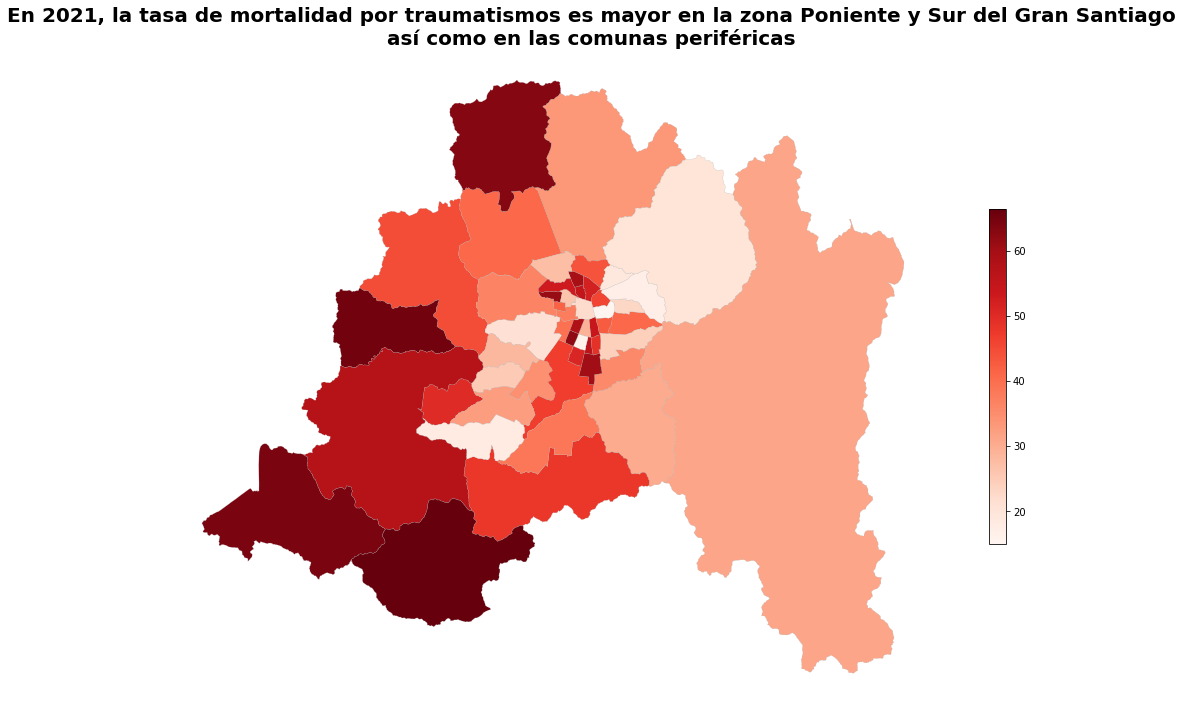

In [43]:
min_sup = tasa_traum_rm.tasa_def_com.min()
max_sup = tasa_traum_rm.tasa_def_com.max()
    
YlGn = cm.get_cmap('Reds')
norm = Normalize(vmin=min_sup, vmax=max_sup)

# Function that returns the color for a given sup
def get_color(tasa_def_com):
    color_number = (tasa_def_com - min_sup) / (max_sup - min_sup)
    return YlGn(color_number)
fig, ax = plt.subplots(1, 1, figsize=(30,12))

comunas.join(tasa_traum_rm, how='inner').plot(ax=ax,
                                            column='tasa_def_com',
                                            k=51,
                                            scheme='Fisher_Jenks',
                                            cmap='Reds',
                                            edgecolors='#abacab',
                                            linewidth=0.2,
                                            legend=False)

plt.title('En 2021, la tasa de mortalidad por traumatismos es mayor en la zona Poniente y Sur del Gran Santiago\nasí como en las comunas periféricas',
         fontsize=20,position= (.55,0),weight='bold')

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax,fraction=0.01, pad=0.03)

ax.set_axis_off()

plt.show()

Respecto a las muertes ocasionadas por el sistema nervioso central, estas se comportan distinto a las anteriormente analizadas, puesto que se concentran en las comunas de mayores ingresos del Gran Santiago, también conocido como 'sector oriente'. Este fenómeno es la contracara de la mayor mortalidad por causas externas en niveles socioeconómicos bajos, ya que estos fallecimientos en general se producen a más temprana edad. De este modo, debido a que las personas de mayores ingresos viven más, es más probable que sufran de deterioro cognitivo propio de la edad y, por ende, fallecer por estos motivos.

In [44]:
tasa_nerv_rm =tasa_def_com[(tasa_def_com['region']==13) & 
                          (tasa_def_com['causa']=='Enfermedades del sistema nervioso central') &
                         (tasa_def_com['anio']==2021)].set_index('Comuna')

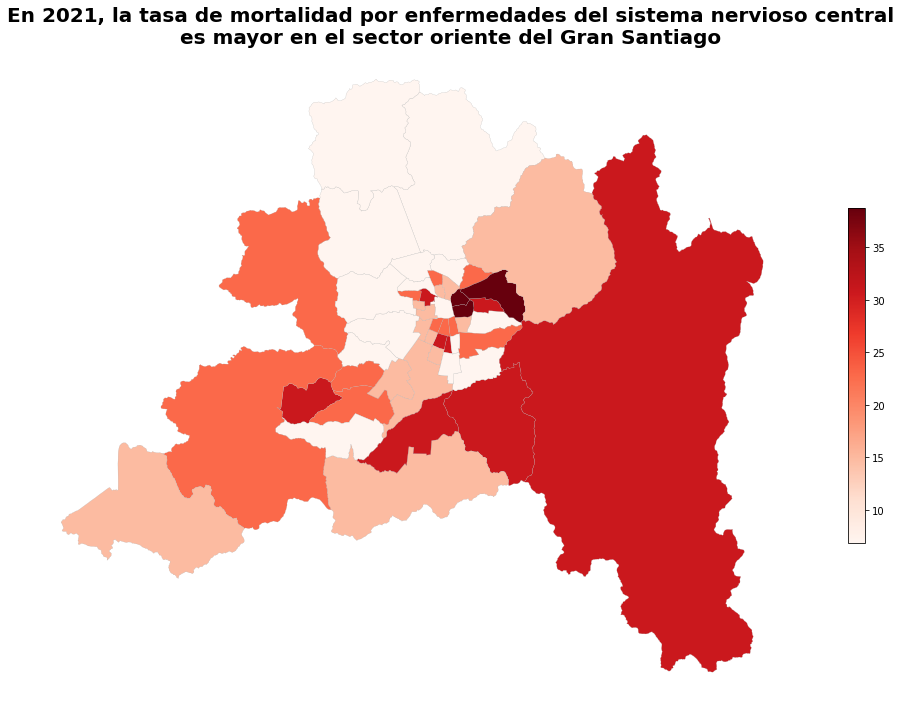

In [45]:
min_sup = tasa_nerv_rm.tasa_def_com.min()
max_sup = tasa_nerv_rm.tasa_def_com.max()
    
YlGn = cm.get_cmap('Reds')
norm = Normalize(vmin=min_sup, vmax=max_sup)

def get_color(tasa_def_com):
    color_number = (tasa_def_com - min_sup) / (max_sup - min_sup)
    return YlGn(color_number)
fig, ax = plt.subplots(1, 1, figsize=(30,12))

comunas.join(tasa_nerv_rm, how='inner').plot(ax=ax,
                                            column='tasa_def_com',
                                            #k=49,
                                            scheme='Fisher_Jenks',
                                            cmap='Reds',
                                            edgecolors='#abacab',
                                            linewidth=0.2,
                                            legend=False)

plt.title('En 2021, la tasa de mortalidad por enfermedades del sistema nervioso central\nes mayor en el sector oriente del Gran Santiago',
         fontsize=20,position= (.55,0),weight='bold')

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax,fraction=0.01, pad=0.03)

ax.set_axis_off()

plt.show()

En relación a las muertes ocasionadas por enfermedades de salud mental y del comportamiento, estas son mayores en las comunas periféricas de la Región Metropolitana. Este fenómeno podría deberse a la ruralidad y su cultura, la cual se asocia a un consumo problemático y normalizado del alcohol, así como un mayor prejuicio (y por ende, menos acceso a tratamiento) contra las enfermedades mentales.

In [46]:
tasa_ment_rm =tasa_def_com[(tasa_def_com['region']==13) & 
                          (tasa_def_com['causa']=='Trastornos mentales y del comportamiento') &
                         (tasa_def_com['anio']==2021)].set_index('Comuna')

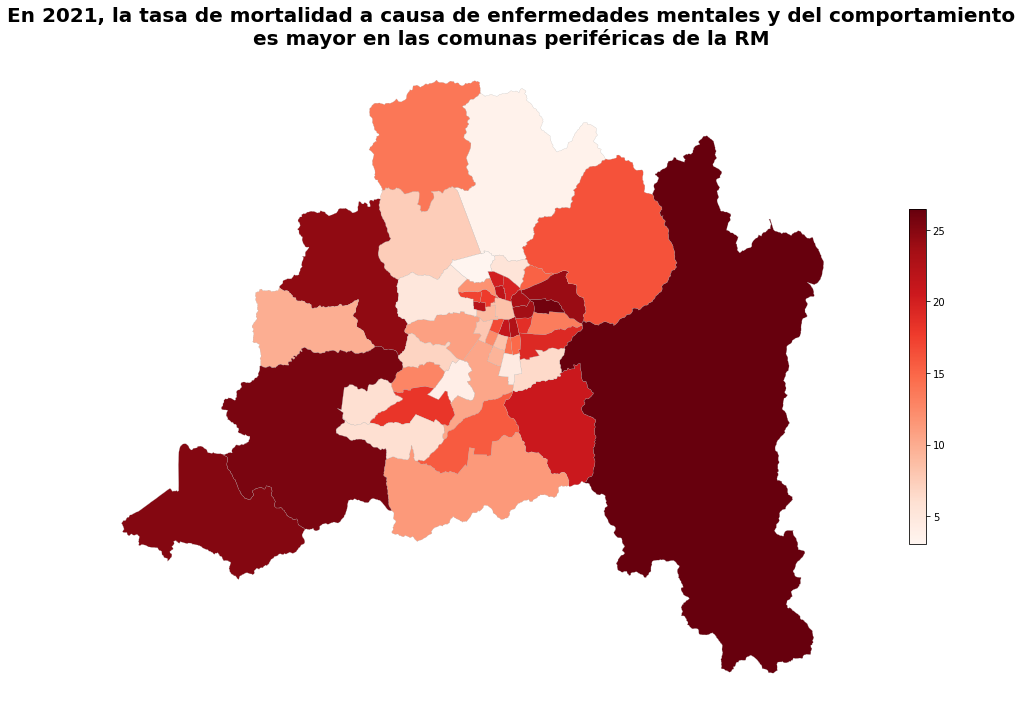

In [47]:
min_sup = tasa_ment_rm.tasa_def_com.min()
max_sup = tasa_ment_rm.tasa_def_com.max()
    
YlGn = cm.get_cmap('Reds')
norm = Normalize(vmin=min_sup, vmax=max_sup)

def get_color(tasa_def_com):
    color_number = (tasa_def_com - min_sup) / (max_sup - min_sup)
    return YlGn(color_number)
fig, ax = plt.subplots(1, 1, figsize=(30,12))

comunas.join(tasa_ment_rm, how='inner').plot(ax=ax,
                                            column='tasa_def_com',
                                            k=49,
                                            scheme='Fisher_Jenks',
                                            cmap='Reds',
                                            edgecolors='#abacab',
                                            linewidth=0.2,
                                            legend=False)

plt.title('En 2021, la tasa de mortalidad a causa de enfermedades mentales y del comportamiento\nes mayor en las comunas periféricas de la RM',
         fontsize=20,position= (.55,0),weight='bold')

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax,fraction=0.01, pad=0.03)

ax.set_axis_off()

plt.show()

## Conclusiones
En el presente informe, se presentaron distintos análisis relacionados a las tasas de mortalidad por causa en Chile, para el período 2016-2021. El primer hallazgo a destacar es que durante 2020 y 2021 hubo un aumento en la tasa de mortalidad general en Chile, debido a la pandemia por Covid-19 que ha afectado al mundo. A su vez, desde 2016 a 2019 las principales causas de muerte en la población general eran enfermedades del sistema circulatorio y tumores, mientras que en 2020 y 2021 estas fueron superadas por las enfermedades del sistema respiratorio.



En cuanto a la estacionalidad, existen ciertas patologías que causan más muertes en invierno, como las enfermedades del sistema respiratorio y del sistema circulatorio, mientras que otras, como los traumatismos y causas externas, son más comunes en los meses de verano.

Al desagregar por edad, en el grupo de 0 a 9 años las principales causas de muerte son afecciones generadas en el período perinatal, y malformaciones congénitas, aunque ambas presentan una baja en los últimos años. Una hipótesis que puede explicar este fenómeno es la ley de interrupción voluntaria del embarazo en tres causales, que considera la causa de ‘inviabilidad fetal’. En el grupo de 10 a 19 y de 20 a 39 años, la primera causa de muerte son los traumatismos, envenenamientos y otras consecuencias de causas externas, seguida por lo tumores. Por otro lado, en el grupo de 40 a 59 y de 60 a 79 años, los tumores pasan al primer lugar en causas de fallecimientos, pero en 2021 son superados por las enfermedades del sistema respiratorio, de modo que en estos grupos se comienzan a vislumbrar los efectos del Covid-19. Por último, en las personas de 80 años o más, la principal causa de muerte son las enfermedades del sistema circulatorio, aunque solo hasta 2020, ya que en 2021 también son superadas (aunque levemente) por las enfermedades del sistema respiratorio.

Respecto al comportamiento de la mortalidad ocasionada por enfermedades del sistema respiratorio, en las regiones Metropolitana y de Antofagasta, la mayor cantidad de muertes ocurrió a mediados de 2020. Por otro lado, en Arica y Parinacota, Tarapacá, O'Higgins y Magallanes, son más notorias las dos olas de Covid-19 que hubo a nivel nacional. Para el resto de las regiones, se observa una mayor tasa de mortalidad por esta causa en el año 2021, especialmente en el primer semestre. Cabe destacar que, para todos las regiones, durante el segundo semestre de 2021 se observa una baja en la mortalidad, lo que se debe a la alta cobertura de vacunación lograda. 

En cuanto a las muertes ocasionadas por enfermedades del sistema circulatorio, entre las regiones de Coquimbo y La Araucanía, se observa una estacionalidad más clara que en el resto, con una mayor tasa de mortalidad en los meses de invierno. Otra de las principales causas de muerte en Chile son los tumores, sin embargo, en este caso no existe una estacionalidad, sino que las muertes se distribuyen a lo largo del año.

Al analizar las diferencias de género, para todos los años analizados la mayor brecha se encuentra en las muertes por traumatismos, envenenamientos y otras causas externas, siendo aproximadamente 200% mayor en hombres que en mujeres. Este fenómeno se asocia a los roles y expectativas de género predominantes en la sociedad, lo que los lleva a involucrarse, en mayor medida, en situaciones violentas y riesgosas que terminan en muertes tempranas ocasionadas por causas externas. Otro aspecto a destacar es que, en los años 2020 y 2021, en los hombres existe una mayor mortalidad debido a enfermedades respiratorias, diferencia que no se observa en los años anteriores. Por lo tanto, la pandemia de Covid-19 fue más letal en hombres que en mujeres.

Junto a lo anterior, se observa una tendencia interesante al comparar aquellas comunas con población 100% rural respecto a aquellas con 0% de ruralidad, en términos de tasa de mortalidad por enfermedades respiratorias. Entre 2018 y 2019, la mayoría de las comunas 100% rurales disminuyó la mortalidad por esta causa, mientras que la gran parte de las comunas 100% rurales experimentó un aumento. Ahora bien, entre 2019 y 2020, producto de la pandemia por Covid-19, en ambos grupos existe un aumento de la mortalidad, sin embargo, en las comunas completamente urbanizadas este es mayor. Por lo tanto, este último grupo se vio más afectado por la pandemia, lo cual puede ser consecuencia de una mayor densidad poblacional, que a su vez repercute en una mayor exposición al virus.

Por último, se analizan las tasas de mortalidad para ciertas causas, para el año 2021 en las comunas de la Región Metropolitana. Esta se caracteriza por una marcada segregación socioeconómica, de modo que este análisis permite encontrar patrones de mortalidad según nivel socioeconómico. En cuanto a las enfermedades respiratorias, existe una mayor mortalidad en las comunas del sector sur del Gran Santiago, que son las de menores ingresos, así como San José de Maipo. Respecto a las muertes por traumatismos, se concentran principalmente en la zona poniente y sur del Gran Santiago, las cuales se caracterizan por tener un menor nivel socioeconómico. La causa de este fenómeno podría estar asociada a los mayores niveles de delincuencia y violencia a los que estos grupos se ven expuestos. Asimismo, en las comunas de la periferia de la Región Metropolitana también existe una alta tasa de mortalidad por causas externas, lo cual podría ser consecuencia del menor acceso a establecimientos de salud de alta complejidad. Por otro lado, la tasa de mortalidad debido a enfermedades del sistema nervioso central es mayor en las comunas de mayores ingresos de la Región Metropolitana, lo que probablemente es consecuencia de que esta población tiene una mayor esperanza de vida y, por lo tanto, es más probable que desarrollen enfermedades neurodegenerativas asociadas a la edad. Por último, la tasa de mortalidad debido a enfermedades de salud mental es mayor en las comunas periféricas, las cuales cuentan con mayor población rural, por lo que podría ser consecuencia de la cultura propia de estas zonas, donde existe un alto consumo problemático de alcohol y prejuicios contra las enfermedades mentales.

A modo de síntesis general, el presente informe muestra la importancia de distintos determinantes sociales de la salud y su incorporación en las políticas de salud pública. Por ejemplo, se releva la necesidad de incorporar enfoque de género no solo en políticas de salud pública, sino también de modo transversal en los distintos programas del gobierno, para así contribuir a una menor tasa de mortalidad por causas externas en la población masculina. Asimismo, es importante tener en consideración las diferencias culturales entre zonas urbanas y rurales, así como entre las distintas regiones del país. Del mismo modo, es necesario generar políticas, en distintos ámbitos, para mejorar la calidad de vida y hábitos de las personas de nivel socioeconómico más bajo. Ejemplo de esto es la disminución de la delincuencia, la cual podría ayudar a disminuir la tasa de mortalidad por causas externas. 



## Bibliografía
Bilal, U., Alazraqui, M., Caiaffa, W. T., Lopez-Olmedo, N., Martinez-Folgar, K., Miranda, J. J., Rodriguez D., Vives A. & Diez-Roux, A. V. (2019). Inequalities in life expectancy in six large Latin American cities from the SALURBAL study: an ecological analysis. _The lancet planetary health_, 3 (12), e503-e510.

INE. (*s.f.*). *Esperanza de vida*. https://www.ine.cl/ine-ciudadano/definiciones-estadisticas/poblacion/esperanza-de-vida#:~:text=En%20Chile%20la%20Esperanza%20de,77%2C3%20para%20los%20hombres.

INE. (2022). *Boletín de Estadísticas Vitales. Cifras provisionales 2022*. https://www.ine.cl/docs/default-source/nacimientos-matrimonios-y-defunciones/publicaciones-y-anuarios/anuarios-de-estad%C3%ADsticas-vitales/estad%C3%ADsticas-vitales-cifras-provisionales-2020.pdf?sfvrsn=3f5da8b1_6

Rodríguez, Ricardo. (2015). Juegos de chicos, lesiones de jóvenes, muertes de hombres: masculinidades y prevención de la violencia. *Sociológica (México)*, 30 (84), 75-115.
